<a href="https://colab.research.google.com/github/tchaase/cVAE_autism/blob/main/code/cVAE_autism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contrastive Variational Autoencoder for the ABIDE Data Set

Author - Tobias Haase

## Set-Up

Firstly I am importaing the necessary modules here, that I will use within the following.



In [76]:
import torch  # The main PyTorch library for tensor computations and neural network operations

import torch.nn as nn  # Provides various neural network layers and functionalities
import torch.nn.functional as F  # Provides functional interfaces to common operations (e.g., activation functions)
import torch.optim as optim  # Contains various optimization algorithms (e.g., SGD, Adam)

import torchvision  # A PyTorch library for computer vision tasks
import torchvision.transforms as transforms  # Provides common image transformations (e.g., resizing, normalization)
from torchvision.transforms import ToTensor  # Transforms PIL images to tensors
from torch.utils.data import Dataset, DataLoader  # Provides tools for creating custom datasets and data loaders
import torch.nn as nn

import numpy as np  # NumPy library for numerical computations and array operations
import matplotlib  # Matplotlib library for data visualization
import matplotlib.pyplot as plt  # Matplotlib's pyplot module for creating plots
from tqdm import tqdm  # Progress bar library for tracking iterations

import os
import requests
import nibabel as nib
import numpy as np
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cpu')

Now, it is very helpful to keep a set seed so my analyes are reproducible.

In [79]:
import random
import numpy as np
import torch

seed_value = 42

# Set seed for Python's random module
random.seed(seed_value)

# Set seed for NumPy
np.random.seed(seed_value)

# Set seed for PyTorch (CPU and CUDA)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Now all random operations in Python, NumPy, and PyTorch will be reproducible

And this to make my graphics all useable for later writing:

In [78]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Increase font size for all Matplotlib elements
mpl.rcParams['font.size'] = 14  # You can adjust the size as needed

# Optionally, you can increase the font size for specific elements:
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14


### Preparing and loading the data


Next, I am loading the project's data. To load the data there are multiple options - one is cyberduck. I deviated from using cyberduck as it was easier to figure out the links for other files via `urllib.request.urlretrieve`. However I am leaving the code here - but commenting it out.

Firstly, to use **CyberDuck**, one would need to install it:


In [ ]:
#!echo -e "deb https://s3.amazonaws.com/repo.deb.cyberduck.io stable main" | sudo tee /etc/apt/sources.list.d/cyberduck.list > /dev/null
#!sudo apt-key adv --keyserver keyserver.ubuntu.com --recv-keys FE7097963FEFBE72
#!sudo apt-get update
#!sudo apt-get install duck

#duck --username anonymous --verbose --download s3:/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/ants/anat_thickness/*_anat_thickness.nii.gz ./drive/MyDrive/MasterThesisData

As I want to use a specific atlas, I need to do the transformations myself. For this, I need access to the ANTs pipeline. Thankfully you can load it like below, as explained [here]( https://colab.research.google.com/drive/1g5cnZxj1llRaHmOs4xSglqsXnFkQYuol?usp=sharing#scrollTo=7J9SVgWtVD_D).

In [ ]:
import os
os.environ["LD_PRELOAD"] = "";
os.environ["APPTAINER_BINDPATH"] = "/content"
os.environ["LMOD_CMD"] = "/usr/share/lmod/lmod/libexec/lmod"

!curl -J -O https://raw.githubusercontent.com/NeuroDesk/neurocommand/main/googlecolab_setup.sh
!chmod +x googlecolab_setup.sh
!./googlecolab_setup.sh
os.environ["MODULEPATH"] = ':'.join(map(str, list(map(lambda x: os.path.join(os.path.abspath('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/'), x),os.listdir('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/')))))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3338  100  3338    0     0  11522      0 --:--:-- --:--:-- --:--:-- 11510
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
lsb-release is already the newest version (11.1.0ubuntu4).
lsb-release set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
--2023-09-06 12:36:26--  https://ecsft.cern.ch/dist/cvmfs/cvmfs-release/cvmfs-release-latest_all.deb
Resolving ecsft.cern.ch (ecsft.cern.ch)... 188.184.97.7
Connecting to ecsft.cern.ch (ecsft.cern.ch)|188.184.97.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5284 (5.2K)
Saving to: ‘cvmfs-release-latest_all.deb’

cvmfs-release-lates 100%[===================>]   5.16K  --.-KB/s    in 0s      

2023-09-06 12:36:27 (60.4 MB/s) - ‘cvmfs-release-latest_all.deb’ saved [5284/528

FileNotFoundError: ignored

Now I just load a version of ants!

In [ ]:
import lmod
await lmod.load('ants/2.3.5')

Next, I am mounting the drive so I can use it later to store the data.

In [ ]:
#!ls ./data/anat_thickness/
!rm -rf ./data

from google.colab import drive
drive.mount('/content/drive')


Now, its helpful to have the file with the participant info already.

In [ ]:
# URL to download the CSV file!
csv_url = "https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv"  # Replace with the actual URL

# Directory to store the CSV file
data_directory = "./data/participant_info"

# Create the directory if it does not exist
os.makedirs(data_directory, exist_ok=True)

# File path to save the CSV file
csv_file_path = os.path.join(data_directory, "participant_info.csv")

# Download the CSV file
response = requests.get(csv_url)
if response.status_code == 200:
    with open(csv_file_path, "wb") as f:
        f.write(response.content)
    print("CSV file downloaded successfully.")
else:
    print("Failed to download the CSV file.")


CSV file downloaded successfully.


To get the data transformed later I will also need a template. This is loaded here!

In [ ]:
!pip install templateflow
from templateflow import api as tflow
mni152 = tflow.get('MNI152NLin2009cAsym', desc=None, resolution=1,
                    suffix='T1w', extension='nii.gz')
mni152_path = str(mni152)

Now that we have the template, the pipelines we can actually load the data. But first let's define the relevant directories.

In [ ]:
#!pip install ants
!pip install nipype

import pandas as pd
import os
import shutil
import urllib.request
from nipype.interfaces.ants import ApplyTransforms

# Define paths
data_directory = "./data/participant_info"
transformed_directory = './drive/MyDrive/MasterThesisData/transformed'
temp_directory = '/content/temp_data'  # Temporary directory

# Create directories if they don't exist
os.makedirs(transformed_directory, exist_ok=True)
os.makedirs(temp_directory, exist_ok=True)

# Load the CSV file
csv_file_path = os.path.join(data_directory, "participant_info.csv")
data = pd.read_csv(csv_file_path)
participant_info = data
failed_download = []

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.5 MB/s eta 0:00:00


Let's attempt this with one participant and see if it works.

In [ ]:
sub_id = "50003"

try:
    # Construct the MRI data file name
    mri_data_file = f"{file_id}_anat_thickness.nii.gz"
    mri_data_path = os.path.join(temp_directory, mri_data_file)

    # Download the MRI data file to the temporary directory
    mri_url = f"https://fcp-indi.s3.amazonaws.com/data/Projects/ABIDE/Outputs/mindboggle_swf/mindboggle/ants_subjects/sub-00{sub_id}/antsCorticalThickness.nii.gz"
    urllib.request.urlretrieve(mri_url, mri_data_path)

    # Construct the transformation template file name
    template_file_name = f'sub-00{sub_id}_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5'
    template_destination = os.path.join(temp_directory, template_file_name)

    # Download the transformation template
    template_url = f"https://fcp-indi.s3.amazonaws.com/data/Projects/ABIDE/Outputs/fmriprep/fmriprep/sub-00{sub_id}/anat/{template_file_name}"
    urllib.request.urlretrieve(template_url, template_destination)

    # Define paths for the transformed output
    transformed_output_path = os.path.join(transformed_directory, f"sub-00{sub_id}_space-MNI152NLin2009cAsym_desc-corticalthickness.nii.gz")

    from nipype import config, logging
    from nipype.interfaces.base import CommandLine

    # Set the execution plugin to CommandLine
    config.enable_debug_mode()
    config.enable_provenance()
    logging.update_logging(config)

    # Define the antsApplyTransforms interface
    at = ApplyTransforms()
    at.inputs.input_image = mri_data_path
    at.inputs.reference_image = mni152_path
    at.inputs.transforms = template_destination
    at.inputs.output_image = transformed_output_path

    # Execute the antsApplyTransforms command
    cmdline = at.cmdline
    cl = CommandLine(command=cmdline)
    cl.run()

    # Clean up: Delete the input data and template
    !rm /content/temp_data/*

    print(f"Transformed and saved for FILE_ID: {file_id}")

except Exception as e:
    print(f"Failed for FILE_ID: {file_id}. Error: {e}")


Great! Now onto all the other participants.

In [ ]:
for index, row in data.iterrows():
    file_id = row['FILE_ID']
    sub_id = row['SUB_ID']

    try:
        # Construct the MRI data file name
        mri_data_file = f"{file_id}_anat_thickness.nii.gz"
        mri_data_path = os.path.join(temp_directory, mri_data_file)

        # Download the MRI data file to the temporary directory
        mri_url = f"https://fcp-indi.s3.amazonaws.com/data/Projects/ABIDE/Outputs/mindboggle_swf/mindboggle/ants_subjects/sub-00{sub_id}/antsCorticalThickness.nii.gz"
        urllib.request.urlretrieve(mri_url, mri_data_path)

        # Construct the transformation template file name
        template_file_name = f'sub-00{sub_id}_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5'
        template_destination = os.path.join(temp_directory, template_file_name)

        # Download the transformation template
        template_url = f"https://fcp-indi.s3.amazonaws.com/data/Projects/ABIDE/Outputs/fmriprep/fmriprep/sub-00{sub_id}/anat/{template_file_name}"
        urllib.request.urlretrieve(template_url, template_destination)

        # Define paths for the transformed output
        transformed_output_path = os.path.join(transformed_directory, f"sub-00{sub_id}_space-MNI152NLin2009cAsym_desc-corticalthickness.nii.gz")

        from nipype import config, logging
        from nipype.interfaces.base import CommandLine

        # Set the execution plugin to CommandLine
        config.enable_debug_mode()
        config.enable_provenance()
        logging.update_logging(config)

        # Define the antsApplyTransforms interface
        at = ApplyTransforms()
        at.inputs.input_image = mri_data_path
        at.inputs.reference_image = mni152_path
        at.inputs.transforms = template_destination
        at.inputs.output_image = transformed_output_path

        # Execute the antsApplyTransforms command
        cmdline = at.cmdline
        cl = CommandLine(command=cmdline)
        cl.run()

        # Clean up: Delete the input data and template
        !rm "./temp_data/*"

        print(f"Transformed and saved for FILE_ID: {file_id}")

    except Exception as e:
        print(f"Failed for FILE_ID: {file_id}. Error: {e}")

print("Processing completed.")


Now, I need to actually apply the atlas. In this step I am loading the atlas and the corresponding labels.

In [ ]:
# Load the atlas
!pip install nilearn
from nilearn.datasets import fetch_atlas_destrieux_2009
from nilearn.image import load_img

atlas_destrieux_dataset = fetch_atlas_destrieux_2009(lateralized = True)
atlas_destrieux = load_img(atlas_destrieux_dataset.maps)

# From this, we can also export the labels that we can use for later visualization.
labels = atlas_destrieux_dataset.labels



We can now use the niftilabelmasker to actually apply the mask. Of course I should use a loop here later!

In [ ]:
from nilearn.maskers import NiftiLabelsMasker

masker_destrieux = NiftiLabelsMasker(labels_img=atlas_destrieux)

thickness_data_dict = {}

for filename in os.listdir(transformed_directory):
    if filename.endswith("_desc-corticalthickness.nii.gz"):
        sub_id = filename.split("_")[0].replace("sub-", "")
        thickness_filename = f"thickness_{sub_id}"

        thickness_data = masker_destrieux.fit_transform(os.path.join(transformed_directory, filename))

        thickness_data_dict[sub_id] = {
            "sub_id": sub_id,
            "data": thickness_data
        }

        print(f"Processed for sub_id: {sub_id}")


In a next step I will use this data to create dictionaries containing all the data, as well as the labels that will be used for training.

In [ ]:
# Read the participant information from the CSV file
csv_file = "./data/participant_info/participant_info.csv"
participant_info_df = pd.read_csv(csv_file)

# Create dictionaries to store data and participant information for autism and non-autism participants
data_info_dict_autism = {}
data_info_dict_no_autism = {}

# Loop through the thickness data dictionary
for sub_id, thickness_data_entry in thickness_data_dict.items():
    # Find the participant's information based on SUB_ID
    participant_row = participant_info_df.loc[participant_info_df['SUB_ID'] == int(sub_id)]
    if not participant_row.empty:
        # Extract age, gender, dx_group, and diag_group from the participant's information
        age = participant_row['AGE_AT_SCAN'].values[0]
        gender = participant_row['SEX'].values[0] - 1
        dx_group = participant_row['DX_GROUP'].values[0]
        diag_group = participant_row['DSM_IV_TR'].values[0]

        # Convert data to a NumPy array if needed
        thickness_data_array = np.array(thickness_data_entry['data'])

        # Create a data entry for the sub ID
        data_entry = {
            "data": thickness_data_array,
            "age": age,
            "gender": gender,
            "diag_group": diag_group
        }

        # Store the data and participant information in the appropriate dictionary based on DX_GROUP
        if dx_group == 1:
            data_info_dict_autism[sub_id] = data_entry
        elif dx_group == 2:
            data_info_dict_no_autism[sub_id] = data_entry
    else:
        print(f"No participant information found for sub_id: {sub_id}")

total_length = len(data_info_dict_autism) + len(data_info_dict_no_autism)
print(f"Total length of combined dictionaries: {total_length}")


Now, I also see how many files the dictionaries contain. Does this match with the overall number of files?

In [ ]:
! cd ./data & du -a | cut -d/ -f2 | sort | uniq -c | sort -nr

Let's check if this all worked:

In [ ]:
# Calculate overall statistics for the autism category
autism_data_lengths = [len(info["data"]) for info in data_info_dict_autism.values()]
total_autism_samples = len(autism_data_lengths)
average_autism_data_length = sum(autism_data_lengths) / total_autism_samples
min_autism_data_length = min(autism_data_lengths)
max_autism_data_length = max(autism_data_lengths)
std_autism_data_length = np.std(autism_data_lengths)
autism_ages = [info["age"] for info in data_info_dict_autism.values()]
average_autism_age = sum(autism_ages) / total_autism_samples
min_autism_age = min(autism_ages)
max_autism_age = max(autism_ages)
std_autism_age = np.std(autism_ages)
autism_genders = [info["gender"] for info in data_info_dict_autism.values()]
# Calculate gender counts for the autism category
autism_male_count = autism_genders.count(0)
autism_female_count = autism_genders.count(1)

# Calculate overall statistics for the non-autism category
non_autism_data_lengths = [len(info["data"]) for info in data_info_dict_no_autism.values()]
total_non_autism_samples = len(non_autism_data_lengths)
average_non_autism_data_length = sum(non_autism_data_lengths) / total_non_autism_samples
min_non_autism_data_length = min(non_autism_data_lengths)
max_non_autism_data_length = max(non_autism_data_lengths)
std_non_autism_data_length = np.std(non_autism_data_lengths)
non_autism_ages = [info["age"] for info in data_info_dict_no_autism.values()]
average_non_autism_age = sum(non_autism_ages) / total_non_autism_samples
min_non_autism_age = min(non_autism_ages)
max_non_autism_age = max(non_autism_ages)
std_non_autism_age = np.std(non_autism_ages)
non_autism_genders = [info["gender"] for info in data_info_dict_no_autism.values()]
# Calculate gender counts for the non-autism category
non_autism_male_count = non_autism_genders.count(0)
non_autism_female_count = non_autism_genders.count(1)





# Print the statistics for the autism category
print("Autism Data Statistics:")
print("Total Samples:", total_autism_samples)
print("Average Data Length:", average_autism_data_length)
print("Minimum Data Length:", min_autism_data_length)
print("Maximum Data Length:", max_autism_data_length)
print("Standard Deviation of Data Length:", std_autism_data_length)
print("")

print("Autism Age Statistics:")
print("Average Age:", average_autism_age)
print("Minimum Age:", min_autism_age)
print("Maximum Age:", max_autism_age)
print("Standard Deviation of Age:", std_autism_age)
print("")

print("Autism Gender Counts:")
print("Male Count:", autism_male_count)
print("Female Count:", autism_female_count)
print("")

# Print the statistics for the non-autism category
print("Non-Autism Data Statistics:")
print("Total Samples:", total_non_autism_samples)
print("Average Data Length:", average_non_autism_data_length)
print("Minimum Data Length:", min_non_autism_data_length)
print("Maximum Data Length:", max_non_autism_data_length)
print("Standard Deviation of Data Length:", std_non_autism_data_length)
print("")

print("Non-Autism Age Statistics:")
print("Average Age:", average_non_autism_age)
print("Minimum Age:", min_non_autism_age)
print("Maximum Age:", max_non_autism_age)
print("Standard Deviation of Age:", std_non_autism_age)
print("")

print("Non-Autism Gender Counts:")
print("Male Count:", non_autism_male_count)
print("Female Count:", non_autism_female_count)


Now, as this seems to have worked, it seems wise to store the dictionary at this point.

In [ ]:
if isinstance(data_info_dict_autism, dict):
    print("data_info_dict_autism is a dictionary.")
else:
    print("data_info_dict_autism is not a dictionary.")

if isinstance(data_info_dict_no_autism, dict):
    print("data_info_dict_no_autism is a dictionary.")
else:
    print("data_info_dict_no_autism is not a dictionary.")


In [ ]:
import json
import os
import numpy as np

# Specify the directory for saving JSON files
preprocessed_directory = '/content/drive/MyDrive/MasterThesisData/preprocessed'
os.makedirs(preprocessed_directory, exist_ok=True)

# Paths for the JSON files
autism_json_path = os.path.join(preprocessed_directory, "data_info_dict_autism.json")
no_autism_json_path = os.path.join(preprocessed_directory, "data_info_dict_no_autism.json")

# Convert NumPy arrays to Python lists for serialization
def numpy_array_to_list(arr):
    return arr.tolist()

# Save data_info_dict_autism as JSON
with open(autism_json_path, "w") as json_file:
    json.dump(data_info_dict_autism, json_file, default=numpy_array_to_list)

# Save data_info_dict_no_autism as JSON
with open(no_autism_json_path, "w") as json_file:
    json.dump(data_info_dict_no_autism, json_file, default=numpy_array_to_list)

print("Data dictionaries saved as JSON files.")




### Reloading the data

Execute the following to **load** the data.

In [80]:
import json

from google.colab import drive
drive.mount('/content/drive')

preprocessed_directory = '/content/drive/MyDrive/MasterThesisData/preprocessed'

autism_json_path = os.path.join(preprocessed_directory, "data_info_dict_autism.json")
no_autism_json_path = os.path.join(preprocessed_directory, "data_info_dict_no_autism.json")

# Load dictionaries from JSON files
def load_dict_from_json(json_path):
    with open(json_path, "r") as json_file:
        loaded_dict = json.load(json_file)
    return loaded_dict

# Load data_info_dict_autism from JSON
loaded_data_info_dict_autism = load_dict_from_json(autism_json_path)
# Convert nested lists back to NumPy arrays
for key in loaded_data_info_dict_autism:
    loaded_data_info_dict_autism[key]["data"] = np.array(loaded_data_info_dict_autism[key]["data"])

# Load data_info_dict_no_autism from JSON
loaded_data_info_dict_no_autism = load_dict_from_json(no_autism_json_path)
# Convert nested lists back to NumPy arrays
for key in loaded_data_info_dict_no_autism:
    loaded_data_info_dict_no_autism[key]["data"] = np.array(loaded_data_info_dict_no_autism[key]["data"])



# URL to download the CSV file!
csv_url = "https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv"  # Replace with the actual URL

# Directory to store the CSV file
data_directory = "./data/participant_info"

# Create the directory if it does not exist
os.makedirs(data_directory, exist_ok=True)

# File path to save the CSV file
csv_file_path = os.path.join(data_directory, "participant_info.csv")

# Download the CSV file
response = requests.get(csv_url)
if response.status_code == 200:
    with open(csv_file_path, "wb") as f:
        f.write(response.content)
    print("CSV file downloaded successfully.")
else:
    print("Failed to download the CSV file.")

participant_info = pd.read_csv(csv_file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV file downloaded successfully.


If this looks good also load this:

In [81]:
data_info_dict_autism = loaded_data_info_dict_autism
data_info_dict_no_autism = loaded_data_info_dict_no_autism

import numpy as np

# Reshape "data" arrays within data_info_dict_autism
for key in data_info_dict_autism:
    data_info_dict_autism[key]["data"] = data_info_dict_autism[key]["data"].reshape(-1)

# Reshape "data" arrays within data_info_dict_no_autism
for key in data_info_dict_no_autism:
    data_info_dict_no_autism[key]["data"] = data_info_dict_no_autism[key]["data"].reshape(-1)


Next, I need to create a dataloader. But before I can use the actual dataloader, I want to stratify the data to ensure that the several data sets are comparable.

In [82]:
variables_of_interest = ['ADOS_TOTAL', 'ADOS_SOCIAL', 'DSM_IV_TR', 'FIQ']

# Loop through the participant IDs in data_info_dict_autism
for sub_id, data_entry in data_info_dict_autism.items():
    # Remove the leading two zeroes
    sub_id = sub_id.lstrip('0')

    # Find the participant's information based on SUB_ID
    participant_row = participant_info.loc[participant_info['SUB_ID'] == int(sub_id)]
    if not participant_row.empty:
        # Extract covariate values from the participant's information
        for covariate in variables_of_interest:
            if covariate in participant_row:
                covariate_value = participant_row[covariate].values[0]
                # Check if the covariate value is either nonexistent or -9999
                if pd.isna(covariate_value) or covariate_value == -9999:
                    covariate_value = float('nan')
                data_entry[covariate] = covariate_value
            else:
                print(f"No data found for covariate: {covariate} for sub_id: {sub_id}")
    else:
        print(f"No participant information found for sub_id: {sub_id}")

# Repeat the same process for data_info_dict_no_autism
for sub_id, data_entry in data_info_dict_no_autism.items():
    # Remove the leading two zeroes
    sub_id = sub_id.lstrip('0')

    # Find the participant's information based on SUB_ID
    participant_row = participant_info.loc[participant_info['SUB_ID'] == int(sub_id)]
    if not participant_row.empty:
        # Extract covariate values from the participant's information
        for covariate in variables_of_interest[3:]:  # Exclude the first two covariates
            if covariate in participant_row:
                covariate_value = participant_row[covariate].values[0]
                # Check if the covariate value is either nonexistent or -9999
                if pd.isna(covariate_value) or covariate_value == -9999:
                    covariate_value = float('nan')
                data_entry[covariate] = covariate_value
            else:
                print(f"No data found for covariate: {covariate} for sub_id: {sub_id}")
    else:
        print(f"No participant information found for sub_id: {sub_id}")


Next, I am stratifiyng by gender to ensure the test, validation and training data set contain an equal distribution of the genders.

In [83]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import pandas as pd

# Create labels for stratification based on gender for autism data
autism_labels = []
for sub_id in data_info_dict_autism.keys():
    gender = data_info_dict_autism[sub_id]["gender"]
    label = f"{gender}"
    autism_labels.append(label)

# Create a DataFrame from autism_labels
df_autism_labels = pd.DataFrame({'autism_labels': autism_labels})
# Get counts of each unique combination
label_counts_autism = df_autism_labels['autism_labels'].value_counts()
# Create a table of combinations and their counts for autism_labels
combinations_table_autism = pd.DataFrame({'Combination': label_counts_autism.index, 'Count': label_counts_autism.values})
# Print the table for autism_labels
print("Combinations Table for Autism Labels:")
print(combinations_table_autism)

# Create labels for stratification based on gender for no-autism data
no_autism_labels = []
for sub_id in data_info_dict_no_autism.keys():
    gender = data_info_dict_no_autism[sub_id]["gender"]
    label = f"{gender}"
    no_autism_labels.append(label)

# Create a DataFrame from no_autism_labels
df_no_autism_labels = pd.DataFrame({'no_autism_labels': no_autism_labels})
# Get counts of each unique combination
label_counts_no_autism = df_no_autism_labels['no_autism_labels'].value_counts()
# Create a table of combinations and their counts for no_autism_labels
combinations_table_no_autism = pd.DataFrame({'Combination': label_counts_no_autism.index, 'Count': label_counts_no_autism.values})
# Print the table for no_autism_labels
print("\nCombinations Table for No-Autism Labels:")
print(combinations_table_no_autism)

# Perform stratified sampling separately for autism and no-autism data
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.6, random_state=42)

# Split autism data into train, validation, and test sets
for train_index, test_index in stratified_splitter.split(data_info_dict_autism, autism_labels):
    autism_train_set = {sub_id: data_info_dict_autism[sub_id] for i, sub_id in enumerate(data_info_dict_autism) if i in train_index}
    autism_test_temp_set = {sub_id: data_info_dict_autism[sub_id] for i, sub_id in enumerate(data_info_dict_autism) if i in test_index}

# Further split autism test set into validation and test sets
stratified_splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for val_index, test_index in stratified_splitter2.split(autism_test_temp_set, [autism_labels[i] for i in test_index]):
    autism_validation_set = {sub_id: autism_test_temp_set[sub_id] for i, sub_id in enumerate(autism_test_temp_set) if i in val_index}
    autism_test_set = {sub_id: autism_test_temp_set[sub_id] for i, sub_id in enumerate(autism_test_temp_set) if i in test_index}

# Split no-autism data into train, validation, and test sets
for train_index, test_index in stratified_splitter.split(data_info_dict_no_autism, no_autism_labels):
    no_autism_train_set = {sub_id: data_info_dict_no_autism[sub_id] for i, sub_id in enumerate(data_info_dict_no_autism) if i in train_index}
    no_autism_test_temp_set = {sub_id: data_info_dict_no_autism[sub_id] for i, sub_id in enumerate(data_info_dict_no_autism) if i in test_index}

# Further split no-autism test set into validation and test sets
for val_index, test_index in stratified_splitter2.split(no_autism_test_temp_set, [no_autism_labels[i] for i in test_index]):
    no_autism_validation_set = {sub_id: no_autism_test_temp_set[sub_id] for i, sub_id in enumerate(no_autism_test_temp_set) if i in val_index}
    no_autism_test_set = {sub_id: no_autism_test_temp_set[sub_id] for i, sub_id in enumerate(no_autism_test_temp_set) if i in test_index}

# Now you have separate training, validation, and test sets for autism and no-autism data stratified by gender.


Combinations Table for Autism Labels:
  Combination  Count
0           0    404
1           1     63

Combinations Table for No-Autism Labels:
  Combination  Count
0           0    423
1           1     97


Now that I have loaded all the covariates, in addition to the normal data, lets create a corresponding dataset, that we can use for stratification.

In [84]:
class CombinedDataset(Dataset):
    def __init__(self, autism_data_info, no_autism_data_info):
        self.autism_data_info = autism_data_info
        self.no_autism_data_info = no_autism_data_info
        self.autism_file_ids = list(self.autism_data_info.keys())
        self.no_autism_file_ids = list(self.no_autism_data_info.keys())

    def __len__(self):
        return max(len(self.autism_file_ids), len(self.no_autism_file_ids))

    def __getitem__(self, index):
        autism_index = index % len(self.autism_file_ids)
        no_autism_index = index % len(self.no_autism_file_ids)

        autism_file_id = self.autism_file_ids[autism_index]
        no_autism_file_id = self.no_autism_file_ids[no_autism_index]

        autism_data = torch.tensor(self.autism_data_info[autism_file_id]["data"], dtype=torch.float32)
        autism_age = torch.tensor(self.autism_data_info[autism_file_id]["age"], dtype=torch.float32)
        autism_gender = torch.tensor(self.autism_data_info[autism_file_id]["gender"], dtype=torch.int32)
        autism_diag_group = torch.tensor(self.autism_data_info[autism_file_id]["diag_group"], dtype=torch.float32)

        no_autism_data = torch.tensor(self.no_autism_data_info[no_autism_file_id]["data"], dtype=torch.float32)
        no_autism_age = torch.tensor(self.no_autism_data_info[no_autism_file_id]["age"], dtype=torch.float32)
        no_autism_gender = torch.tensor(self.no_autism_data_info[no_autism_file_id]["gender"], dtype=torch.int32)
        no_autism_diag_group = torch.tensor(self.no_autism_data_info[no_autism_file_id]["diag_group"], dtype=torch.float32)

        # Extract additional covariates for both groups
        autism_ADOS_TOTAL = torch.tensor(self.autism_data_info[autism_file_id]["ADOS_TOTAL"], dtype=torch.float32)
        autism_ADOS_SOCIAL = torch.tensor(self.autism_data_info[autism_file_id]["ADOS_SOCIAL"], dtype=torch.float32)
        autism_DSM_IV_TR = torch.tensor(self.autism_data_info[autism_file_id]["DSM_IV_TR"])
        autism_FIQ = torch.tensor(self.autism_data_info[autism_file_id]["FIQ"], dtype=torch.float32)

        # Include sub ID here
        autism_sub_id = autism_file_id
        no_autism_sub_id = no_autism_file_id

        no_autism_FIQ = torch.tensor(self.no_autism_data_info[no_autism_file_id]["FIQ"], dtype=torch.float32)

        autism_covariates = (autism_ADOS_TOTAL, autism_ADOS_SOCIAL, autism_DSM_IV_TR, autism_FIQ)
        no_autism_covariates = (no_autism_FIQ,)

        return (autism_data, autism_age, autism_gender, autism_diag_group, *autism_covariates, autism_sub_id), (no_autism_data, no_autism_age, no_autism_gender, no_autism_diag_group, *no_autism_covariates, no_autism_sub_id)

Next let's stratify the data.

In [85]:
from torch.utils.data import DataLoader

# Create instances of the CombinedDataset class
train_dataset = CombinedDataset(autism_train_set, no_autism_train_set)
val_dataset = CombinedDataset(autism_validation_set, no_autism_validation_set)
test_dataset = CombinedDataset(autism_test_set, no_autism_test_set)

# Define batch size for dataloaders
batch_size = 64

# Create DataLoaders for train, validation, and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# You can now use train_loader, validation_loader, and test_loader for training and evaluating your model.


train_dataloader_no_batch = DataLoader(train_dataset, batch_size= max(len(autism_train_set), len(no_autism_train_set)), shuffle=False)

Let's test this:

In [86]:
# Assuming you have already created your combined_dataloader
batch = next(iter(train_dataloader))

# Unpack the batch into separate variables
(autism_data, autism_age, autism_gender, autism_diag_group, _, _ ,_,_,_), (no_autism_data, no_autism_age, no_autism_gender, no_autism_diag_group, _, _) = batch

# Now you can inspect the shapes and values of the tensors
print("Autism Data:")
print("Shape:", autism_data.shape)
print("Age:", autism_age)
print("Gender:", autism_gender)
print("Diag Group:", autism_diag_group)

print("\nNo Autism Data:")
print("Shape:", no_autism_data.shape)
print("Age:", no_autism_age)
print("Gender:", no_autism_gender)
print("Diag Group:", no_autism_diag_group)


Autism Data:
Shape: torch.Size([64, 148])
Age: tensor([ 9.9900, 30.0000, 13.2800, 58.0000, 10.9100, 15.8000, 35.2000, 17.4000,
        17.0000, 22.4000, 18.0000, 13.9500, 24.4100, 11.3000,  8.5600, 12.8200,
        13.0000, 18.6000, 27.8100,  8.9199, 21.4800, 17.5300, 11.2000, 16.9900,
        28.5800, 14.7700, 27.6000, 24.0000, 21.0000, 16.4200,  9.3300, 35.2000,
        11.2628, 33.0000, 21.4800, 32.4500, 15.3300, 10.8700,  9.9500, 14.2000,
        13.5900, 17.0000, 15.1000, 15.0500, 14.2100, 31.0000, 14.9600, 22.2900,
        11.2700,  9.7400, 16.8000, 27.0000, 29.0000, 14.4200, 14.5300, 13.6700,
        13.3700, 18.9200, 14.0000, 21.5800, 20.0000, 16.9900, 12.0000, 13.0900])
Gender: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=torch.int32)
Diag Group: tensor([ 1.0000e+00,  3.0000e+00,  1.0000e+00,  2.0000e+

## Dimensionality of the Data

Before I can go on and perform any analysis using machine learning, it is wise to first establish how many lower dimensional features exist within the data. I am performing a PCA within both groups, just on the cortical thickness data.

The PCA will be performed using the scikit-learn module.

When perfoming a PCA, matrix calculations will be performed. I cannot have the data in seperate vectors within seperate entries in a dictionary. So lets unpack them and put them into a Matrix.

In [ ]:
# Inspect dimensions of "data" arrays in each entry, checking if they are all correctly what I expect.
print("Autism Data Dimensions:")
for sub_id, entry in data_info_dict_autism.items():
    data_dim = entry["data"].shape
    if data_dim == (1, 148):
      pass
    else:
      print(f"Sub ID {sub_id}: {data_dim}")

print("\nNo Autism Data Dimensions:")
for sub_id, entry in data_info_dict_no_autism.items():
    data_dim = entry["data"].shape
    if data_dim == (1, 148):
      pass
    else:
      print(f"Sub ID {sub_id}: {data_dim}")

Autism Data Dimensions:

No Autism Data Dimensions:


Let's firstly get a general idea of how many components may be relevant:

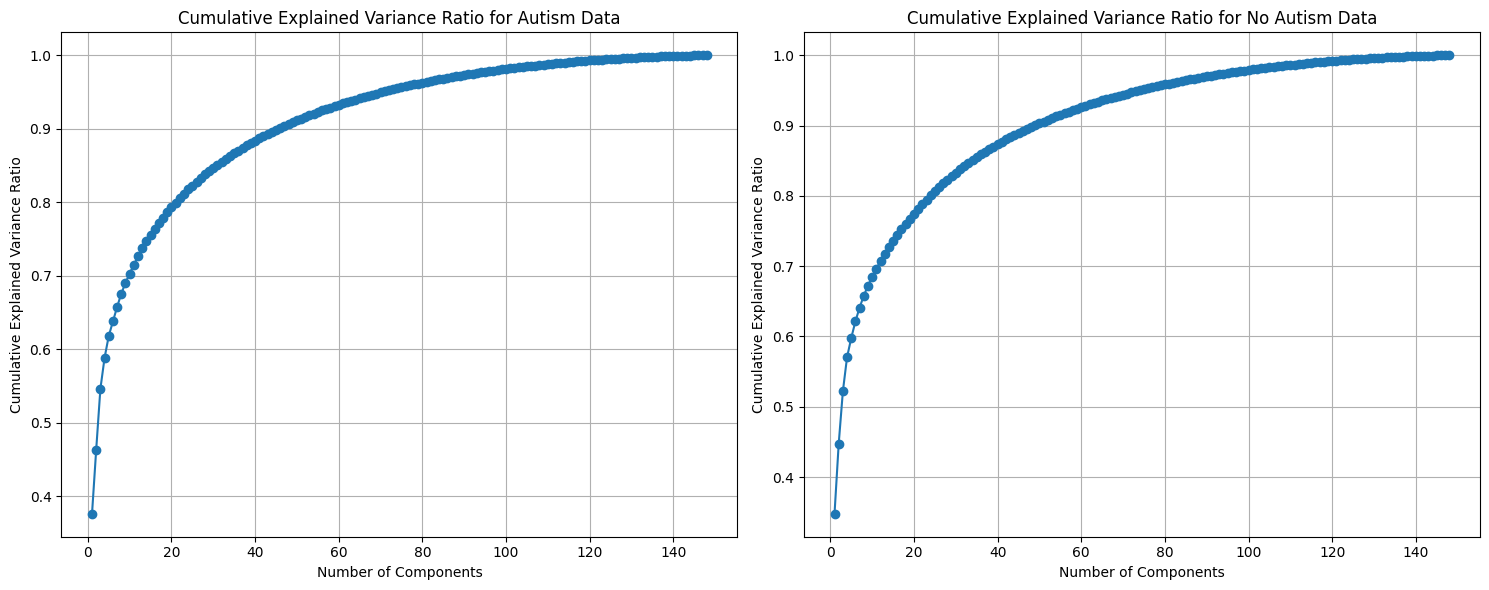

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Extract "data" arrays from data_info_dict_autism
autism_data_arrays = [entry["data"] for entry in data_info_dict_autism.values()]

# Extract "data" arrays from data_info_dict_no_autism
no_autism_data_arrays = [entry["data"] for entry in data_info_dict_no_autism.values()]

# Create a matrix by stacking the arrays for both groups
autism_data_matrix = np.vstack(autism_data_arrays)
no_autism_data_matrix = np.vstack(no_autism_data_arrays)

# Fit PCA for autism data
pca_autism = PCA()
pca_autism.fit(autism_data_matrix)

# Fit PCA for non autism data
pca_no_autism = PCA()
pca_no_autism.fit(no_autism_data_matrix)

# Calculate cumulative explained variance ratio for autism data
cumulative_explained_variance_autism = np.cumsum(pca_autism.explained_variance_ratio_)

# Calculate cumulative explained variance ratio for non autism data
cumulative_explained_variance_no_autism = np.cumsum(pca_no_autism.explained_variance_ratio_)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot cumulative explained variance ratio for autism data
axs[0].plot(range(1, len(cumulative_explained_variance_autism) + 1), cumulative_explained_variance_autism, marker='o')
axs[0].set_xlabel('Number of Components')
axs[0].set_ylabel('Cumulative Explained Variance Ratio')
axs[0].set_title('Cumulative Explained Variance Ratio for Autism Data')
axs[0].grid()

# Plot cumulative explained variance ratio for non autism data
axs[1].plot(range(1, len(cumulative_explained_variance_no_autism) + 1), cumulative_explained_variance_no_autism, marker='o')
axs[1].set_xlabel('Number of Components')
axs[1].set_ylabel('Cumulative Explained Variance Ratio')
axs[1].set_title('Cumulative Explained Variance Ratio for No Autism Data')
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()


We see somewhat and elbow following the 4th component. However, one could also argue in favor of three components, as there is a stark decrease following this component. Let's inspect the option with four components.

Let's zoom in a little.

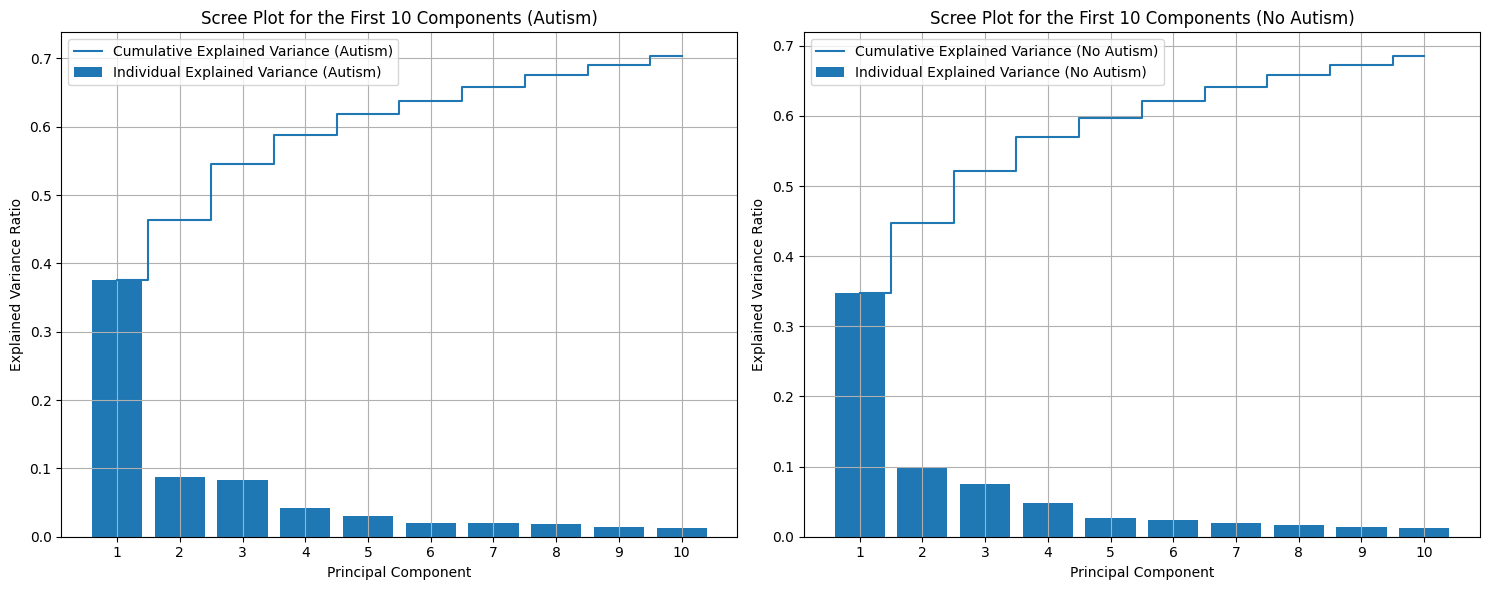

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Extract "data" arrays from data_info_dict_autism
autism_data_arrays = [entry["data"] for entry in data_info_dict_autism.values()]

# Extract "data" arrays from data_info_dict_no_autism
no_autism_data_arrays = [entry["data"] for entry in data_info_dict_no_autism.values()]

# Create a matrix by stacking the arrays for autism and non autism groups
autism_data_matrix = np.vstack(autism_data_arrays)
no_autism_data_matrix = np.vstack(no_autism_data_arrays)

# Fit PCA with the first 10 components for autism data
n_components = 10
pca_autism = PCA(n_components=n_components)
pca_autism.fit(autism_data_matrix)

# Fit PCA with the first 10 components for non autism data
pca_no_autism = PCA(n_components=n_components)
pca_no_autism.fit(no_autism_data_matrix)

# Scree plot for the first 10 components side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Autism data scree plot
explained_variance_autism = pca_autism.explained_variance_ratio_
cumulative_explained_variance_autism = np.cumsum(explained_variance_autism)

axs[0].bar(range(1, n_components + 1), explained_variance_autism, align='center', label='Individual Explained Variance (Autism)')
axs[0].step(range(1, n_components + 1), cumulative_explained_variance_autism, where='mid', label='Cumulative Explained Variance (Autism)')
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Explained Variance Ratio')
axs[0].set_title('Scree Plot for the First 10 Components (Autism)')
axs[0].set_xticks(range(1, n_components + 1))
axs[0].legend()
axs[0].grid()

# No Autism data scree plot
explained_variance_no_autism = pca_no_autism.explained_variance_ratio_
cumulative_explained_variance_no_autism = np.cumsum(explained_variance_no_autism)

axs[1].bar(range(1, n_components + 1), explained_variance_no_autism, align='center', label='Individual Explained Variance (No Autism)')
axs[1].step(range(1, n_components + 1), cumulative_explained_variance_no_autism, where='mid', label='Cumulative Explained Variance (No Autism)')
axs[1].set_xlabel('Principal Component')
axs[1].set_ylabel('Explained Variance Ratio')
axs[1].set_title('Scree Plot for the First 10 Components (No Autism)')
axs[1].set_xticks(range(1, n_components + 1))
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


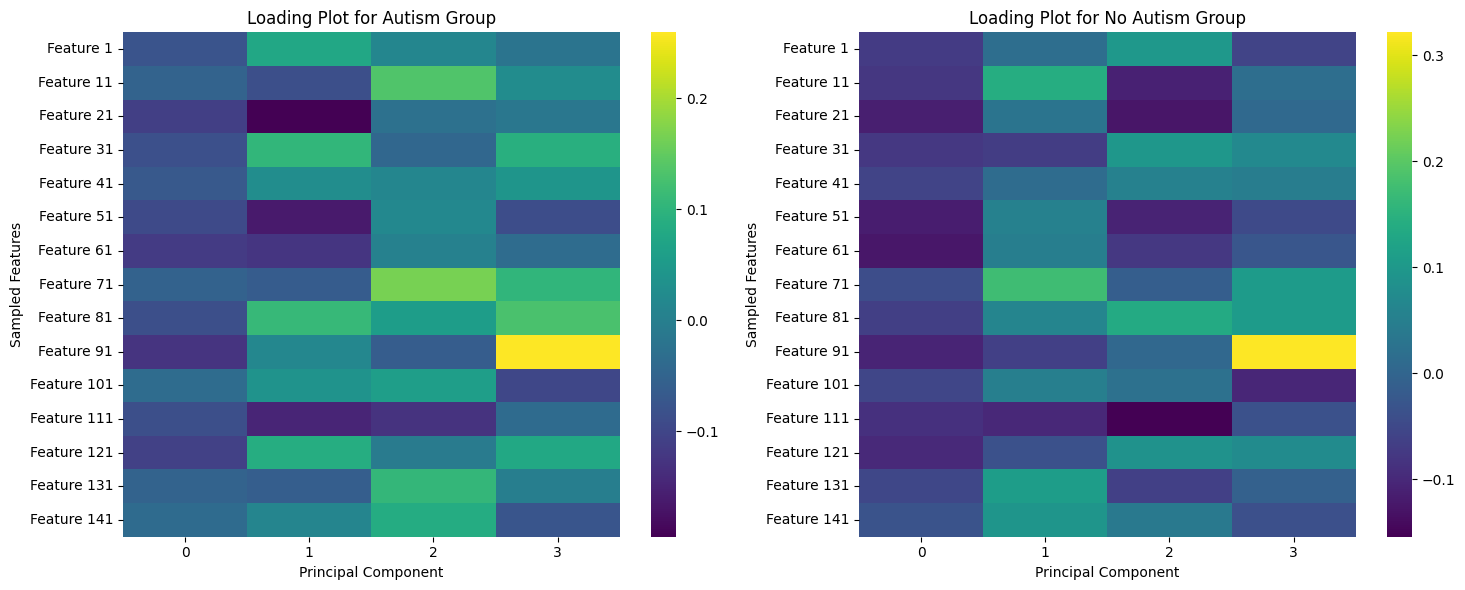

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Extract "data" arrays from dictionaries
autism_data_arrays = [entry["data"] for entry in data_info_dict_autism.values()]
no_autism_data_arrays = [entry["data"] for entry in data_info_dict_no_autism.values()]

# Convert arrays into matrices
autism_data_matrix = np.vstack(autism_data_arrays)
no_autism_data_matrix = np.vstack(no_autism_data_arrays)

# Specify the desired number of features
num_desired_features = 4  # You can adjust this number

# Create PCA instances for both groups
pca_autism = PCA(n_components=num_desired_features)
pca_no_autism = PCA(n_components=num_desired_features)

# Fit and transform "data" arrays for both groups
pca_autism_result = pca_autism.fit_transform(autism_data_matrix)
pca_no_autism_result = pca_no_autism.fit_transform(no_autism_data_matrix)

# Sample a subset of features for plotting (e.g., every 10th feature)
sampled_features_indices = np.arange(0, autism_data_matrix.shape[1], step=10)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Loading plot for autism group
sns.heatmap(pca_autism.components_.T[sampled_features_indices], cmap='viridis', yticklabels=['Feature {}'.format(i+1) for i in sampled_features_indices], ax=axs[0])
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Sampled Features')
axs[0].set_title('Loading Plot for Autism Group')

# Loading plot for no autism group
sns.heatmap(pca_no_autism.components_.T[sampled_features_indices], cmap='viridis', yticklabels=['Feature {}'.format(i+1) for i in sampled_features_indices], ax=axs[1])
axs[1].set_xlabel('Principal Component')
axs[1].set_ylabel('Sampled Features')
axs[1].set_title('Loading Plot for No Autism Group')

# Adjust layout
plt.tight_layout()
plt.show()


It is interesting to see that the second and third component have a different loading pattern.

In [ ]:
#Find the number of components where cumulative explained variance falls under 1
# Find the number of components to explain 80% of the variance
num_components_80_percent_autism = np.argmax(cumulative_explained_variance_autism >= 0.80) + 1
num_components_80_percent_no_autism = np.argmax(cumulative_explained_variance_no_autism >= 0.80) + 1

# Get the eigenvalues of the first 4 components for both groups
eigenvalues_autism = pca_autism.explained_variance_[:4]
eigenvalues_no_autism = pca_no_autism.explained_variance_[:4]

# Print the eigenvalues
print(f"Number of components for Autism Group where cumulative explained variance falls under 1: {num_components_80_percent_autism}")
print("Eigenvalues for Autism Group:")
for i, eigenvalue in enumerate(eigenvalues_autism):
    print(f"Component {i+1}: {eigenvalue:.4f}")


print(f"\nNumber of components for No Autism Group where cumulative explained variance falls under 1: {num_components_80_percent_no_autism}")
print("Eigenvalues for No Autism Group:")
for i, eigenvalue in enumerate(eigenvalues_no_autism):
    print(f"Component {i+1}: {eigenvalue:.4f}")


Number of components for Autism Group where cumulative explained variance falls under 1: 46
Eigenvalues for Autism Group:
Component 1: 11.2743
Component 2: 2.6192
Component 3: 2.4748
Component 4: 1.2665

Number of components for No Autism Group where cumulative explained variance falls under 1: 49
Eigenvalues for No Autism Group:
Component 1: 8.8548
Component 2: 2.5343
Component 3: 1.9057
Component 4: 1.2358


Based on this, the eigenvalues for the 4th component are still above 1 in both groups. According to Kaiser's criterium, one could already choose at least 4. The screeplot suggests 3 or 4 components. The original publication used 2 components, I am going to use 4 components per sample. Here is the reasoning:

I expect the non-linear nature of the model to work better with less dimensions. Introducing an additional classifier and more information later however, will likely benefit from more latent variables.

In particular, the introduction of gender and age may lead to two of the latent variables to be optimized to represent information of this nature. As to not underfit, I am therefore chosing 4 components for each of the autoencoders.

Number of components to explain 80% of the variance: 24


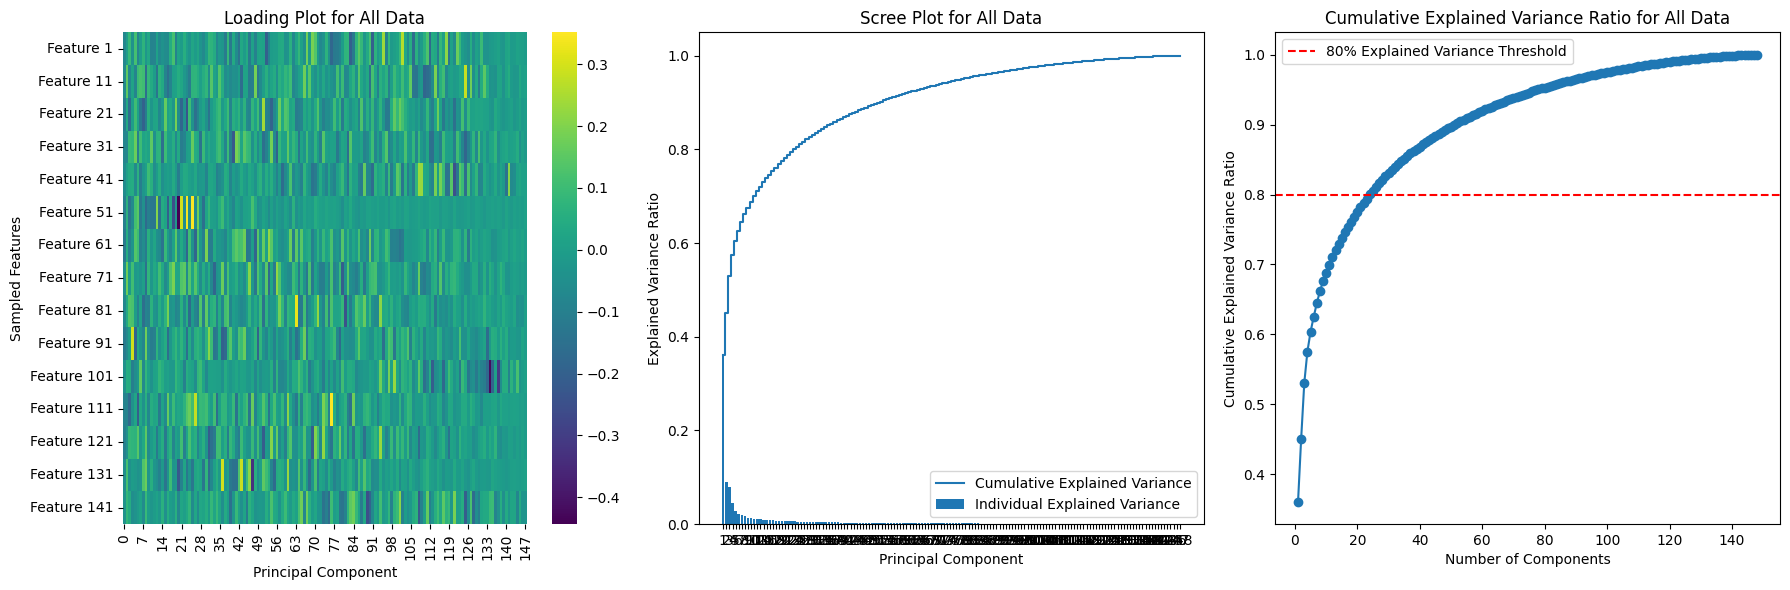

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Extract "data" arrays from dictionaries
autism_data_arrays = [entry["data"] for entry in data_info_dict_autism.values()]
no_autism_data_arrays = [entry["data"] for entry in data_info_dict_no_autism.values()]

# Convert arrays into matrices for both groups
autism_data_matrix = np.vstack(autism_data_arrays)
no_autism_data_matrix = np.vstack(no_autism_data_arrays)

# Concatenate data matrices for both groups
all_data_matrix = np.vstack((autism_data_matrix, no_autism_data_matrix))

# Create PCA instance for the whole dataset
pca_all = PCA()
pca_all.fit(all_data_matrix)

# Calculate cumulative explained variance ratio
cumulative_explained_variance_all = np.cumsum(pca_all.explained_variance_ratio_)

# Find the number of components to explain 80% of the variance
num_components_80_percent_all = np.argmax(cumulative_explained_variance_all >= 0.80) + 1

print(f"Number of components to explain 80% of the variance: {num_components_80_percent_all}")

# Sample a subset of features for loading plots (e.g., every 10th feature)
sampled_features_indices = np.arange(0, all_data_matrix.shape[1], step=10)

# Create subplots for loading plots and scree plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Loading plot for all data
sns.heatmap(pca_all.components_.T[sampled_features_indices], cmap='viridis', yticklabels=['Feature {}'.format(i+1) for i in sampled_features_indices], ax=axs[0])
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Sampled Features')
axs[0].set_title('Loading Plot for All Data')

# Scree plot
explained_variance = pca_all.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
axs[1].bar(range(1, len(explained_variance) + 1), explained_variance, align='center', label='Individual Explained Variance')
axs[1].step(range(1, len(explained_variance) + 1), cumulative_explained_variance, where='mid', label='Cumulative Explained Variance')
axs[1].set_xlabel('Principal Component')
axs[1].set_ylabel('Explained Variance Ratio')
axs[1].set_title('Scree Plot for All Data')
axs[1].set_xticks(range(1, len(explained_variance) + 1))
axs[1].legend()

# Cumulative explained variance plot
axs[2].plot(range(1, len(cumulative_explained_variance_all) + 1), cumulative_explained_variance_all, marker='o')
axs[2].axhline(y=0.8, color='r', linestyle='--', label='80% Explained Variance Threshold')
axs[2].set_xlabel('Number of Components')
axs[2].set_ylabel('Cumulative Explained Variance Ratio')
axs[2].set_title('Cumulative Explained Variance Ratio for All Data')
axs[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()


## Model specifications

In the following I am specifiying the model. I am roughly orienting myself around a paper from Anglinkas, Hartshorne & Anzellotti (2022).

### Defining utility functions

Firstly, I am defining the loss function.
The loss will be computed as the sum of the BCE-Loss, as well as the KL-divergence terms.

* MSE loss: Incoming

* Cross Entropy: Incoming

* Kullback-Leibler divergence (Kullback & Leibler, 1951) This is a measure for the difference between two distributions. I.e. "how much do they diverge" from each other, how much are they different to each other. The introduction of this term into the final loss leads my model to optimize not only if the precited categories are correct and so on, but also how high the difference between the prior distribution and teh latent variables are. The prior distribution in my case is an isotropic gaussian.
  * Why is this desirable? The latent variables and the sampling process should be somewhat controlled. This divergence regulates this.


I have also attempted to regulate that a loss is only completed with the KL divergence from the second encoder if that encoder was used.

In [87]:
def final_loss(MSE, CE, MSE_age, z_mu, z_logvar, s_mu, s_logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: reconstruction loss
    :param z_mu: mean from the latent vector of encoder_z
    :param z_logvar: log variance from the latent vector of encoder_z
    :param s_mu: mean from the latent vector of encoder_s (optional)
    :param s_logvar: log variance from the latent vector of encoder_s (optional)
    """
    mse_loss = MSE
    mse_age = MSE_age
    cross_entropy = CE
    KLD_z = -0.5 * torch.sum(1 + z_logvar - z_mu.pow(2) - z_logvar.exp())
    if cross_entropy is not None or mse_age is not None:
      if s_mu is not None and s_logvar is not None:
          KLD_s = -0.5 * torch.sum(1 + s_logvar - s_mu.pow(2) - s_logvar.exp())
          return mse_loss + KLD_z + KLD_s + cross_entropy + mse_age
      else:
          return mse_loss + KLD_z + cross_entropy + mse_age
    else:
      if s_mu is not None and s_logvar is not None:
          KLD_s = -0.5 * torch.sum(1 + s_logvar - s_mu.pow(2) - s_logvar.exp())
          return mse_loss + KLD_z + KLD_s
      else:
          return mse_loss + KLD_z


Here is the training loop. This model is supposed to achieve multiple things:

* Train the cVAE using the MSE loss.
* Incoming.


In [88]:
def train(model, dataloader, dataset, device, optimizer, criterion, criterion_classifier):
    model.train()
    running_loss_autism = 0.0
    running_loss_no_autism = 0.0
    running_age_loss_autism = 0.0
    running_gender_loss_autism = 0.0
    running_age_loss_no_autism = 0.0
    running_gender_loss_no_autism = 0.0
    counter = 0

    total_batches = len(dataset) // dataloader.batch_size

    for i, ((autism_data, autism_age, autism_gender, autism_diag_group,_,_,_,_,_), (no_autism_data, no_autism_age, no_autism_gender,  no_autism_diag_group,_,_)) in tqdm(enumerate(dataloader), total=total_batches):
        autism_data = autism_data.to(device)
        no_autism_data = no_autism_data.to(device)

        autism_age = autism_age.to(device)
        autism_gender = autism_gender.to(device)

        no_autism_age = no_autism_age.to(device)
        no_autism_gender = no_autism_gender.to(device)

        optimizer.zero_grad()

        # Get the model outputs
        z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, class_autism_age, class_autism_gender, class_no_autism_age, class_no_autism_gender, z, s, z_no_autism = model(autism_data, no_autism_data)

        # Calculate classifier losses for age and gender predictions
        age_loss_autism = criterion(class_autism_age, autism_age.unsqueeze(1))
        gender_loss_autism = criterion_classifier(class_autism_gender, autism_gender.unsqueeze(1).float())

        age_loss_no_autism = criterion(class_no_autism_age, no_autism_age.unsqueeze(1))
        gender_loss_no_autism = criterion_classifier(class_no_autism_gender, no_autism_gender.unsqueeze(1).float())


        # Section for the autism images
        bce_loss_autism = criterion(reconstructed_data_autism, autism_data)
        loss_autism = final_loss(bce_loss_autism,  gender_loss_autism, age_loss_autism, z_mean, z_log_var, s_mean, s_log_var)
        running_loss_autism += loss_autism.item()
        running_age_loss_autism += age_loss_autism.item()
        running_gender_loss_autism += gender_loss_autism.item()

        # Section for the no_autism images
        bce_loss_no_autism = criterion(reconstructed_data_no_autism, no_autism_data)
        s_mean_no_autism, s_log_var_no_autism = None, None
        loss_no_autism = final_loss(bce_loss_no_autism,  gender_loss_no_autism, age_loss_no_autism, z_mean_no_autism, z_log_var_no_autism, s_mean_no_autism, s_log_var_no_autism)
        running_loss_no_autism += loss_no_autism.item()
        running_age_loss_no_autism += age_loss_no_autism.item()
        running_gender_loss_no_autism += gender_loss_no_autism.item()

        # Total loss
        loss_no_autism.backward()
        loss_autism.backward()

        optimizer.step()
        counter += len(autism_data) + len(no_autism_data)

    train_loss_autism = running_loss_autism / counter
    train_loss_no_autism = running_loss_no_autism / counter
    train_age_loss_autism = running_age_loss_autism / counter
    train_gender_loss_autism = running_gender_loss_autism / counter
    train_age_loss_no_autism = running_age_loss_no_autism / counter
    train_gender_loss_no_autism = running_gender_loss_no_autism / counter

    return train_loss_autism, train_loss_no_autism, train_age_loss_autism, train_gender_loss_autism, train_age_loss_no_autism, train_gender_loss_no_autism

And of course the corresponding validation function


In [89]:
def validate(model, dataloader, dataset, device, criterion, criterion_classifier):
    model.eval()  # Set the model to evaluation mode
    running_loss_autism = 0.0
    running_loss_no_autism = 0.0
    running_age_loss_autism = 0.0
    running_gender_loss_autism = 0.0
    running_age_loss_no_autism = 0.0
    running_gender_loss_no_autism = 0.0
    counter = 0

    total_batches = len(dataset) // dataloader.batch_size

    with torch.no_grad():  # Disable gradient calculation during validation
        for i, ((autism_data, autism_age, autism_gender, autism_diag_group,_,_,_,_,_), (no_autism_data, no_autism_age, no_autism_gender, no_autism_diag_group,_,_)) in tqdm(enumerate(dataloader), total=total_batches):
            autism_data = autism_data.to(device)
            no_autism_data = no_autism_data.to(device)

            autism_age = autism_age.to(device)
            autism_gender = autism_gender.to(device)

            no_autism_age = no_autism_age.to(device)
            no_autism_gender = no_autism_gender.to(device)

            # Get the model outputs
            z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, class_autism_age, class_autism_gender, class_no_autism_age, class_no_autism_gender, z, s, z_no_autism = model(autism_data, no_autism_data)

            # Calculate classifier losses for age and gender predictions
            age_loss_autism = criterion(class_autism_age, autism_age.unsqueeze(1))
            gender_loss_autism = criterion_classifier(class_autism_gender, autism_gender.unsqueeze(1).float())

            age_loss_no_autism = criterion(class_no_autism_age, no_autism_age.unsqueeze(1))
            gender_loss_no_autism = criterion_classifier(class_no_autism_gender, no_autism_gender.unsqueeze(1).float())

            # Section for the autism images
            bce_loss_autism = criterion(reconstructed_data_autism, autism_data)
            loss_autism = final_loss(bce_loss_autism, gender_loss_autism, age_loss_autism, z_mean, z_log_var, s_mean, s_log_var)
            running_loss_autism += loss_autism.item()
            running_age_loss_autism += age_loss_autism.item()
            running_gender_loss_autism += gender_loss_autism.item()

            # Section for the no_autism images
            bce_loss_no_autism = criterion(reconstructed_data_no_autism, no_autism_data)
            s_mean_no_autism, s_log_var_no_autism = None, None
            loss_no_autism = final_loss(bce_loss_no_autism, gender_loss_no_autism, age_loss_no_autism, z_mean_no_autism, z_log_var_no_autism, s_mean_no_autism, s_log_var_no_autism)
            running_loss_no_autism += loss_no_autism.item()
            running_age_loss_no_autism += age_loss_no_autism.item()
            running_gender_loss_no_autism += gender_loss_no_autism.item()

            counter += len(autism_data) + len(no_autism_data)

    val_loss_autism = running_loss_autism / counter
    val_loss_no_autism = running_loss_no_autism / counter
    val_age_loss_autism = running_age_loss_autism / counter
    val_gender_loss_autism = running_gender_loss_autism / counter
    val_age_loss_no_autism = running_age_loss_no_autism / counter
    val_gender_loss_no_autism = running_gender_loss_no_autism / counter

    return (
        val_loss_autism, val_loss_no_autism,
        val_age_loss_autism, val_gender_loss_autism,
        val_age_loss_no_autism, val_gender_loss_no_autism
    )


## Model specification
Next I want to define the contrastive variational autoencoder. While doing so, I am defining seperate encoders, to make it easier to later introduce other encoders. I am orienting myself on an cVAE I have written in the past.

As the paper from Aglinskas, Hartshorne and Anzellotti (2022) I mentioned, the network will have only a few layers.

A few things I will probably have to change - I do not know how many channels the data will end up having. therefore I am using one, assuming it only has one.

In [98]:
class EncoderNS(nn.Module):
    def __init__(self, input_dimension, latent_dim):
        super(EncoderNS, self).__init__()
        self.linear1 = nn.Linear(input_dimension, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, latent_dim)
        self.ns_fc_mean = nn.Linear(latent_dim, latent_dim)
        self.ns_fc_log_var = nn.Linear(latent_dim, latent_dim)

    def forward(self, x, batch_size):
        h = F.relu(self.linear1(x))
        h = F.relu(self.linear2(h))
        h = F.relu(self.linear3(h))
        ns_mean = self.ns_fc_mean(h)
        ns_log_var = self.ns_fc_log_var(h)
        return ns_mean, ns_log_var


class EncoderS(nn.Module):
    def __init__(self, input_dimension, latent_dim):
        super(EncoderS, self).__init__()
        self.linear1 = nn.Linear(input_dimension, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, latent_dim)
        self.s_fc_mean = nn.Linear(latent_dim, latent_dim)
        self.s_fc_log_var = nn.Linear(latent_dim, latent_dim)

    def forward(self, x, batch_size):
        h = F.relu(self.linear1(x))
        h = F.relu(self.linear2(h))
        h = F.relu(self.linear3(h))
        s_mean = self.s_fc_mean(h)
        s_log_var = self.s_fc_log_var(h)
        return s_mean, s_log_var

class Decoder(nn.Module):
    def __init__(self, input_dimension, latent_dim):
        super(Decoder, self).__init__()
        self.linear_decoder_1 = nn.Linear(latent_dim*2, 32)
        self.linear_decoder_2 = nn.Linear(32,64)
        self.linear_decoder_3 = nn.Linear(64, input_dimension)

    def forward(self, zs, batch_size):
        h_output = F.relu(self.linear_decoder_1(zs))
        h_output = F.relu(self.linear_decoder_2(h_output))
        output = F.relu(self.linear_decoder_3(h_output))
        return output

class Classifier(nn.Module):
    def __init__(self, latent_dim):
        super(Classifier, self).__init__()
        self.fc_first_age = nn.Linear(latent_dim *2, latent_dim // 2)
        self.fc_first_gender = nn.Linear(latent_dim *2, latent_dim // 2)
        self.fc_age = nn.Linear(latent_dim // 2, 1)
        self.fc_gender = nn.Linear(latent_dim // 2, 1)

    def forward(self, z):
        x_age = self.fc_first_age(z)
        x_gender = self.fc_first_gender(z)
        age_prediction = self.fc_age(x_age)
        gender_prediction = torch.sigmoid(self.fc_gender(x_gender)) # Apply sigmoid activation for binary gender prediction
        return age_prediction, gender_prediction

class cVAE_classifier(nn.Module):
    def __init__(self, input_dimension, latent_dim):
        super(cVAE_classifier, self).__init__()
        self.encoder_z = EncoderNS(input_dimension, latent_dim)
        self.encoder_s = EncoderS(input_dimension, latent_dim)
        self.decoder = Decoder(input_dimension, latent_dim)
        self.classifier = Classifier(latent_dim)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mean + epsilon * std

    def forward(self, autism, no_autism):
        batch_size = autism.size(0)
        z_mean, z_log_var = self.encoder_z(autism, batch_size)
        z = self.reparameterize(z_mean, z_log_var)
        s_mean, s_log_var = self.encoder_s(autism, batch_size)
        s = self.reparameterize(s_mean, s_log_var)
        zs = torch.cat([z, s], dim=1)

        reconstructed_data_autism = self.decoder(zs, batch_size)

        z_mean_no_autism, z_log_var_no_autism = self.encoder_z(no_autism, batch_size)
        z_no_autism = self.reparameterize(z_mean_no_autism, z_log_var_no_autism)
        z_empty = torch.zeros(z_no_autism.shape)
        model_device = z_no_autism.device
        z_empty = z_empty.to(model_device)
        z_no_autism_0 = torch.cat([z_no_autism, z_empty], dim=1)


        reconstructed_data_no_autism = self.decoder(z_no_autism_0, batch_size)

        class_autism_age, class_autism_gender = self.classifier(zs)  # Assuming z is the latent variable after concatenating s and z
        class_no_autism_age, class_no_autism_gender = self.classifier(z_no_autism_0)  # Using the version with 0s to have equal lengths of the latent vectors.

        return z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, class_autism_age, class_autism_gender, class_no_autism_age, class_no_autism_gender, z, s, z_no_autism

### Other models that will be tested later.

Firstly, here is a model, as well as the relevant training and validaiton functions, for a mdoel without a classifier.

In [91]:
class cVAE(nn.Module):
    def __init__(self, input_dimension, latent_dim):
        super(cVAE, self).__init__()
        self.encoder_z = EncoderNS(input_dimension, latent_dim)
        self.encoder_s = EncoderS(input_dimension, latent_dim)
        self.decoder = Decoder(input_dimension, latent_dim)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mean + epsilon * std

    def forward(self, autism, no_autism):
        batch_size = autism.size(0)
        z_mean, z_log_var = self.encoder_z(autism, batch_size)
        z = self.reparameterize(z_mean, z_log_var)
        s_mean, s_log_var = self.encoder_s(autism, batch_size)
        s = self.reparameterize(s_mean, s_log_var)
        zs = torch.cat([z, s], dim=1)

        reconstructed_data_autism = self.decoder(zs, batch_size)

        z_mean_no_autism, z_log_var_no_autism = self.encoder_z(no_autism, batch_size)
        z_no_autism = self.reparameterize(z_mean_no_autism, z_log_var_no_autism)
        z_empty = torch.zeros(z_no_autism.shape)
        model_device = z_no_autism.device
        z_empty = z_empty.to(model_device)
        z_no_autism_0 = torch.cat([z_no_autism, z_empty], dim=1)

        reconstructed_data_no_autism = self.decoder(z_no_autism_0, batch_size)

        return z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, z, s, z_no_autism

def train_no_classifier(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss_autism = 0.0
    running_loss_no_autism = 0.0
    counter = 0

    total_batches = len(dataset) // dataloader.batch_size

    for i, ((autism_data, _, _, _,_,_,_,_,_), (no_autism_data, _, _, _,_,_)) in tqdm(enumerate(dataloader), total=total_batches):
        autism_data = autism_data.to(device)
        no_autism_data = no_autism_data.to(device)

        optimizer.zero_grad()

        # Get the model outputs
        z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, z, s, z_no_autism = model(autism_data, no_autism_data)

        # Section for the autism images
        bce_loss_autism = criterion(reconstructed_data_autism, autism_data)
        loss_autism = final_loss(bce_loss_autism , None, None, z_mean, z_log_var, s_mean, s_log_var)
        running_loss_autism += loss_autism.item()

        # Section for the no_autism images
        bce_loss_no_autism = criterion(reconstructed_data_no_autism, no_autism_data)
        s_mean_no_autism, s_log_var_no_autism = None, None
        loss_no_autism = final_loss(bce_loss_no_autism  , None, None , z_mean_no_autism, z_log_var_no_autism, s_mean_no_autism, s_log_var_no_autism)
        running_loss_no_autism += loss_no_autism.item()

        # Total loss
        loss_no_autism.backward()
        loss_autism.backward()

        optimizer.step()
        counter += len(autism_data) + len(no_autism_data)

    train_loss_autism = running_loss_autism / counter
    train_loss_no_autism = running_loss_no_autism / counter

    return train_loss_autism, train_loss_no_autism



def validate_no_classifier(model, dataloader, dataset, device, criterion):
    model.eval()  # Set the model to evaluation mode
    running_loss_autism = 0.0
    running_loss_no_autism = 0.0
    counter = 0

    total_batches = len(dataset) // dataloader.batch_size

    with torch.no_grad():  # Disable gradient calculation during validation
        for i, ((autism_data, _, _, _,_,_,_,_,_), (no_autism_data, _, _, _,_,_)) in tqdm(enumerate(dataloader), total=total_batches):
            autism_data = autism_data.to(device)
            no_autism_data = no_autism_data.to(device)

            # Get the model outputs
            z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, z, s, z_no_autism = model(autism_data, no_autism_data)

            # Section for the autism images
            bce_loss_autism = criterion(reconstructed_data_autism, autism_data)
            loss_autism = final_loss(bce_loss_autism  , None, None , z_mean, z_log_var, s_mean, s_log_var)
            running_loss_autism += loss_autism.item()

            # Section for the no_autism images
            bce_loss_no_autism = criterion(reconstructed_data_no_autism, no_autism_data)
            s_mean_no_autism, s_log_var_no_autism = None, None
            loss_no_autism = final_loss(bce_loss_no_autism  , None, None , z_mean_no_autism, z_log_var_no_autism, s_mean_no_autism, s_log_var_no_autism)
            running_loss_no_autism += loss_no_autism.item()

            counter += len(autism_data) + len(no_autism_data)

    val_loss_autism = running_loss_autism / counter
    val_loss_no_autism = running_loss_no_autism / counter

    return val_loss_autism, val_loss_no_autism



## Training the model

In this section, I am training the various models

Here is a loop that is supposed to help me find the optimal learning rate.

Training with learning rate: 0.001
Epoch 1 of 100


4it [00:00, 65.86it/s]               
3it [00:00, 109.19it/s]              


Train Loss Autism: 4.0893, Train Loss Non-Autism: 4.1675, Train Age Loss Autism: 3.8195, Train Gender Loss Autism: 0.0059, Train Age Loss Non-Autism: 3.9816, Train Gender Loss Non-Autism: 0.0059
Epoch 2 of 100


4it [00:00, 65.18it/s]               
3it [00:00, 106.21it/s]              


Train Loss Autism: 4.1089, Train Loss Non-Autism: 3.3483, Train Age Loss Autism: 3.8566, Train Gender Loss Autism: 0.0058, Train Age Loss Non-Autism: 3.1659, Train Gender Loss Non-Autism: 0.0058
Epoch 3 of 100


4it [00:00, 60.03it/s]               
3it [00:00, 111.54it/s]              


Train Loss Autism: 3.9945, Train Loss Non-Autism: 3.4636, Train Age Loss Autism: 3.7548, Train Gender Loss Autism: 0.0058, Train Age Loss Non-Autism: 3.2858, Train Gender Loss Non-Autism: 0.0059
Epoch 4 of 100


4it [00:00, 56.51it/s]               
3it [00:00, 111.11it/s]              


Train Loss Autism: 3.9247, Train Loss Non-Autism: 3.3543, Train Age Loss Autism: 3.6910, Train Gender Loss Autism: 0.0058, Train Age Loss Non-Autism: 3.1813, Train Gender Loss Non-Autism: 0.0059
Epoch 5 of 100


4it [00:00, 56.90it/s]               
3it [00:00, 114.93it/s]              


Train Loss Autism: 3.8875, Train Loss Non-Autism: 3.2937, Train Age Loss Autism: 3.6660, Train Gender Loss Autism: 0.0058, Train Age Loss Non-Autism: 3.1249, Train Gender Loss Non-Autism: 0.0059
Epoch 6 of 100


4it [00:00, 57.26it/s]               
3it [00:00, 107.88it/s]              


Train Loss Autism: 4.0916, Train Loss Non-Autism: 3.4458, Train Age Loss Autism: 3.8810, Train Gender Loss Autism: 0.0059, Train Age Loss Non-Autism: 3.2835, Train Gender Loss Non-Autism: 0.0058
Epoch 7 of 100


4it [00:00, 63.73it/s]               
3it [00:00, 85.96it/s]               


Train Loss Autism: 4.0197, Train Loss Non-Autism: 3.7642, Train Age Loss Autism: 3.8183, Train Gender Loss Autism: 0.0056, Train Age Loss Non-Autism: 3.6075, Train Gender Loss Non-Autism: 0.0058
Epoch 8 of 100


4it [00:00, 63.03it/s]               
3it [00:00, 95.68it/s]               


Train Loss Autism: 3.8452, Train Loss Non-Autism: 3.4846, Train Age Loss Autism: 3.6532, Train Gender Loss Autism: 0.0059, Train Age Loss Non-Autism: 3.3338, Train Gender Loss Non-Autism: 0.0058
Epoch 9 of 100


4it [00:00, 62.99it/s]               
3it [00:00, 110.79it/s]              


Train Loss Autism: 4.0438, Train Loss Non-Autism: 3.6119, Train Age Loss Autism: 3.8617, Train Gender Loss Autism: 0.0056, Train Age Loss Non-Autism: 3.4674, Train Gender Loss Non-Autism: 0.0057
Epoch 10 of 100


4it [00:00, 69.60it/s]               
3it [00:00, 91.00it/s]               


Train Loss Autism: 3.7567, Train Loss Non-Autism: 3.6947, Train Age Loss Autism: 3.5817, Train Gender Loss Autism: 0.0058, Train Age Loss Non-Autism: 3.5555, Train Gender Loss Non-Autism: 0.0059
Epoch 11 of 100


4it [00:00, 67.33it/s]               
3it [00:00, 106.52it/s]              


Train Loss Autism: 4.2006, Train Loss Non-Autism: 3.3460, Train Age Loss Autism: 4.0336, Train Gender Loss Autism: 0.0056, Train Age Loss Non-Autism: 3.2122, Train Gender Loss Non-Autism: 0.0057
Epoch 12 of 100


4it [00:00, 68.61it/s]               
3it [00:00, 105.54it/s]              


Train Loss Autism: 4.0515, Train Loss Non-Autism: 3.4846, Train Age Loss Autism: 3.8903, Train Gender Loss Autism: 0.0056, Train Age Loss Non-Autism: 3.3555, Train Gender Loss Non-Autism: 0.0058
Epoch 13 of 100


4it [00:00, 50.65it/s]               
3it [00:00, 105.28it/s]              


Train Loss Autism: 3.7433, Train Loss Non-Autism: 3.6834, Train Age Loss Autism: 3.5873, Train Gender Loss Autism: 0.0055, Train Age Loss Non-Autism: 3.5584, Train Gender Loss Non-Autism: 0.0058
Epoch 14 of 100


4it [00:00, 56.35it/s]               
3it [00:00, 116.44it/s]              


Train Loss Autism: 3.5727, Train Loss Non-Autism: 3.1686, Train Age Loss Autism: 3.4222, Train Gender Loss Autism: 0.0057, Train Age Loss Non-Autism: 3.0462, Train Gender Loss Non-Autism: 0.0058
Epoch 15 of 100


4it [00:00, 62.95it/s]               
3it [00:00, 110.53it/s]              


Train Loss Autism: 3.7657, Train Loss Non-Autism: 3.4908, Train Age Loss Autism: 3.6203, Train Gender Loss Autism: 0.0055, Train Age Loss Non-Autism: 3.3718, Train Gender Loss Non-Autism: 0.0058
Epoch 16 of 100


4it [00:00, 59.16it/s]               
3it [00:00, 107.87it/s]              


Train Loss Autism: 4.1166, Train Loss Non-Autism: 3.3750, Train Age Loss Autism: 3.9755, Train Gender Loss Autism: 0.0055, Train Age Loss Non-Autism: 3.2585, Train Gender Loss Non-Autism: 0.0057
Epoch 17 of 100


4it [00:00, 63.89it/s]               
3it [00:00, 96.72it/s]               


Train Loss Autism: 3.8653, Train Loss Non-Autism: 3.5945, Train Age Loss Autism: 3.7293, Train Gender Loss Autism: 0.0055, Train Age Loss Non-Autism: 3.4805, Train Gender Loss Non-Autism: 0.0058
Epoch 18 of 100


4it [00:00, 69.54it/s]               
3it [00:00, 88.47it/s]               


Train Loss Autism: 4.0793, Train Loss Non-Autism: 3.3693, Train Age Loss Autism: 3.9476, Train Gender Loss Autism: 0.0055, Train Age Loss Non-Autism: 3.2576, Train Gender Loss Non-Autism: 0.0057
Epoch 19 of 100


4it [00:00, 64.34it/s]               
3it [00:00, 88.59it/s]               


Train Loss Autism: 3.6918, Train Loss Non-Autism: 3.2802, Train Age Loss Autism: 3.5634, Train Gender Loss Autism: 0.0056, Train Age Loss Non-Autism: 3.1705, Train Gender Loss Non-Autism: 0.0058
Epoch 20 of 100


4it [00:00, 63.92it/s]               
3it [00:00, 90.70it/s]               


Train Loss Autism: 4.0723, Train Loss Non-Autism: 3.4030, Train Age Loss Autism: 3.9477, Train Gender Loss Autism: 0.0054, Train Age Loss Non-Autism: 3.2960, Train Gender Loss Non-Autism: 0.0057
Epoch 21 of 100


4it [00:00, 64.50it/s]               
3it [00:00, 109.95it/s]              


Train Loss Autism: 3.6893, Train Loss Non-Autism: 3.2620, Train Age Loss Autism: 3.5682, Train Gender Loss Autism: 0.0056, Train Age Loss Non-Autism: 3.1570, Train Gender Loss Non-Autism: 0.0057
Epoch 22 of 100


4it [00:00, 49.08it/s]               
3it [00:00, 89.20it/s]               


Train Loss Autism: 3.8146, Train Loss Non-Autism: 3.6250, Train Age Loss Autism: 3.6966, Train Gender Loss Autism: 0.0055, Train Age Loss Non-Autism: 3.5225, Train Gender Loss Non-Autism: 0.0056
Epoch 23 of 100


4it [00:00, 68.80it/s]               
3it [00:00, 112.30it/s]              


Train Loss Autism: 3.7038, Train Loss Non-Autism: 3.2945, Train Age Loss Autism: 3.5888, Train Gender Loss Autism: 0.0055, Train Age Loss Non-Autism: 3.1937, Train Gender Loss Non-Autism: 0.0058
Epoch 24 of 100


4it [00:00, 64.87it/s]               
3it [00:00, 107.80it/s]              


Train Loss Autism: 3.7091, Train Loss Non-Autism: 3.3593, Train Age Loss Autism: 3.5970, Train Gender Loss Autism: 0.0054, Train Age Loss Non-Autism: 3.2609, Train Gender Loss Non-Autism: 0.0056
Epoch 25 of 100


4it [00:00, 63.64it/s]               
3it [00:00, 108.44it/s]              


Train Loss Autism: 3.6645, Train Loss Non-Autism: 3.2947, Train Age Loss Autism: 3.5551, Train Gender Loss Autism: 0.0055, Train Age Loss Non-Autism: 3.1978, Train Gender Loss Non-Autism: 0.0058
Epoch 26 of 100


4it [00:00, 64.31it/s]               
3it [00:00, 107.21it/s]              


Train Loss Autism: 4.2795, Train Loss Non-Autism: 3.5410, Train Age Loss Autism: 4.1734, Train Gender Loss Autism: 0.0054, Train Age Loss Non-Autism: 3.4464, Train Gender Loss Non-Autism: 0.0055
Epoch 27 of 100


4it [00:00, 58.44it/s]               
3it [00:00, 113.43it/s]              


Train Loss Autism: 3.9495, Train Loss Non-Autism: 3.2370, Train Age Loss Autism: 3.8457, Train Gender Loss Autism: 0.0053, Train Age Loss Non-Autism: 3.1442, Train Gender Loss Non-Autism: 0.0056
Epoch 28 of 100


4it [00:00, 65.03it/s]               
3it [00:00, 109.30it/s]              


Train Loss Autism: 3.7525, Train Loss Non-Autism: 3.4217, Train Age Loss Autism: 3.6515, Train Gender Loss Autism: 0.0054, Train Age Loss Non-Autism: 3.3308, Train Gender Loss Non-Autism: 0.0055
Epoch 29 of 100


4it [00:00, 65.12it/s]               
3it [00:00, 118.10it/s]              


Train Loss Autism: 3.9204, Train Loss Non-Autism: 3.1827, Train Age Loss Autism: 3.8217, Train Gender Loss Autism: 0.0053, Train Age Loss Non-Autism: 3.0936, Train Gender Loss Non-Autism: 0.0055
Epoch 30 of 100


4it [00:00, 57.85it/s]               
3it [00:00, 104.58it/s]              


Train Loss Autism: 4.0535, Train Loss Non-Autism: 3.2516, Train Age Loss Autism: 3.9565, Train Gender Loss Autism: 0.0055, Train Age Loss Non-Autism: 3.1642, Train Gender Loss Non-Autism: 0.0055
Epoch 31 of 100


4it [00:00, 56.78it/s]               
3it [00:00, 117.35it/s]              


Train Loss Autism: 3.5581, Train Loss Non-Autism: 3.4248, Train Age Loss Autism: 3.4636, Train Gender Loss Autism: 0.0054, Train Age Loss Non-Autism: 3.3392, Train Gender Loss Non-Autism: 0.0055
Epoch 32 of 100


4it [00:00, 61.28it/s]               
3it [00:00, 90.31it/s]               


Train Loss Autism: 3.7729, Train Loss Non-Autism: 3.1511, Train Age Loss Autism: 3.6803, Train Gender Loss Autism: 0.0054, Train Age Loss Non-Autism: 3.0670, Train Gender Loss Non-Autism: 0.0056
Epoch 33 of 100


4it [00:00, 63.31it/s]               
3it [00:00, 98.64it/s]               


Train Loss Autism: 3.7124, Train Loss Non-Autism: 3.2531, Train Age Loss Autism: 3.6215, Train Gender Loss Autism: 0.0054, Train Age Loss Non-Autism: 3.1708, Train Gender Loss Non-Autism: 0.0054
Epoch 34 of 100


4it [00:00, 67.86it/s]               
3it [00:00, 88.13it/s]               


Train Loss Autism: 3.5022, Train Loss Non-Autism: 3.2639, Train Age Loss Autism: 3.4135, Train Gender Loss Autism: 0.0053, Train Age Loss Non-Autism: 3.1832, Train Gender Loss Non-Autism: 0.0056
Epoch 35 of 100


4it [00:00, 62.18it/s]               
3it [00:00, 103.26it/s]              


Train Loss Autism: 3.6656, Train Loss Non-Autism: 3.1569, Train Age Loss Autism: 3.5795, Train Gender Loss Autism: 0.0052, Train Age Loss Non-Autism: 3.0775, Train Gender Loss Non-Autism: 0.0055
Epoch 36 of 100


4it [00:00, 68.28it/s]               
3it [00:00, 115.74it/s]              


Train Loss Autism: 3.9577, Train Loss Non-Autism: 3.3943, Train Age Loss Autism: 3.8730, Train Gender Loss Autism: 0.0052, Train Age Loss Non-Autism: 3.3166, Train Gender Loss Non-Autism: 0.0053
Epoch 37 of 100


4it [00:00, 58.96it/s]               
3it [00:00, 117.20it/s]              


Train Loss Autism: 3.6831, Train Loss Non-Autism: 3.5520, Train Age Loss Autism: 3.6000, Train Gender Loss Autism: 0.0053, Train Age Loss Non-Autism: 3.4756, Train Gender Loss Non-Autism: 0.0056
Epoch 38 of 100


4it [00:00, 65.90it/s]               
3it [00:00, 109.24it/s]              


Train Loss Autism: 3.5986, Train Loss Non-Autism: 3.1339, Train Age Loss Autism: 3.5169, Train Gender Loss Autism: 0.0051, Train Age Loss Non-Autism: 3.0592, Train Gender Loss Non-Autism: 0.0054
Epoch 39 of 100


4it [00:00, 62.29it/s]               
3it [00:00, 98.23it/s]               


Train Loss Autism: 3.8757, Train Loss Non-Autism: 3.1855, Train Age Loss Autism: 3.7962, Train Gender Loss Autism: 0.0052, Train Age Loss Non-Autism: 3.1119, Train Gender Loss Non-Autism: 0.0057
Epoch 40 of 100


4it [00:00, 54.52it/s]               
3it [00:00, 96.67it/s]               


Train Loss Autism: 3.8486, Train Loss Non-Autism: 3.5563, Train Age Loss Autism: 3.7700, Train Gender Loss Autism: 0.0051, Train Age Loss Non-Autism: 3.4842, Train Gender Loss Non-Autism: 0.0054
Epoch 41 of 100


4it [00:00, 64.06it/s]               
3it [00:00, 95.33it/s]               


Train Loss Autism: 4.0615, Train Loss Non-Autism: 3.1978, Train Age Loss Autism: 3.9845, Train Gender Loss Autism: 0.0054, Train Age Loss Non-Autism: 3.1268, Train Gender Loss Non-Autism: 0.0054
Epoch 42 of 100


4it [00:00, 61.76it/s]               
3it [00:00, 122.10it/s]              


Train Loss Autism: 3.9661, Train Loss Non-Autism: 3.2084, Train Age Loss Autism: 3.8910, Train Gender Loss Autism: 0.0049, Train Age Loss Non-Autism: 3.1390, Train Gender Loss Non-Autism: 0.0053
Epoch 43 of 100


4it [00:00, 66.55it/s]               
3it [00:00, 100.18it/s]              


Train Loss Autism: 3.7110, Train Loss Non-Autism: 3.0634, Train Age Loss Autism: 3.6362, Train Gender Loss Autism: 0.0053, Train Age Loss Non-Autism: 2.9951, Train Gender Loss Non-Autism: 0.0054
Epoch 44 of 100


4it [00:00, 66.46it/s]               
3it [00:00, 97.70it/s]               


Train Loss Autism: 3.7046, Train Loss Non-Autism: 3.4040, Train Age Loss Autism: 3.6315, Train Gender Loss Autism: 0.0052, Train Age Loss Non-Autism: 3.3368, Train Gender Loss Non-Autism: 0.0055
Epoch 45 of 100


4it [00:00, 64.53it/s]               
3it [00:00, 103.62it/s]              


Train Loss Autism: 3.5919, Train Loss Non-Autism: 3.3458, Train Age Loss Autism: 3.5198, Train Gender Loss Autism: 0.0050, Train Age Loss Non-Autism: 3.2800, Train Gender Loss Non-Autism: 0.0052
Epoch 46 of 100


4it [00:00, 64.01it/s]               
3it [00:00, 108.17it/s]              


Train Loss Autism: 3.7701, Train Loss Non-Autism: 3.1608, Train Age Loss Autism: 3.6993, Train Gender Loss Autism: 0.0051, Train Age Loss Non-Autism: 3.0963, Train Gender Loss Non-Autism: 0.0051
Epoch 47 of 100


4it [00:00, 57.60it/s]               
3it [00:00, 115.48it/s]              


Train Loss Autism: 3.9669, Train Loss Non-Autism: 3.1324, Train Age Loss Autism: 3.8970, Train Gender Loss Autism: 0.0050, Train Age Loss Non-Autism: 3.0682, Train Gender Loss Non-Autism: 0.0059
Epoch 48 of 100


4it [00:00, 56.82it/s]               
3it [00:00, 91.69it/s]               


Train Loss Autism: 3.6110, Train Loss Non-Autism: 3.5141, Train Age Loss Autism: 3.5430, Train Gender Loss Autism: 0.0049, Train Age Loss Non-Autism: 3.4518, Train Gender Loss Non-Autism: 0.0052
Epoch 49 of 100


4it [00:00, 51.24it/s]               
3it [00:00, 107.91it/s]              


Train Loss Autism: 3.6389, Train Loss Non-Autism: 3.4610, Train Age Loss Autism: 3.5711, Train Gender Loss Autism: 0.0050, Train Age Loss Non-Autism: 3.3996, Train Gender Loss Non-Autism: 0.0053
Epoch 50 of 100


4it [00:00, 64.48it/s]               
3it [00:00, 82.95it/s]               


Train Loss Autism: 3.8069, Train Loss Non-Autism: 3.4489, Train Age Loss Autism: 3.7399, Train Gender Loss Autism: 0.0052, Train Age Loss Non-Autism: 3.3882, Train Gender Loss Non-Autism: 0.0053
Epoch 51 of 100


4it [00:00, 57.40it/s]               
3it [00:00, 109.41it/s]              


Train Loss Autism: 3.4848, Train Loss Non-Autism: 3.2226, Train Age Loss Autism: 3.4181, Train Gender Loss Autism: 0.0052, Train Age Loss Non-Autism: 3.1631, Train Gender Loss Non-Autism: 0.0053
Epoch 52 of 100


4it [00:00, 59.19it/s]               
3it [00:00, 116.90it/s]              


Train Loss Autism: 3.7478, Train Loss Non-Autism: 3.1183, Train Age Loss Autism: 3.6833, Train Gender Loss Autism: 0.0048, Train Age Loss Non-Autism: 3.0598, Train Gender Loss Non-Autism: 0.0053
Epoch 53 of 100


4it [00:00, 66.54it/s]               
3it [00:00, 87.37it/s]               


Train Loss Autism: 3.4653, Train Loss Non-Autism: 3.3551, Train Age Loss Autism: 3.4004, Train Gender Loss Autism: 0.0050, Train Age Loss Non-Autism: 3.2974, Train Gender Loss Non-Autism: 0.0053
Epoch 54 of 100


4it [00:00, 62.26it/s]               
3it [00:00, 116.63it/s]              


Train Loss Autism: 3.6221, Train Loss Non-Autism: 3.2894, Train Age Loss Autism: 3.5580, Train Gender Loss Autism: 0.0051, Train Age Loss Non-Autism: 3.2325, Train Gender Loss Non-Autism: 0.0053
Epoch 55 of 100


4it [00:00, 63.04it/s]               
3it [00:00, 95.39it/s]               


Train Loss Autism: 3.6176, Train Loss Non-Autism: 3.5034, Train Age Loss Autism: 3.5548, Train Gender Loss Autism: 0.0049, Train Age Loss Non-Autism: 3.4475, Train Gender Loss Non-Autism: 0.0051
Epoch 56 of 100


4it [00:00, 57.62it/s]               
3it [00:00, 98.88it/s]               


Train Loss Autism: 3.6699, Train Loss Non-Autism: 3.3451, Train Age Loss Autism: 3.6074, Train Gender Loss Autism: 0.0047, Train Age Loss Non-Autism: 3.2900, Train Gender Loss Non-Autism: 0.0052
Epoch 57 of 100


4it [00:00, 58.48it/s]               
3it [00:00, 105.62it/s]              


Train Loss Autism: 3.3839, Train Loss Non-Autism: 3.6204, Train Age Loss Autism: 3.3220, Train Gender Loss Autism: 0.0048, Train Age Loss Non-Autism: 3.5660, Train Gender Loss Non-Autism: 0.0051
Epoch 58 of 100


4it [00:00, 57.10it/s]               
3it [00:00, 110.39it/s]              


Train Loss Autism: 3.8814, Train Loss Non-Autism: 3.2411, Train Age Loss Autism: 3.8199, Train Gender Loss Autism: 0.0049, Train Age Loss Non-Autism: 3.1869, Train Gender Loss Non-Autism: 0.0056
Epoch 59 of 100


4it [00:00, 58.49it/s]               
3it [00:00, 93.16it/s]               


Train Loss Autism: 3.9333, Train Loss Non-Autism: 3.2642, Train Age Loss Autism: 3.8726, Train Gender Loss Autism: 0.0049, Train Age Loss Non-Autism: 3.2112, Train Gender Loss Non-Autism: 0.0051
Epoch 60 of 100


4it [00:00, 66.64it/s]               
3it [00:00, 107.93it/s]              


Train Loss Autism: 3.7696, Train Loss Non-Autism: 3.2148, Train Age Loss Autism: 3.7083, Train Gender Loss Autism: 0.0049, Train Age Loss Non-Autism: 3.1622, Train Gender Loss Non-Autism: 0.0053
Epoch 61 of 100


4it [00:00, 59.31it/s]               
3it [00:00, 107.53it/s]              


Train Loss Autism: 3.4931, Train Loss Non-Autism: 3.4246, Train Age Loss Autism: 3.4330, Train Gender Loss Autism: 0.0049, Train Age Loss Non-Autism: 3.3728, Train Gender Loss Non-Autism: 0.0051
Epoch 62 of 100


4it [00:00, 62.79it/s]               
3it [00:00, 101.56it/s]              


Train Loss Autism: 3.4641, Train Loss Non-Autism: 3.2024, Train Age Loss Autism: 3.4040, Train Gender Loss Autism: 0.0047, Train Age Loss Non-Autism: 3.1512, Train Gender Loss Non-Autism: 0.0051
Epoch 63 of 100


4it [00:00, 60.08it/s]               
3it [00:00, 91.26it/s]               


Train Loss Autism: 3.5123, Train Loss Non-Autism: 3.1884, Train Age Loss Autism: 3.4525, Train Gender Loss Autism: 0.0047, Train Age Loss Non-Autism: 3.1378, Train Gender Loss Non-Autism: 0.0051
Epoch 64 of 100


4it [00:00, 61.50it/s]               
3it [00:00, 107.80it/s]              


Train Loss Autism: 3.8240, Train Loss Non-Autism: 3.4525, Train Age Loss Autism: 3.7642, Train Gender Loss Autism: 0.0047, Train Age Loss Non-Autism: 3.4025, Train Gender Loss Non-Autism: 0.0050
Epoch 65 of 100


4it [00:00, 56.16it/s]               
3it [00:00, 106.87it/s]              


Train Loss Autism: 3.3232, Train Loss Non-Autism: 3.2001, Train Age Loss Autism: 3.2629, Train Gender Loss Autism: 0.0049, Train Age Loss Non-Autism: 3.1501, Train Gender Loss Non-Autism: 0.0053
Epoch 66 of 100


4it [00:00, 57.34it/s]               
3it [00:00, 102.59it/s]              


Train Loss Autism: 3.7705, Train Loss Non-Autism: 3.5721, Train Age Loss Autism: 3.7121, Train Gender Loss Autism: 0.0045, Train Age Loss Non-Autism: 3.5232, Train Gender Loss Non-Autism: 0.0048
Epoch 67 of 100


4it [00:00, 55.76it/s]               
3it [00:00, 109.56it/s]              


Train Loss Autism: 3.9101, Train Loss Non-Autism: 3.0357, Train Age Loss Autism: 3.8484, Train Gender Loss Autism: 0.0045, Train Age Loss Non-Autism: 2.9872, Train Gender Loss Non-Autism: 0.0048
Epoch 68 of 100


4it [00:00, 49.37it/s]               
3it [00:00, 107.45it/s]              


Train Loss Autism: 3.5879, Train Loss Non-Autism: 3.1297, Train Age Loss Autism: 3.5293, Train Gender Loss Autism: 0.0045, Train Age Loss Non-Autism: 3.0811, Train Gender Loss Non-Autism: 0.0054
Epoch 69 of 100


4it [00:00, 64.78it/s]               
3it [00:00, 104.92it/s]              


Train Loss Autism: 3.5503, Train Loss Non-Autism: 3.2236, Train Age Loss Autism: 3.4887, Train Gender Loss Autism: 0.0048, Train Age Loss Non-Autism: 3.1755, Train Gender Loss Non-Autism: 0.0050
Epoch 70 of 100


4it [00:00, 62.46it/s]               
3it [00:00, 85.13it/s]               


Train Loss Autism: 3.2790, Train Loss Non-Autism: 3.0701, Train Age Loss Autism: 3.2199, Train Gender Loss Autism: 0.0048, Train Age Loss Non-Autism: 3.0226, Train Gender Loss Non-Autism: 0.0047
Epoch 71 of 100


4it [00:00, 61.15it/s]               
3it [00:00, 94.07it/s]               


Train Loss Autism: 4.1586, Train Loss Non-Autism: 3.1746, Train Age Loss Autism: 4.0977, Train Gender Loss Autism: 0.0045, Train Age Loss Non-Autism: 3.1268, Train Gender Loss Non-Autism: 0.0054
Epoch 72 of 100


4it [00:00, 62.49it/s]               
3it [00:00, 94.81it/s]               


Train Loss Autism: 3.7543, Train Loss Non-Autism: 3.5325, Train Age Loss Autism: 3.6931, Train Gender Loss Autism: 0.0046, Train Age Loss Non-Autism: 3.4850, Train Gender Loss Non-Autism: 0.0052
Epoch 73 of 100


4it [00:00, 54.95it/s]               
3it [00:00, 113.09it/s]              


Train Loss Autism: 3.6588, Train Loss Non-Autism: 3.3213, Train Age Loss Autism: 3.5969, Train Gender Loss Autism: 0.0047, Train Age Loss Non-Autism: 3.2741, Train Gender Loss Non-Autism: 0.0051
Epoch 74 of 100


4it [00:00, 61.45it/s]               
3it [00:00, 85.96it/s]               


Train Loss Autism: 3.6588, Train Loss Non-Autism: 3.1792, Train Age Loss Autism: 3.5974, Train Gender Loss Autism: 0.0044, Train Age Loss Non-Autism: 3.1323, Train Gender Loss Non-Autism: 0.0051
Epoch 75 of 100


4it [00:00, 63.31it/s]               
3it [00:00, 86.88it/s]               


Train Loss Autism: 3.5682, Train Loss Non-Autism: 3.2482, Train Age Loss Autism: 3.5052, Train Gender Loss Autism: 0.0045, Train Age Loss Non-Autism: 3.2015, Train Gender Loss Non-Autism: 0.0049
Epoch 76 of 100


4it [00:00, 55.93it/s]               
3it [00:00, 98.18it/s]               


Train Loss Autism: 3.7922, Train Loss Non-Autism: 3.1266, Train Age Loss Autism: 3.7297, Train Gender Loss Autism: 0.0043, Train Age Loss Non-Autism: 3.0799, Train Gender Loss Non-Autism: 0.0050
Epoch 77 of 100


4it [00:00, 58.22it/s]               
3it [00:00, 97.14it/s]               


Train Loss Autism: 4.0572, Train Loss Non-Autism: 2.8448, Train Age Loss Autism: 3.9942, Train Gender Loss Autism: 0.0044, Train Age Loss Non-Autism: 2.7978, Train Gender Loss Non-Autism: 0.0053
Epoch 78 of 100


4it [00:00, 60.82it/s]               
3it [00:00, 84.56it/s]               


Train Loss Autism: 3.4768, Train Loss Non-Autism: 3.1859, Train Age Loss Autism: 3.4103, Train Gender Loss Autism: 0.0046, Train Age Loss Non-Autism: 3.1393, Train Gender Loss Non-Autism: 0.0051
Epoch 79 of 100


4it [00:00, 61.88it/s]               
3it [00:00, 100.16it/s]              


Train Loss Autism: 3.7403, Train Loss Non-Autism: 3.2924, Train Age Loss Autism: 3.6737, Train Gender Loss Autism: 0.0048, Train Age Loss Non-Autism: 3.2456, Train Gender Loss Non-Autism: 0.0051
Epoch 80 of 100


4it [00:00, 65.02it/s]               
3it [00:00, 110.07it/s]              


Train Loss Autism: 3.2517, Train Loss Non-Autism: 2.9415, Train Age Loss Autism: 3.1874, Train Gender Loss Autism: 0.0043, Train Age Loss Non-Autism: 2.8947, Train Gender Loss Non-Autism: 0.0050
Epoch 81 of 100


4it [00:00, 59.94it/s]               
3it [00:00, 66.72it/s]               


Train Loss Autism: 3.2204, Train Loss Non-Autism: 3.1117, Train Age Loss Autism: 3.1510, Train Gender Loss Autism: 0.0043, Train Age Loss Non-Autism: 3.0652, Train Gender Loss Non-Autism: 0.0047
Epoch 82 of 100


4it [00:00, 40.96it/s]               
3it [00:00, 75.83it/s]               


Train Loss Autism: 3.4526, Train Loss Non-Autism: 3.5886, Train Age Loss Autism: 3.3855, Train Gender Loss Autism: 0.0042, Train Age Loss Non-Autism: 3.5412, Train Gender Loss Non-Autism: 0.0055
Epoch 83 of 100


4it [00:00, 45.55it/s]               
3it [00:00, 78.89it/s]               


Train Loss Autism: 3.3394, Train Loss Non-Autism: 3.2964, Train Age Loss Autism: 3.2679, Train Gender Loss Autism: 0.0045, Train Age Loss Non-Autism: 3.2493, Train Gender Loss Non-Autism: 0.0050
Epoch 84 of 100


4it [00:00, 35.11it/s]
3it [00:00, 66.60it/s]               


Train Loss Autism: 3.2294, Train Loss Non-Autism: 3.1487, Train Age Loss Autism: 3.1564, Train Gender Loss Autism: 0.0046, Train Age Loss Non-Autism: 3.1015, Train Gender Loss Non-Autism: 0.0049
Epoch 85 of 100


4it [00:00, 43.26it/s]               
3it [00:00, 65.90it/s]               


Train Loss Autism: 3.2907, Train Loss Non-Autism: 3.0097, Train Age Loss Autism: 3.2159, Train Gender Loss Autism: 0.0044, Train Age Loss Non-Autism: 2.9622, Train Gender Loss Non-Autism: 0.0049
Epoch 86 of 100


4it [00:00, 45.81it/s]               
3it [00:00, 69.95it/s]               


Train Loss Autism: 3.4879, Train Loss Non-Autism: 2.9379, Train Age Loss Autism: 3.4122, Train Gender Loss Autism: 0.0048, Train Age Loss Non-Autism: 2.8906, Train Gender Loss Non-Autism: 0.0046
Epoch 87 of 100


4it [00:00, 41.66it/s]               
3it [00:00, 72.75it/s]               


Train Loss Autism: 3.3257, Train Loss Non-Autism: 3.0656, Train Age Loss Autism: 3.2509, Train Gender Loss Autism: 0.0044, Train Age Loss Non-Autism: 3.0181, Train Gender Loss Non-Autism: 0.0045
Epoch 88 of 100


4it [00:00, 41.35it/s]               
3it [00:00, 71.50it/s]               


Train Loss Autism: 3.2345, Train Loss Non-Autism: 2.9706, Train Age Loss Autism: 3.1492, Train Gender Loss Autism: 0.0044, Train Age Loss Non-Autism: 2.9223, Train Gender Loss Non-Autism: 0.0049
Epoch 89 of 100


4it [00:00, 44.03it/s]               
3it [00:00, 75.77it/s]               


Train Loss Autism: 3.3636, Train Loss Non-Autism: 3.1208, Train Age Loss Autism: 3.2947, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 3.0725, Train Gender Loss Non-Autism: 0.0046
Epoch 90 of 100


4it [00:00, 42.58it/s]               
3it [00:00, 64.13it/s]               


Train Loss Autism: 3.8589, Train Loss Non-Autism: 3.0270, Train Age Loss Autism: 3.7725, Train Gender Loss Autism: 0.0044, Train Age Loss Non-Autism: 2.9782, Train Gender Loss Non-Autism: 0.0047
Epoch 91 of 100


4it [00:00, 34.26it/s]
3it [00:00, 66.00it/s]               


Train Loss Autism: 3.2715, Train Loss Non-Autism: 3.2092, Train Age Loss Autism: 3.1899, Train Gender Loss Autism: 0.0043, Train Age Loss Non-Autism: 3.1599, Train Gender Loss Non-Autism: 0.0047
Epoch 92 of 100


4it [00:00, 42.96it/s]               
3it [00:00, 70.71it/s]               


Train Loss Autism: 3.4644, Train Loss Non-Autism: 3.1019, Train Age Loss Autism: 3.3827, Train Gender Loss Autism: 0.0044, Train Age Loss Non-Autism: 3.0521, Train Gender Loss Non-Autism: 0.0049
Epoch 93 of 100


4it [00:00, 44.92it/s]               
3it [00:00, 67.04it/s]               


Train Loss Autism: 3.1624, Train Loss Non-Autism: 3.0458, Train Age Loss Autism: 3.0706, Train Gender Loss Autism: 0.0045, Train Age Loss Non-Autism: 2.9952, Train Gender Loss Non-Autism: 0.0050
Epoch 94 of 100


4it [00:00, 44.59it/s]               
3it [00:00, 65.07it/s]               


Train Loss Autism: 3.3203, Train Loss Non-Autism: 3.0108, Train Age Loss Autism: 3.2363, Train Gender Loss Autism: 0.0044, Train Age Loss Non-Autism: 2.9598, Train Gender Loss Non-Autism: 0.0049
Epoch 95 of 100


4it [00:00, 40.84it/s]               
3it [00:00, 72.17it/s]               


Train Loss Autism: 3.6770, Train Loss Non-Autism: 3.1205, Train Age Loss Autism: 3.5834, Train Gender Loss Autism: 0.0042, Train Age Loss Non-Autism: 3.0687, Train Gender Loss Non-Autism: 0.0050
Epoch 96 of 100


4it [00:00, 44.50it/s]               
3it [00:00, 57.56it/s]               


Train Loss Autism: 3.3442, Train Loss Non-Autism: 2.9469, Train Age Loss Autism: 3.2406, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 2.8945, Train Gender Loss Non-Autism: 0.0048
Epoch 97 of 100


4it [00:00, 36.37it/s]
3it [00:00, 67.06it/s]               


Train Loss Autism: 3.2338, Train Loss Non-Autism: 3.0995, Train Age Loss Autism: 3.1354, Train Gender Loss Autism: 0.0045, Train Age Loss Non-Autism: 3.0467, Train Gender Loss Non-Autism: 0.0045
Epoch 98 of 100


4it [00:00, 43.00it/s]               
3it [00:00, 70.46it/s]               


Train Loss Autism: 3.3638, Train Loss Non-Autism: 2.9912, Train Age Loss Autism: 3.2442, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 2.9374, Train Gender Loss Non-Autism: 0.0048
Epoch 99 of 100


4it [00:00, 44.85it/s]               
3it [00:00, 71.85it/s]               


Train Loss Autism: 3.2025, Train Loss Non-Autism: 3.0263, Train Age Loss Autism: 3.1021, Train Gender Loss Autism: 0.0046, Train Age Loss Non-Autism: 2.9716, Train Gender Loss Non-Autism: 0.0048
Epoch 100 of 100


4it [00:00, 45.99it/s]               
3it [00:00, 80.65it/s]               


Train Loss Autism: 3.2435, Train Loss Non-Autism: 2.9366, Train Age Loss Autism: 3.1171, Train Gender Loss Autism: 0.0042, Train Age Loss Non-Autism: 2.8809, Train Gender Loss Non-Autism: 0.0050
Training with learning rate: 0.01
Epoch 1 of 100


4it [00:00, 44.84it/s]               
3it [00:00, 64.34it/s]               


Train Loss Autism: 4.1516, Train Loss Non-Autism: 3.4871, Train Age Loss Autism: 3.8098, Train Gender Loss Autism: 0.0085, Train Age Loss Non-Autism: 3.3327, Train Gender Loss Non-Autism: 0.0082
Epoch 2 of 100


4it [00:00, 45.39it/s]               
3it [00:00, 78.91it/s]               


Train Loss Autism: 3.8170, Train Loss Non-Autism: 3.3945, Train Age Loss Autism: 3.6050, Train Gender Loss Autism: 0.0080, Train Age Loss Non-Autism: 3.2813, Train Gender Loss Non-Autism: 0.0080
Epoch 3 of 100


4it [00:00, 46.42it/s]               
3it [00:00, 61.55it/s]               


Train Loss Autism: 3.6817, Train Loss Non-Autism: 3.0481, Train Age Loss Autism: 3.5108, Train Gender Loss Autism: 0.0078, Train Age Loss Non-Autism: 2.9595, Train Gender Loss Non-Autism: 0.0078
Epoch 4 of 100


4it [00:00, 39.70it/s]               
3it [00:00, 62.89it/s]               


Train Loss Autism: 3.6263, Train Loss Non-Autism: 2.9869, Train Age Loss Autism: 3.4930, Train Gender Loss Autism: 0.0076, Train Age Loss Non-Autism: 2.9136, Train Gender Loss Non-Autism: 0.0076
Epoch 5 of 100


4it [00:00, 42.07it/s]               
3it [00:00, 68.52it/s]               


Train Loss Autism: 3.6248, Train Loss Non-Autism: 2.9452, Train Age Loss Autism: 3.5176, Train Gender Loss Autism: 0.0073, Train Age Loss Non-Autism: 2.8841, Train Gender Loss Non-Autism: 0.0074
Epoch 6 of 100


4it [00:00, 40.89it/s]               
3it [00:00, 61.82it/s]               


Train Loss Autism: 3.3858, Train Loss Non-Autism: 3.1010, Train Age Loss Autism: 3.3001, Train Gender Loss Autism: 0.0069, Train Age Loss Non-Autism: 3.0522, Train Gender Loss Non-Autism: 0.0071
Epoch 7 of 100


4it [00:00, 44.97it/s]               
3it [00:00, 72.40it/s]               


Train Loss Autism: 3.5559, Train Loss Non-Autism: 2.9611, Train Age Loss Autism: 3.4868, Train Gender Loss Autism: 0.0070, Train Age Loss Non-Autism: 2.9211, Train Gender Loss Non-Autism: 0.0068
Epoch 8 of 100


4it [00:00, 43.81it/s]               
3it [00:00, 73.83it/s]               


Train Loss Autism: 3.5388, Train Loss Non-Autism: 2.8051, Train Age Loss Autism: 3.4819, Train Gender Loss Autism: 0.0069, Train Age Loss Non-Autism: 2.7711, Train Gender Loss Non-Autism: 0.0068
Epoch 9 of 100


4it [00:00, 44.19it/s]               
3it [00:00, 59.94it/s]               


Train Loss Autism: 3.4048, Train Loss Non-Autism: 3.1850, Train Age Loss Autism: 3.3560, Train Gender Loss Autism: 0.0064, Train Age Loss Non-Autism: 3.1556, Train Gender Loss Non-Autism: 0.0066
Epoch 10 of 100


4it [00:00, 44.13it/s]               
3it [00:00, 58.78it/s]               


Train Loss Autism: 3.2087, Train Loss Non-Autism: 2.7534, Train Age Loss Autism: 3.1643, Train Gender Loss Autism: 0.0062, Train Age Loss Non-Autism: 2.7273, Train Gender Loss Non-Autism: 0.0061
Epoch 11 of 100


4it [00:00, 40.62it/s]               
3it [00:00, 54.03it/s]               


Train Loss Autism: 3.6705, Train Loss Non-Autism: 2.9305, Train Age Loss Autism: 3.6275, Train Gender Loss Autism: 0.0060, Train Age Loss Non-Autism: 2.9055, Train Gender Loss Non-Autism: 0.0064
Epoch 12 of 100


4it [00:00, 32.98it/s]
3it [00:00, 68.66it/s]               


Train Loss Autism: 3.1571, Train Loss Non-Autism: 2.9038, Train Age Loss Autism: 3.1127, Train Gender Loss Autism: 0.0056, Train Age Loss Non-Autism: 2.8783, Train Gender Loss Non-Autism: 0.0063
Epoch 13 of 100


4it [00:00, 47.44it/s]               
3it [00:00, 79.66it/s]               


Train Loss Autism: 3.3212, Train Loss Non-Autism: 2.7427, Train Age Loss Autism: 3.2714, Train Gender Loss Autism: 0.0056, Train Age Loss Non-Autism: 2.7159, Train Gender Loss Non-Autism: 0.0055
Epoch 14 of 100


4it [00:00, 40.06it/s]               
3it [00:00, 61.76it/s]               


Train Loss Autism: 3.0246, Train Loss Non-Autism: 2.6733, Train Age Loss Autism: 2.9668, Train Gender Loss Autism: 0.0052, Train Age Loss Non-Autism: 2.6426, Train Gender Loss Non-Autism: 0.0057
Epoch 15 of 100


4it [00:00, 43.81it/s]               
3it [00:00, 63.16it/s]               


Train Loss Autism: 2.9070, Train Loss Non-Autism: 2.6397, Train Age Loss Autism: 2.8361, Train Gender Loss Autism: 0.0054, Train Age Loss Non-Autism: 2.6036, Train Gender Loss Non-Autism: 0.0053
Epoch 16 of 100


4it [00:00, 38.00it/s]
3it [00:00, 76.73it/s]               


Train Loss Autism: 2.8649, Train Loss Non-Autism: 2.6011, Train Age Loss Autism: 2.7768, Train Gender Loss Autism: 0.0052, Train Age Loss Non-Autism: 2.5570, Train Gender Loss Non-Autism: 0.0052
Epoch 17 of 100


4it [00:00, 51.26it/s]               
3it [00:00, 84.96it/s]               


Train Loss Autism: 2.6239, Train Loss Non-Autism: 2.6859, Train Age Loss Autism: 2.5138, Train Gender Loss Autism: 0.0044, Train Age Loss Non-Autism: 2.6307, Train Gender Loss Non-Autism: 0.0053
Epoch 18 of 100


4it [00:00, 62.38it/s]               
3it [00:00, 91.63it/s]               


Train Loss Autism: 2.7325, Train Loss Non-Autism: 2.5629, Train Age Loss Autism: 2.5942, Train Gender Loss Autism: 0.0046, Train Age Loss Non-Autism: 2.4939, Train Gender Loss Non-Autism: 0.0048
Epoch 19 of 100


4it [00:00, 62.28it/s]               
3it [00:00, 114.66it/s]              


Train Loss Autism: 2.9726, Train Loss Non-Autism: 2.6039, Train Age Loss Autism: 2.8003, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 2.5167, Train Gender Loss Non-Autism: 0.0049
Epoch 20 of 100


4it [00:00, 54.78it/s]               
3it [00:00, 95.19it/s]               


Train Loss Autism: 2.2798, Train Loss Non-Autism: 2.3294, Train Age Loss Autism: 2.0646, Train Gender Loss Autism: 0.0044, Train Age Loss Non-Autism: 2.2196, Train Gender Loss Non-Autism: 0.0051
Epoch 21 of 100


4it [00:00, 59.95it/s]               
3it [00:00, 81.29it/s]               


Train Loss Autism: 2.2758, Train Loss Non-Autism: 2.1234, Train Age Loss Autism: 2.0127, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 1.9870, Train Gender Loss Non-Autism: 0.0049
Epoch 22 of 100


4it [00:00, 57.83it/s]               
3it [00:00, 72.74it/s]               


Train Loss Autism: 2.7844, Train Loss Non-Autism: 2.3187, Train Age Loss Autism: 2.4675, Train Gender Loss Autism: 0.0042, Train Age Loss Non-Autism: 2.1522, Train Gender Loss Non-Autism: 0.0051
Epoch 23 of 100


4it [00:00, 49.93it/s]               
3it [00:00, 105.02it/s]              


Train Loss Autism: 2.0356, Train Loss Non-Autism: 2.3791, Train Age Loss Autism: 1.6582, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 2.1783, Train Gender Loss Non-Autism: 0.0051
Epoch 24 of 100


4it [00:00, 13.98it/s]                       
3it [00:00, 88.36it/s]               


Train Loss Autism: 1.8698, Train Loss Non-Autism: 1.9076, Train Age Loss Autism: 1.4291, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 1.6708, Train Gender Loss Non-Autism: 0.0044
Epoch 25 of 100


4it [00:00, 61.11it/s]               
3it [00:00, 91.54it/s]               


Train Loss Autism: 1.8745, Train Loss Non-Autism: 1.9031, Train Age Loss Autism: 1.3774, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 1.6305, Train Gender Loss Non-Autism: 0.0047
Epoch 26 of 100


4it [00:00, 61.49it/s]               
3it [00:00, 99.77it/s]               


Train Loss Autism: 1.9398, Train Loss Non-Autism: 1.9286, Train Age Loss Autism: 1.3960, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 1.6245, Train Gender Loss Non-Autism: 0.0049
Epoch 27 of 100


4it [00:00, 58.17it/s]               
3it [00:00, 101.20it/s]              


Train Loss Autism: 1.8494, Train Loss Non-Autism: 1.7538, Train Age Loss Autism: 1.2707, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 1.4238, Train Gender Loss Non-Autism: 0.0046
Epoch 28 of 100


4it [00:00, 59.87it/s]               
3it [00:00, 101.19it/s]              


Train Loss Autism: 1.8948, Train Loss Non-Autism: 1.5082, Train Age Loss Autism: 1.3002, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 1.1616, Train Gender Loss Non-Autism: 0.0043
Epoch 29 of 100


4it [00:00, 58.61it/s]               
3it [00:00, 119.83it/s]              


Train Loss Autism: 1.5030, Train Loss Non-Autism: 1.4281, Train Age Loss Autism: 0.9085, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 1.0742, Train Gender Loss Non-Autism: 0.0043
Epoch 30 of 100


4it [00:00, 57.64it/s]               
3it [00:00, 91.84it/s]               


Train Loss Autism: 1.7455, Train Loss Non-Autism: 1.4395, Train Age Loss Autism: 1.1728, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 1.0906, Train Gender Loss Non-Autism: 0.0050
Epoch 31 of 100


4it [00:00, 56.11it/s]               
3it [00:00, 97.24it/s]               


Train Loss Autism: 1.7645, Train Loss Non-Autism: 1.7113, Train Age Loss Autism: 1.2274, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 1.3771, Train Gender Loss Non-Autism: 0.0045
Epoch 32 of 100


4it [00:00, 47.07it/s]               
3it [00:00, 95.22it/s]               


Train Loss Autism: 1.8052, Train Loss Non-Autism: 1.5064, Train Age Loss Autism: 1.3053, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 1.1874, Train Gender Loss Non-Autism: 0.0046
Epoch 33 of 100


4it [00:00, 59.18it/s]               
3it [00:00, 89.58it/s]               


Train Loss Autism: 1.5656, Train Loss Non-Autism: 1.4963, Train Age Loss Autism: 1.0876, Train Gender Loss Autism: 0.0044, Train Age Loss Non-Autism: 1.1839, Train Gender Loss Non-Autism: 0.0048
Epoch 34 of 100


4it [00:00, 54.03it/s]               
3it [00:00, 99.44it/s]               


Train Loss Autism: 1.8010, Train Loss Non-Autism: 1.3072, Train Age Loss Autism: 1.3408, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.9985, Train Gender Loss Non-Autism: 0.0049
Epoch 35 of 100


4it [00:00, 60.47it/s]               
3it [00:00, 96.78it/s]               


Train Loss Autism: 1.5624, Train Loss Non-Autism: 1.3095, Train Age Loss Autism: 1.1203, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 1.0066, Train Gender Loss Non-Autism: 0.0050
Epoch 36 of 100


4it [00:00, 56.67it/s]               
3it [00:00, 97.15it/s]               


Train Loss Autism: 2.0972, Train Loss Non-Autism: 1.4126, Train Age Loss Autism: 1.6711, Train Gender Loss Autism: 0.0036, Train Age Loss Non-Autism: 1.1154, Train Gender Loss Non-Autism: 0.0048
Epoch 37 of 100


4it [00:00, 53.83it/s]               
3it [00:00, 96.59it/s]               


Train Loss Autism: 1.5597, Train Loss Non-Autism: 1.6655, Train Age Loss Autism: 1.1389, Train Gender Loss Autism: 0.0043, Train Age Loss Non-Autism: 1.3691, Train Gender Loss Non-Autism: 0.0049
Epoch 38 of 100


4it [00:00, 55.10it/s]               
3it [00:00, 91.87it/s]               


Train Loss Autism: 1.5114, Train Loss Non-Autism: 1.4050, Train Age Loss Autism: 1.0873, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 1.1040, Train Gender Loss Non-Autism: 0.0046
Epoch 39 of 100


4it [00:00, 57.47it/s]               
3it [00:00, 106.76it/s]              


Train Loss Autism: 1.5316, Train Loss Non-Autism: 1.4888, Train Age Loss Autism: 1.1084, Train Gender Loss Autism: 0.0036, Train Age Loss Non-Autism: 1.1845, Train Gender Loss Non-Autism: 0.0050
Epoch 40 of 100


4it [00:00, 61.99it/s]               
3it [00:00, 75.08it/s]               


Train Loss Autism: 1.7198, Train Loss Non-Autism: 1.4285, Train Age Loss Autism: 1.2997, Train Gender Loss Autism: 0.0042, Train Age Loss Non-Autism: 1.1242, Train Gender Loss Non-Autism: 0.0045
Epoch 41 of 100


4it [00:00, 59.75it/s]               
3it [00:00, 109.66it/s]              


Train Loss Autism: 1.5010, Train Loss Non-Autism: 1.2642, Train Age Loss Autism: 1.0810, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.9560, Train Gender Loss Non-Autism: 0.0050
Epoch 42 of 100


4it [00:00, 61.97it/s]               
3it [00:00, 90.51it/s]               


Train Loss Autism: 1.4457, Train Loss Non-Autism: 1.1392, Train Age Loss Autism: 1.0312, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.8318, Train Gender Loss Non-Autism: 0.0046
Epoch 43 of 100


4it [00:00, 59.73it/s]               
3it [00:00, 106.65it/s]              


Train Loss Autism: 1.4407, Train Loss Non-Autism: 1.4611, Train Age Loss Autism: 1.0346, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 1.1568, Train Gender Loss Non-Autism: 0.0047
Epoch 44 of 100


4it [00:00, 55.63it/s]               
3it [00:00, 95.27it/s]               


Train Loss Autism: 1.5409, Train Loss Non-Autism: 1.2213, Train Age Loss Autism: 1.1500, Train Gender Loss Autism: 0.0044, Train Age Loss Non-Autism: 0.9251, Train Gender Loss Non-Autism: 0.0045
Epoch 45 of 100


4it [00:00, 62.87it/s]               
3it [00:00, 75.50it/s]               


Train Loss Autism: 1.9004, Train Loss Non-Autism: 1.2185, Train Age Loss Autism: 1.5256, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 0.9313, Train Gender Loss Non-Autism: 0.0045
Epoch 46 of 100


4it [00:00, 59.65it/s]               
3it [00:00, 108.85it/s]              


Train Loss Autism: 1.5890, Train Loss Non-Autism: 1.2667, Train Age Loss Autism: 1.2225, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.9850, Train Gender Loss Non-Autism: 0.0046
Epoch 47 of 100


4it [00:00, 56.14it/s]               
3it [00:00, 115.89it/s]              


Train Loss Autism: 1.8831, Train Loss Non-Autism: 1.2736, Train Age Loss Autism: 1.5214, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.9950, Train Gender Loss Non-Autism: 0.0045
Epoch 48 of 100


4it [00:00, 47.78it/s]               
3it [00:00, 95.35it/s]               


Train Loss Autism: 1.3926, Train Loss Non-Autism: 1.2104, Train Age Loss Autism: 1.0302, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.9308, Train Gender Loss Non-Autism: 0.0046
Epoch 49 of 100


4it [00:00, 49.84it/s]               
3it [00:00, 87.64it/s]               


Train Loss Autism: 1.3725, Train Loss Non-Autism: 1.2950, Train Age Loss Autism: 1.0143, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 1.0180, Train Gender Loss Non-Autism: 0.0047
Epoch 50 of 100


4it [00:00, 54.66it/s]               
3it [00:00, 92.53it/s]               


Train Loss Autism: 1.2841, Train Loss Non-Autism: 1.4468, Train Age Loss Autism: 0.9341, Train Gender Loss Autism: 0.0046, Train Age Loss Non-Autism: 1.1759, Train Gender Loss Non-Autism: 0.0051
Epoch 51 of 100


4it [00:00, 57.86it/s]               
3it [00:00, 108.69it/s]              


Train Loss Autism: 1.2357, Train Loss Non-Autism: 1.3807, Train Age Loss Autism: 0.8951, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 1.1161, Train Gender Loss Non-Autism: 0.0047
Epoch 52 of 100


4it [00:00, 58.21it/s]               
3it [00:00, 77.31it/s]               


Train Loss Autism: 1.4935, Train Loss Non-Autism: 1.2717, Train Age Loss Autism: 1.1624, Train Gender Loss Autism: 0.0043, Train Age Loss Non-Autism: 1.0136, Train Gender Loss Non-Autism: 0.0045
Epoch 53 of 100


4it [00:00, 57.99it/s]               
3it [00:00, 72.86it/s]               


Train Loss Autism: 1.2561, Train Loss Non-Autism: 1.1630, Train Age Loss Autism: 0.9329, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.9096, Train Gender Loss Non-Autism: 0.0050
Epoch 54 of 100


4it [00:00, 55.16it/s]               
3it [00:00, 85.24it/s]               


Train Loss Autism: 1.2450, Train Loss Non-Autism: 1.3715, Train Age Loss Autism: 0.9296, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 1.1242, Train Gender Loss Non-Autism: 0.0043
Epoch 55 of 100


4it [00:00, 59.80it/s]               
3it [00:00, 115.30it/s]              


Train Loss Autism: 1.5661, Train Loss Non-Autism: 1.3647, Train Age Loss Autism: 1.2597, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 1.1229, Train Gender Loss Non-Autism: 0.0046
Epoch 56 of 100


4it [00:00, 53.72it/s]               
3it [00:00, 78.52it/s]               


Train Loss Autism: 1.5812, Train Loss Non-Autism: 1.0912, Train Age Loss Autism: 1.2809, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.8528, Train Gender Loss Non-Autism: 0.0048
Epoch 57 of 100


4it [00:00, 56.30it/s]               
3it [00:00, 68.94it/s]               


Train Loss Autism: 1.2779, Train Loss Non-Autism: 1.1595, Train Age Loss Autism: 0.9846, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.9261, Train Gender Loss Non-Autism: 0.0044
Epoch 58 of 100


4it [00:00, 58.19it/s]               
3it [00:00, 100.77it/s]              


Train Loss Autism: 1.2358, Train Loss Non-Autism: 1.0467, Train Age Loss Autism: 0.9529, Train Gender Loss Autism: 0.0044, Train Age Loss Non-Autism: 0.8211, Train Gender Loss Non-Autism: 0.0049
Epoch 59 of 100


4it [00:00, 53.21it/s]               
3it [00:00, 101.53it/s]              


Train Loss Autism: 1.0647, Train Loss Non-Autism: 0.9815, Train Age Loss Autism: 0.7951, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.7646, Train Gender Loss Non-Autism: 0.0054
Epoch 60 of 100


4it [00:00, 60.67it/s]               
3it [00:00, 94.22it/s]               


Train Loss Autism: 1.3628, Train Loss Non-Autism: 1.1736, Train Age Loss Autism: 1.1094, Train Gender Loss Autism: 0.0036, Train Age Loss Non-Autism: 0.9704, Train Gender Loss Non-Autism: 0.0043
Epoch 61 of 100


4it [00:00, 57.03it/s]               
3it [00:00, 106.75it/s]              


Train Loss Autism: 1.2056, Train Loss Non-Autism: 1.0230, Train Age Loss Autism: 0.9656, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.8304, Train Gender Loss Non-Autism: 0.0044
Epoch 62 of 100


4it [00:00, 54.40it/s]               
3it [00:00, 92.67it/s]               


Train Loss Autism: 1.3475, Train Loss Non-Autism: 0.9181, Train Age Loss Autism: 1.1157, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.7318, Train Gender Loss Non-Autism: 0.0048
Epoch 63 of 100


4it [00:00, 52.56it/s]               
3it [00:00, 94.18it/s]               


Train Loss Autism: 1.1440, Train Loss Non-Autism: 0.9119, Train Age Loss Autism: 0.9211, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.7325, Train Gender Loss Non-Autism: 0.0050
Epoch 64 of 100


4it [00:00, 54.31it/s]               
3it [00:00, 84.08it/s]               


Train Loss Autism: 1.2080, Train Loss Non-Autism: 1.2338, Train Age Loss Autism: 0.9944, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 1.0628, Train Gender Loss Non-Autism: 0.0046
Epoch 65 of 100


4it [00:00, 60.05it/s]               
3it [00:00, 116.30it/s]              


Train Loss Autism: 1.1684, Train Loss Non-Autism: 1.0186, Train Age Loss Autism: 0.9634, Train Gender Loss Autism: 0.0044, Train Age Loss Non-Autism: 0.8555, Train Gender Loss Non-Autism: 0.0042
Epoch 66 of 100


4it [00:00, 50.21it/s]               
3it [00:00, 93.64it/s]               


Train Loss Autism: 1.1716, Train Loss Non-Autism: 0.9757, Train Age Loss Autism: 0.9763, Train Gender Loss Autism: 0.0042, Train Age Loss Non-Autism: 0.8196, Train Gender Loss Non-Autism: 0.0048
Epoch 67 of 100


4it [00:00, 59.51it/s]               
3it [00:00, 90.20it/s]               


Train Loss Autism: 1.1235, Train Loss Non-Autism: 0.8351, Train Age Loss Autism: 0.9389, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 0.6871, Train Gender Loss Non-Autism: 0.0045
Epoch 68 of 100


4it [00:00, 54.91it/s]               
3it [00:00, 82.74it/s]               


Train Loss Autism: 1.1370, Train Loss Non-Autism: 0.8415, Train Age Loss Autism: 0.9638, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 0.7025, Train Gender Loss Non-Autism: 0.0044
Epoch 69 of 100


4it [00:00, 54.31it/s]               
3it [00:00, 90.57it/s]               


Train Loss Autism: 1.1138, Train Loss Non-Autism: 0.9490, Train Age Loss Autism: 0.9510, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.8184, Train Gender Loss Non-Autism: 0.0043
Epoch 70 of 100


4it [00:00, 62.24it/s]               
3it [00:00, 96.71it/s]               


Train Loss Autism: 1.2696, Train Loss Non-Autism: 0.8512, Train Age Loss Autism: 1.1158, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.7275, Train Gender Loss Non-Autism: 0.0045
Epoch 71 of 100


4it [00:00, 50.72it/s]               
3it [00:00, 95.89it/s]               


Train Loss Autism: 1.2743, Train Loss Non-Autism: 0.9412, Train Age Loss Autism: 1.1280, Train Gender Loss Autism: 0.0043, Train Age Loss Non-Autism: 0.8238, Train Gender Loss Non-Autism: 0.0043
Epoch 72 of 100


4it [00:00, 53.85it/s]               
3it [00:00, 88.32it/s]               


Train Loss Autism: 0.9264, Train Loss Non-Autism: 0.7779, Train Age Loss Autism: 0.7868, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.6646, Train Gender Loss Non-Autism: 0.0051
Epoch 73 of 100


4it [00:00, 59.17it/s]               
3it [00:00, 93.36it/s]               


Train Loss Autism: 0.9078, Train Loss Non-Autism: 0.8203, Train Age Loss Autism: 0.7756, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.7128, Train Gender Loss Non-Autism: 0.0049
Epoch 74 of 100


4it [00:00, 51.80it/s]               
3it [00:00, 90.82it/s]               


Train Loss Autism: 0.9887, Train Loss Non-Autism: 0.8123, Train Age Loss Autism: 0.8657, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.7118, Train Gender Loss Non-Autism: 0.0047
Epoch 75 of 100


4it [00:00, 54.42it/s]               
3it [00:00, 97.60it/s]               


Train Loss Autism: 0.9107, Train Loss Non-Autism: 0.9334, Train Age Loss Autism: 0.7983, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.8408, Train Gender Loss Non-Autism: 0.0043
Epoch 76 of 100


4it [00:00, 57.60it/s]               
3it [00:00, 100.22it/s]              


Train Loss Autism: 0.9695, Train Loss Non-Autism: 0.8560, Train Age Loss Autism: 0.8667, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 0.7704, Train Gender Loss Non-Autism: 0.0045
Epoch 77 of 100


4it [00:00, 59.00it/s]               
3it [00:00, 93.56it/s]               


Train Loss Autism: 0.8499, Train Loss Non-Autism: 0.7178, Train Age Loss Autism: 0.7557, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.6382, Train Gender Loss Non-Autism: 0.0048
Epoch 78 of 100


4it [00:00, 52.25it/s]               
3it [00:00, 99.43it/s]               


Train Loss Autism: 0.8136, Train Loss Non-Autism: 0.8736, Train Age Loss Autism: 0.7276, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.8013, Train Gender Loss Non-Autism: 0.0043
Epoch 79 of 100


4it [00:00, 58.89it/s]               
3it [00:00, 93.43it/s]               


Train Loss Autism: 0.9543, Train Loss Non-Autism: 0.7648, Train Age Loss Autism: 0.8760, Train Gender Loss Autism: 0.0042, Train Age Loss Non-Autism: 0.6985, Train Gender Loss Non-Autism: 0.0051
Epoch 80 of 100


4it [00:00, 52.69it/s]               
3it [00:00, 97.37it/s]               


Train Loss Autism: 0.7095, Train Loss Non-Autism: 0.7057, Train Age Loss Autism: 0.6397, Train Gender Loss Autism: 0.0036, Train Age Loss Non-Autism: 0.6461, Train Gender Loss Non-Autism: 0.0047
Epoch 81 of 100


4it [00:00, 54.18it/s]               
3it [00:00, 82.51it/s]               


Train Loss Autism: 0.7937, Train Loss Non-Autism: 0.7261, Train Age Loss Autism: 0.7312, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.6727, Train Gender Loss Non-Autism: 0.0045
Epoch 82 of 100


4it [00:00, 48.06it/s]               
3it [00:00, 88.68it/s]               


Train Loss Autism: 0.7696, Train Loss Non-Autism: 0.6881, Train Age Loss Autism: 0.7137, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.6399, Train Gender Loss Non-Autism: 0.0050
Epoch 83 of 100


4it [00:00, 56.09it/s]               
3it [00:00, 95.77it/s]               


Train Loss Autism: 0.8701, Train Loss Non-Autism: 0.7722, Train Age Loss Autism: 0.8209, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.7297, Train Gender Loss Non-Autism: 0.0047
Epoch 84 of 100


4it [00:00, 53.11it/s]               
3it [00:00, 95.57it/s]               


Train Loss Autism: 1.0065, Train Loss Non-Autism: 0.6624, Train Age Loss Autism: 0.9623, Train Gender Loss Autism: 0.0045, Train Age Loss Non-Autism: 0.6245, Train Gender Loss Non-Autism: 0.0047
Epoch 85 of 100


4it [00:00, 55.99it/s]               
3it [00:00, 81.84it/s]               


Train Loss Autism: 0.7010, Train Loss Non-Autism: 0.6391, Train Age Loss Autism: 0.6623, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.6058, Train Gender Loss Non-Autism: 0.0043
Epoch 86 of 100


4it [00:00, 54.03it/s]               
3it [00:00, 87.32it/s]               


Train Loss Autism: 0.6821, Train Loss Non-Autism: 0.5831, Train Age Loss Autism: 0.6486, Train Gender Loss Autism: 0.0036, Train Age Loss Non-Autism: 0.5538, Train Gender Loss Non-Autism: 0.0045
Epoch 87 of 100


4it [00:00, 60.67it/s]               
3it [00:00, 68.50it/s]               


Train Loss Autism: 0.8735, Train Loss Non-Autism: 0.6666, Train Age Loss Autism: 0.8442, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.6408, Train Gender Loss Non-Autism: 0.0047
Epoch 88 of 100


4it [00:00, 51.88it/s]               
3it [00:00, 98.46it/s]               


Train Loss Autism: 0.6857, Train Loss Non-Autism: 0.5862, Train Age Loss Autism: 0.6600, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.5628, Train Gender Loss Non-Autism: 0.0054
Epoch 89 of 100


4it [00:00, 51.73it/s]               
3it [00:00, 87.63it/s]               


Train Loss Autism: 0.6592, Train Loss Non-Autism: 0.5827, Train Age Loss Autism: 0.6375, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.5630, Train Gender Loss Non-Autism: 0.0047
Epoch 90 of 100


4it [00:00, 56.86it/s]               
3it [00:00, 85.54it/s]               


Train Loss Autism: 0.8861, Train Loss Non-Autism: 0.5615, Train Age Loss Autism: 0.8676, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5440, Train Gender Loss Non-Autism: 0.0051
Epoch 91 of 100


4it [00:00, 55.56it/s]               
3it [00:00, 105.61it/s]              


Train Loss Autism: 0.8772, Train Loss Non-Autism: 0.6146, Train Age Loss Autism: 0.8613, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5996, Train Gender Loss Non-Autism: 0.0045
Epoch 92 of 100


4it [00:00, 54.25it/s]               
3it [00:00, 82.54it/s]               


Train Loss Autism: 0.7383, Train Loss Non-Autism: 0.5775, Train Age Loss Autism: 0.7244, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5638, Train Gender Loss Non-Autism: 0.0050
Epoch 93 of 100


4it [00:00, 59.22it/s]               
3it [00:00, 66.71it/s]               


Train Loss Autism: 0.6992, Train Loss Non-Autism: 0.5985, Train Age Loss Autism: 0.6872, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.5865, Train Gender Loss Non-Autism: 0.0046
Epoch 94 of 100


4it [00:00, 54.34it/s]               
3it [00:00, 91.98it/s]               


Train Loss Autism: 0.7735, Train Loss Non-Autism: 0.5546, Train Age Loss Autism: 0.7625, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5438, Train Gender Loss Non-Autism: 0.0045
Epoch 95 of 100


4it [00:00, 53.50it/s]               
3it [00:00, 91.41it/s]               


Train Loss Autism: 0.6830, Train Loss Non-Autism: 0.5836, Train Age Loss Autism: 0.6731, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5736, Train Gender Loss Non-Autism: 0.0045
Epoch 96 of 100


4it [00:00, 39.87it/s]               
3it [00:00, 61.41it/s]               


Train Loss Autism: 0.6055, Train Loss Non-Autism: 0.5366, Train Age Loss Autism: 0.5961, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5276, Train Gender Loss Non-Autism: 0.0041
Epoch 97 of 100


4it [00:00, 41.36it/s]               
3it [00:00, 60.85it/s]               


Train Loss Autism: 0.7075, Train Loss Non-Autism: 0.6106, Train Age Loss Autism: 0.6989, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.6016, Train Gender Loss Non-Autism: 0.0045
Epoch 98 of 100


4it [00:00, 36.34it/s]
3it [00:00, 71.27it/s]               


Train Loss Autism: 0.7688, Train Loss Non-Autism: 0.6278, Train Age Loss Autism: 0.7602, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.6188, Train Gender Loss Non-Autism: 0.0047
Epoch 99 of 100


4it [00:00, 34.66it/s]
3it [00:00, 66.47it/s]               


Train Loss Autism: 0.6880, Train Loss Non-Autism: 0.5940, Train Age Loss Autism: 0.6799, Train Gender Loss Autism: 0.0036, Train Age Loss Non-Autism: 0.5857, Train Gender Loss Non-Autism: 0.0041
Epoch 100 of 100


4it [00:00, 41.53it/s]               
3it [00:00, 60.59it/s]               


Train Loss Autism: 0.7348, Train Loss Non-Autism: 0.6028, Train Age Loss Autism: 0.7260, Train Gender Loss Autism: 0.0044, Train Age Loss Non-Autism: 0.5937, Train Gender Loss Non-Autism: 0.0049
Training with learning rate: 0.05
Epoch 1 of 100


4it [00:00, 41.70it/s]               
3it [00:00, 65.17it/s]               


Train Loss Autism: 25.2147, Train Loss Non-Autism: 3.2704, Train Age Loss Autism: 3.6899, Train Gender Loss Autism: 0.0044, Train Age Loss Non-Autism: 3.1112, Train Gender Loss Non-Autism: 0.0052
Epoch 2 of 100


4it [00:00, 32.36it/s]                       
3it [00:00, 58.32it/s]               


Train Loss Autism: 3.9183, Train Loss Non-Autism: 3.2958, Train Age Loss Autism: 3.7738, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 3.2362, Train Gender Loss Non-Autism: 0.0049
Epoch 3 of 100


4it [00:00, 45.99it/s]               
3it [00:00, 63.14it/s]               


Train Loss Autism: 3.5897, Train Loss Non-Autism: 2.9521, Train Age Loss Autism: 3.5002, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 2.9285, Train Gender Loss Non-Autism: 0.0045
Epoch 4 of 100


4it [00:00, 34.59it/s]
3it [00:00, 63.85it/s]               


Train Loss Autism: 3.3996, Train Loss Non-Autism: 2.8913, Train Age Loss Autism: 3.2344, Train Gender Loss Autism: 0.0042, Train Age Loss Non-Autism: 2.8670, Train Gender Loss Non-Autism: 0.0047
Epoch 5 of 100


4it [00:00, 40.75it/s]               
3it [00:00, 72.05it/s]               


Train Loss Autism: 2.9060, Train Loss Non-Autism: 2.6027, Train Age Loss Autism: 2.8095, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 2.5619, Train Gender Loss Non-Autism: 0.0045
Epoch 6 of 100


4it [00:00, 44.89it/s]               
3it [00:00, 72.28it/s]               


Train Loss Autism: 2.8534, Train Loss Non-Autism: 2.3569, Train Age Loss Autism: 2.6051, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 2.2660, Train Gender Loss Non-Autism: 0.0043
Epoch 7 of 100


4it [00:00, 44.46it/s]               
3it [00:00, 77.53it/s]               


Train Loss Autism: 2.0364, Train Loss Non-Autism: 1.8253, Train Age Loss Autism: 1.7509, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 1.6337, Train Gender Loss Non-Autism: 0.0047
Epoch 8 of 100


4it [00:00, 42.54it/s]               
3it [00:00, 78.82it/s]               


Train Loss Autism: 1.8424, Train Loss Non-Autism: 1.4016, Train Age Loss Autism: 1.3056, Train Gender Loss Autism: 0.0043, Train Age Loss Non-Autism: 1.0693, Train Gender Loss Non-Autism: 0.0045
Epoch 9 of 100


4it [00:00, 45.88it/s]               
3it [00:00, 78.33it/s]               


Train Loss Autism: 1.5581, Train Loss Non-Autism: 1.3452, Train Age Loss Autism: 1.0053, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.9080, Train Gender Loss Non-Autism: 0.0047
Epoch 10 of 100


4it [00:00, 44.81it/s]               
3it [00:00, 78.68it/s]               


Train Loss Autism: 1.6028, Train Loss Non-Autism: 1.6520, Train Age Loss Autism: 1.1519, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 1.2406, Train Gender Loss Non-Autism: 0.0048
Epoch 11 of 100


4it [00:00, 40.19it/s]               
3it [00:00, 73.35it/s]               


Train Loss Autism: 1.4462, Train Loss Non-Autism: 1.2311, Train Age Loss Autism: 1.0683, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.8833, Train Gender Loss Non-Autism: 0.0046
Epoch 12 of 100


4it [00:00, 43.33it/s]               
3it [00:00, 76.33it/s]               


Train Loss Autism: 1.3201, Train Loss Non-Autism: 1.1186, Train Age Loss Autism: 0.9934, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.8325, Train Gender Loss Non-Autism: 0.0050
Epoch 13 of 100


4it [00:00, 37.26it/s]
3it [00:00, 64.12it/s]               


Train Loss Autism: 1.4535, Train Loss Non-Autism: 1.1658, Train Age Loss Autism: 1.1709, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.9313, Train Gender Loss Non-Autism: 0.0048
Epoch 14 of 100


4it [00:00, 36.76it/s]
3it [00:00, 71.16it/s]               


Train Loss Autism: 1.2241, Train Loss Non-Autism: 1.1399, Train Age Loss Autism: 0.9560, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.9365, Train Gender Loss Non-Autism: 0.0047
Epoch 15 of 100


4it [00:00, 38.54it/s]
3it [00:00, 62.37it/s]               


Train Loss Autism: 1.1892, Train Loss Non-Autism: 1.0156, Train Age Loss Autism: 0.9541, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.8344, Train Gender Loss Non-Autism: 0.0049
Epoch 16 of 100


4it [00:00, 43.61it/s]               
3it [00:00, 60.17it/s]               


Train Loss Autism: 1.1041, Train Loss Non-Autism: 0.9164, Train Age Loss Autism: 0.9121, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.7662, Train Gender Loss Non-Autism: 0.0045
Epoch 17 of 100


4it [00:00, 43.41it/s]               
3it [00:00, 59.43it/s]               


Train Loss Autism: 0.9230, Train Loss Non-Autism: 0.9338, Train Age Loss Autism: 0.7831, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.8184, Train Gender Loss Non-Autism: 0.0048
Epoch 18 of 100


4it [00:00, 43.04it/s]               
3it [00:00, 73.20it/s]               


Train Loss Autism: 1.0279, Train Loss Non-Autism: 0.8145, Train Age Loss Autism: 0.9317, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.7312, Train Gender Loss Non-Autism: 0.0047
Epoch 19 of 100


4it [00:00, 45.50it/s]               
3it [00:00, 79.87it/s]               


Train Loss Autism: 0.8101, Train Loss Non-Autism: 0.6735, Train Age Loss Autism: 0.7469, Train Gender Loss Autism: 0.0044, Train Age Loss Non-Autism: 0.6158, Train Gender Loss Non-Autism: 0.0045
Epoch 20 of 100


4it [00:00, 45.04it/s]               
3it [00:00, 75.33it/s]               


Train Loss Autism: 0.7357, Train Loss Non-Autism: 0.6834, Train Age Loss Autism: 0.6986, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.6469, Train Gender Loss Non-Autism: 0.0049
Epoch 21 of 100


4it [00:00, 44.25it/s]               
3it [00:00, 74.32it/s]               


Train Loss Autism: 0.6958, Train Loss Non-Autism: 0.6743, Train Age Loss Autism: 0.6755, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.6541, Train Gender Loss Non-Autism: 0.0047
Epoch 22 of 100


4it [00:00, 44.55it/s]               
3it [00:00, 77.26it/s]               


Train Loss Autism: 0.7258, Train Loss Non-Autism: 0.6234, Train Age Loss Autism: 0.7146, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.6124, Train Gender Loss Non-Autism: 0.0046
Epoch 23 of 100


4it [00:00, 44.60it/s]               
3it [00:00, 80.94it/s]               


Train Loss Autism: 0.8585, Train Loss Non-Autism: 0.6373, Train Age Loss Autism: 0.8499, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.6293, Train Gender Loss Non-Autism: 0.0041
Epoch 24 of 100


4it [00:00, 45.58it/s]               
3it [00:00, 75.37it/s]               


Train Loss Autism: 0.6574, Train Loss Non-Autism: 0.5382, Train Age Loss Autism: 0.6482, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.5295, Train Gender Loss Non-Autism: 0.0043
Epoch 25 of 100


4it [00:00, 43.93it/s]               
3it [00:00, 70.92it/s]               


Train Loss Autism: 0.6839, Train Loss Non-Autism: 0.6633, Train Age Loss Autism: 0.6739, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.6537, Train Gender Loss Non-Autism: 0.0047
Epoch 26 of 100


4it [00:00, 38.37it/s]
3it [00:00, 74.11it/s]               


Train Loss Autism: 0.8093, Train Loss Non-Autism: 0.5586, Train Age Loss Autism: 0.7999, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.5497, Train Gender Loss Non-Autism: 0.0045
Epoch 27 of 100


4it [00:00, 45.75it/s]               
3it [00:00, 76.54it/s]               


Train Loss Autism: 0.7233, Train Loss Non-Autism: 0.5449, Train Age Loss Autism: 0.7152, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.5367, Train Gender Loss Non-Autism: 0.0045
Epoch 28 of 100


4it [00:00, 42.84it/s]               
3it [00:00, 73.01it/s]               


Train Loss Autism: 0.7406, Train Loss Non-Autism: 0.5938, Train Age Loss Autism: 0.7330, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 0.5855, Train Gender Loss Non-Autism: 0.0052
Epoch 29 of 100


4it [00:00, 45.01it/s]               
3it [00:00, 76.37it/s]               


Train Loss Autism: 0.6983, Train Loss Non-Autism: 0.5637, Train Age Loss Autism: 0.6906, Train Gender Loss Autism: 0.0042, Train Age Loss Non-Autism: 0.5557, Train Gender Loss Non-Autism: 0.0050
Epoch 30 of 100


4it [00:00, 44.02it/s]               
3it [00:00, 78.36it/s]               


Train Loss Autism: 0.6221, Train Loss Non-Autism: 0.5057, Train Age Loss Autism: 0.6148, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.4986, Train Gender Loss Non-Autism: 0.0043
Epoch 31 of 100


4it [00:00, 43.40it/s]               
3it [00:00, 72.26it/s]               


Train Loss Autism: 0.9165, Train Loss Non-Autism: 0.4977, Train Age Loss Autism: 0.9095, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.4905, Train Gender Loss Non-Autism: 0.0046
Epoch 32 of 100


4it [00:00, 38.59it/s]
3it [00:00, 75.93it/s]               


Train Loss Autism: 0.6501, Train Loss Non-Autism: 0.6012, Train Age Loss Autism: 0.6427, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.5943, Train Gender Loss Non-Autism: 0.0043
Epoch 33 of 100


4it [00:00, 45.34it/s]               
3it [00:00, 79.04it/s]               


Train Loss Autism: 0.6819, Train Loss Non-Autism: 0.5697, Train Age Loss Autism: 0.6747, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5623, Train Gender Loss Non-Autism: 0.0049
Epoch 34 of 100


4it [00:00, 44.68it/s]               
3it [00:00, 77.35it/s]               


Train Loss Autism: 0.9266, Train Loss Non-Autism: 0.5741, Train Age Loss Autism: 0.9186, Train Gender Loss Autism: 0.0046, Train Age Loss Non-Autism: 0.5667, Train Gender Loss Non-Autism: 0.0049
Epoch 35 of 100


4it [00:00, 46.00it/s]               
3it [00:00, 77.82it/s]               


Train Loss Autism: 0.8836, Train Loss Non-Autism: 0.5280, Train Age Loss Autism: 0.8768, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.5211, Train Gender Loss Non-Autism: 0.0043
Epoch 36 of 100


4it [00:00, 43.30it/s]               
3it [00:00, 68.60it/s]               


Train Loss Autism: 0.7395, Train Loss Non-Autism: 0.5769, Train Age Loss Autism: 0.7318, Train Gender Loss Autism: 0.0042, Train Age Loss Non-Autism: 0.5701, Train Gender Loss Non-Autism: 0.0043
Epoch 37 of 100


4it [00:00, 40.59it/s]               
3it [00:00, 61.71it/s]               


Train Loss Autism: 0.6461, Train Loss Non-Autism: 0.5646, Train Age Loss Autism: 0.6390, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5574, Train Gender Loss Non-Autism: 0.0046
Epoch 38 of 100


4it [00:00, 38.13it/s]
3it [00:00, 61.17it/s]               


Train Loss Autism: 0.7852, Train Loss Non-Autism: 0.5380, Train Age Loss Autism: 0.7780, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5307, Train Gender Loss Non-Autism: 0.0048
Epoch 39 of 100


4it [00:00, 36.22it/s]
3it [00:00, 60.64it/s]               


Train Loss Autism: 0.6308, Train Loss Non-Autism: 0.5956, Train Age Loss Autism: 0.6226, Train Gender Loss Autism: 0.0042, Train Age Loss Non-Autism: 0.5879, Train Gender Loss Non-Autism: 0.0051
Epoch 40 of 100


4it [00:00, 32.10it/s]                       
3it [00:00, 74.82it/s]               


Train Loss Autism: 0.6670, Train Loss Non-Autism: 0.5446, Train Age Loss Autism: 0.6600, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.5374, Train Gender Loss Non-Autism: 0.0046
Epoch 41 of 100


4it [00:00, 37.70it/s]
3it [00:00, 55.35it/s]               


Train Loss Autism: 0.6407, Train Loss Non-Autism: 0.5381, Train Age Loss Autism: 0.6330, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5309, Train Gender Loss Non-Autism: 0.0047
Epoch 42 of 100


4it [00:00, 35.68it/s]
3it [00:00, 77.34it/s]               


Train Loss Autism: 0.6637, Train Loss Non-Autism: 0.5919, Train Age Loss Autism: 0.6549, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.5849, Train Gender Loss Non-Autism: 0.0045
Epoch 43 of 100


4it [00:00, 55.87it/s]               
3it [00:00, 96.51it/s]               


Train Loss Autism: 0.6692, Train Loss Non-Autism: 0.5658, Train Age Loss Autism: 0.6620, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.5591, Train Gender Loss Non-Autism: 0.0043
Epoch 44 of 100


4it [00:00, 57.05it/s]               
3it [00:00, 90.01it/s]               


Train Loss Autism: 0.7162, Train Loss Non-Autism: 0.5874, Train Age Loss Autism: 0.7091, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5805, Train Gender Loss Non-Autism: 0.0043
Epoch 45 of 100


4it [00:00, 57.67it/s]               
3it [00:00, 80.57it/s]               


Train Loss Autism: 0.6499, Train Loss Non-Autism: 0.5639, Train Age Loss Autism: 0.6433, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.5566, Train Gender Loss Non-Autism: 0.0047
Epoch 46 of 100


4it [00:00, 44.64it/s]               
3it [00:00, 103.34it/s]              


Train Loss Autism: 0.6640, Train Loss Non-Autism: 0.5860, Train Age Loss Autism: 0.6574, Train Gender Loss Autism: 0.0036, Train Age Loss Non-Autism: 0.5789, Train Gender Loss Non-Autism: 0.0045
Epoch 47 of 100


4it [00:00, 50.40it/s]               
3it [00:00, 85.37it/s]               


Train Loss Autism: 0.6516, Train Loss Non-Autism: 0.5298, Train Age Loss Autism: 0.6448, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 0.5228, Train Gender Loss Non-Autism: 0.0045
Epoch 48 of 100


4it [00:00, 52.61it/s]               
3it [00:00, 89.24it/s]               


Train Loss Autism: 0.9448, Train Loss Non-Autism: 0.6433, Train Age Loss Autism: 0.9380, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 0.6359, Train Gender Loss Non-Autism: 0.0049
Epoch 49 of 100


4it [00:00, 60.39it/s]               
3it [00:00, 82.10it/s]               


Train Loss Autism: 0.7044, Train Loss Non-Autism: 0.5402, Train Age Loss Autism: 0.6976, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 0.5328, Train Gender Loss Non-Autism: 0.0049
Epoch 50 of 100


4it [00:00, 53.93it/s]               
3it [00:00, 88.01it/s]               


Train Loss Autism: 0.6548, Train Loss Non-Autism: 0.5822, Train Age Loss Autism: 0.6478, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.5752, Train Gender Loss Non-Autism: 0.0045
Epoch 51 of 100


4it [00:00, 56.41it/s]               
3it [00:00, 94.43it/s]               


Train Loss Autism: 0.6746, Train Loss Non-Autism: 0.5600, Train Age Loss Autism: 0.6677, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.5528, Train Gender Loss Non-Autism: 0.0048
Epoch 52 of 100


4it [00:00, 51.46it/s]               
3it [00:00, 85.33it/s]               


Train Loss Autism: 0.6639, Train Loss Non-Autism: 0.7016, Train Age Loss Autism: 0.6572, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.6947, Train Gender Loss Non-Autism: 0.0045
Epoch 53 of 100


4it [00:00, 56.43it/s]               
3it [00:00, 96.41it/s]               


Train Loss Autism: 0.8859, Train Loss Non-Autism: 0.5732, Train Age Loss Autism: 0.8787, Train Gender Loss Autism: 0.0042, Train Age Loss Non-Autism: 0.5663, Train Gender Loss Non-Autism: 0.0045
Epoch 54 of 100


4it [00:00, 45.12it/s]               
3it [00:00, 87.82it/s]               


Train Loss Autism: 0.7175, Train Loss Non-Autism: 0.5316, Train Age Loss Autism: 0.7100, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.5242, Train Gender Loss Non-Autism: 0.0048
Epoch 55 of 100


4it [00:00, 54.13it/s]               
3it [00:00, 91.58it/s]               


Train Loss Autism: 0.8289, Train Loss Non-Autism: 0.5368, Train Age Loss Autism: 0.8220, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.5295, Train Gender Loss Non-Autism: 0.0048
Epoch 56 of 100


4it [00:00, 55.47it/s]               
3it [00:00, 89.08it/s]               


Train Loss Autism: 0.8354, Train Loss Non-Autism: 0.6389, Train Age Loss Autism: 0.8280, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.6316, Train Gender Loss Non-Autism: 0.0046
Epoch 57 of 100


4it [00:00, 56.30it/s]               
3it [00:00, 77.96it/s]               


Train Loss Autism: 0.5921, Train Loss Non-Autism: 0.5938, Train Age Loss Autism: 0.5852, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.5870, Train Gender Loss Non-Autism: 0.0043
Epoch 58 of 100


4it [00:00, 59.49it/s]               
3it [00:00, 111.56it/s]              


Train Loss Autism: 0.6986, Train Loss Non-Autism: 0.5063, Train Age Loss Autism: 0.6915, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.4991, Train Gender Loss Non-Autism: 0.0045
Epoch 59 of 100


4it [00:00, 50.01it/s]               
3it [00:00, 83.82it/s]               


Train Loss Autism: 0.6238, Train Loss Non-Autism: 0.5447, Train Age Loss Autism: 0.6168, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5375, Train Gender Loss Non-Autism: 0.0047
Epoch 60 of 100


4it [00:00, 54.06it/s]               
3it [00:00, 93.12it/s]               


Train Loss Autism: 0.6622, Train Loss Non-Autism: 0.5173, Train Age Loss Autism: 0.6545, Train Gender Loss Autism: 0.0043, Train Age Loss Non-Autism: 0.5098, Train Gender Loss Non-Autism: 0.0051
Epoch 61 of 100


4it [00:00, 50.57it/s]               
3it [00:00, 88.10it/s]               


Train Loss Autism: 0.7411, Train Loss Non-Autism: 0.5406, Train Age Loss Autism: 0.7330, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.5335, Train Gender Loss Non-Autism: 0.0047
Epoch 62 of 100


4it [00:00, 51.72it/s]               
3it [00:00, 96.41it/s]               


Train Loss Autism: 0.6677, Train Loss Non-Autism: 0.6015, Train Age Loss Autism: 0.6589, Train Gender Loss Autism: 0.0043, Train Age Loss Non-Autism: 0.5947, Train Gender Loss Non-Autism: 0.0043
Epoch 63 of 100


4it [00:00, 51.10it/s]               
3it [00:00, 77.23it/s]               


Train Loss Autism: 0.6536, Train Loss Non-Autism: 0.6337, Train Age Loss Autism: 0.6445, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.6259, Train Gender Loss Non-Autism: 0.0052
Epoch 64 of 100


4it [00:00, 54.26it/s]               
3it [00:00, 79.66it/s]               


Train Loss Autism: 0.7281, Train Loss Non-Autism: 0.5970, Train Age Loss Autism: 0.7208, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5900, Train Gender Loss Non-Autism: 0.0045
Epoch 65 of 100


4it [00:00, 57.32it/s]               
3it [00:00, 88.09it/s]               


Train Loss Autism: 0.7111, Train Loss Non-Autism: 0.5998, Train Age Loss Autism: 0.7037, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.5918, Train Gender Loss Non-Autism: 0.0054
Epoch 66 of 100


4it [00:00, 56.06it/s]               
3it [00:00, 87.38it/s]               


Train Loss Autism: 0.7242, Train Loss Non-Autism: 0.6597, Train Age Loss Autism: 0.7174, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.6527, Train Gender Loss Non-Autism: 0.0045
Epoch 67 of 100


4it [00:00, 55.71it/s]               
3it [00:00, 83.73it/s]               


Train Loss Autism: 0.8053, Train Loss Non-Autism: 0.6321, Train Age Loss Autism: 0.7982, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.6254, Train Gender Loss Non-Autism: 0.0043
Epoch 68 of 100


4it [00:00, 54.60it/s]               
3it [00:00, 68.78it/s]               


Train Loss Autism: 0.7016, Train Loss Non-Autism: 0.5739, Train Age Loss Autism: 0.6954, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.5669, Train Gender Loss Non-Autism: 0.0045
Epoch 69 of 100


4it [00:00, 54.12it/s]               
3it [00:00, 86.86it/s]               


Train Loss Autism: 0.6817, Train Loss Non-Autism: 0.5327, Train Age Loss Autism: 0.6747, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 0.5251, Train Gender Loss Non-Autism: 0.0051
Epoch 70 of 100


4it [00:00, 47.63it/s]               
3it [00:00, 73.54it/s]               


Train Loss Autism: 0.6657, Train Loss Non-Autism: 0.5916, Train Age Loss Autism: 0.6585, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.5840, Train Gender Loss Non-Autism: 0.0051
Epoch 71 of 100


4it [00:00, 55.94it/s]               
3it [00:00, 85.30it/s]               


Train Loss Autism: 0.7103, Train Loss Non-Autism: 0.5899, Train Age Loss Autism: 0.7027, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.5826, Train Gender Loss Non-Autism: 0.0047
Epoch 72 of 100


4it [00:00, 56.62it/s]               
3it [00:00, 78.03it/s]               


Train Loss Autism: 0.8191, Train Loss Non-Autism: 0.6849, Train Age Loss Autism: 0.8115, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.6773, Train Gender Loss Non-Autism: 0.0050
Epoch 73 of 100


4it [00:00, 49.61it/s]               
3it [00:00, 84.21it/s]               


Train Loss Autism: 0.6393, Train Loss Non-Autism: 0.5119, Train Age Loss Autism: 0.6319, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.5042, Train Gender Loss Non-Autism: 0.0048
Epoch 74 of 100


4it [00:00, 52.64it/s]               
3it [00:00, 90.69it/s]               


Train Loss Autism: 0.6718, Train Loss Non-Autism: 0.5192, Train Age Loss Autism: 0.6648, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5115, Train Gender Loss Non-Autism: 0.0050
Epoch 75 of 100


4it [00:00, 57.17it/s]               
3it [00:00, 90.30it/s]               


Train Loss Autism: 0.6556, Train Loss Non-Autism: 0.7064, Train Age Loss Autism: 0.6486, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.6994, Train Gender Loss Non-Autism: 0.0045
Epoch 76 of 100


4it [00:00, 53.07it/s]               
3it [00:00, 73.27it/s]               


Train Loss Autism: 0.6367, Train Loss Non-Autism: 0.6170, Train Age Loss Autism: 0.6294, Train Gender Loss Autism: 0.0042, Train Age Loss Non-Autism: 0.6089, Train Gender Loss Non-Autism: 0.0054
Epoch 77 of 100


4it [00:00, 53.17it/s]               
3it [00:00, 83.14it/s]               


Train Loss Autism: 0.7526, Train Loss Non-Autism: 0.5629, Train Age Loss Autism: 0.7459, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.5560, Train Gender Loss Non-Autism: 0.0043
Epoch 78 of 100


4it [00:00, 47.61it/s]               
3it [00:00, 88.12it/s]               


Train Loss Autism: 0.7262, Train Loss Non-Autism: 0.6851, Train Age Loss Autism: 0.7189, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.6782, Train Gender Loss Non-Autism: 0.0043
Epoch 79 of 100


4it [00:00, 55.68it/s]               
3it [00:00, 95.30it/s]               


Train Loss Autism: 0.6868, Train Loss Non-Autism: 0.5387, Train Age Loss Autism: 0.6792, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.5311, Train Gender Loss Non-Autism: 0.0051
Epoch 80 of 100


4it [00:00, 55.15it/s]               
3it [00:00, 86.83it/s]               


Train Loss Autism: 0.6620, Train Loss Non-Autism: 0.5794, Train Age Loss Autism: 0.6552, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.5719, Train Gender Loss Non-Autism: 0.0049
Epoch 81 of 100


4it [00:00, 49.53it/s]               
3it [00:00, 86.81it/s]               


Train Loss Autism: 0.6603, Train Loss Non-Autism: 0.5983, Train Age Loss Autism: 0.6530, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.5907, Train Gender Loss Non-Autism: 0.0049
Epoch 82 of 100


4it [00:00, 55.15it/s]               
3it [00:00, 82.09it/s]               


Train Loss Autism: 0.6745, Train Loss Non-Autism: 0.6233, Train Age Loss Autism: 0.6679, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.6159, Train Gender Loss Non-Autism: 0.0047
Epoch 83 of 100


4it [00:00, 54.84it/s]               
3it [00:00, 74.32it/s]               


Train Loss Autism: 0.8123, Train Loss Non-Autism: 0.5528, Train Age Loss Autism: 0.8055, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.5459, Train Gender Loss Non-Autism: 0.0043
Epoch 84 of 100


4it [00:00, 57.27it/s]               
3it [00:00, 87.10it/s]               


Train Loss Autism: 0.6310, Train Loss Non-Autism: 0.6741, Train Age Loss Autism: 0.6240, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.6666, Train Gender Loss Non-Autism: 0.0049
Epoch 85 of 100


4it [00:00, 57.53it/s]               
3it [00:00, 68.21it/s]               


Train Loss Autism: 0.7068, Train Loss Non-Autism: 0.5514, Train Age Loss Autism: 0.6998, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.5436, Train Gender Loss Non-Autism: 0.0053
Epoch 86 of 100


4it [00:00, 45.10it/s]               
3it [00:00, 98.03it/s]               


Train Loss Autism: 0.6899, Train Loss Non-Autism: 0.5395, Train Age Loss Autism: 0.6833, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.5319, Train Gender Loss Non-Autism: 0.0050
Epoch 87 of 100


4it [00:00, 54.43it/s]               
3it [00:00, 81.89it/s]               


Train Loss Autism: 0.7346, Train Loss Non-Autism: 0.5353, Train Age Loss Autism: 0.7277, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.5285, Train Gender Loss Non-Autism: 0.0043
Epoch 88 of 100


4it [00:00, 50.17it/s]               
3it [00:00, 88.30it/s]               


Train Loss Autism: 0.9005, Train Loss Non-Autism: 0.5850, Train Age Loss Autism: 0.8940, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.5779, Train Gender Loss Non-Autism: 0.0047
Epoch 89 of 100


4it [00:00, 55.94it/s]               
3it [00:00, 90.09it/s]               


Train Loss Autism: 0.6455, Train Loss Non-Autism: 0.5723, Train Age Loss Autism: 0.6385, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5648, Train Gender Loss Non-Autism: 0.0050
Epoch 90 of 100


4it [00:00, 57.56it/s]               
3it [00:00, 79.55it/s]               


Train Loss Autism: 0.7434, Train Loss Non-Autism: 0.5138, Train Age Loss Autism: 0.7359, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5067, Train Gender Loss Non-Autism: 0.0045
Epoch 91 of 100


4it [00:00, 53.39it/s]               
3it [00:00, 88.67it/s]               


Train Loss Autism: 0.6776, Train Loss Non-Autism: 0.5850, Train Age Loss Autism: 0.6702, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5775, Train Gender Loss Non-Autism: 0.0048
Epoch 92 of 100


4it [00:00, 55.58it/s]               
3it [00:00, 89.83it/s]               


Train Loss Autism: 0.6424, Train Loss Non-Autism: 0.5873, Train Age Loss Autism: 0.6350, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.5798, Train Gender Loss Non-Autism: 0.0050
Epoch 93 of 100


4it [00:00, 51.27it/s]               
3it [00:00, 79.74it/s]               


Train Loss Autism: 0.8914, Train Loss Non-Autism: 0.5731, Train Age Loss Autism: 0.8846, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5663, Train Gender Loss Non-Autism: 0.0043
Epoch 94 of 100


4it [00:00, 50.03it/s]               
3it [00:00, 82.51it/s]               


Train Loss Autism: 0.6262, Train Loss Non-Autism: 0.5410, Train Age Loss Autism: 0.6192, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5338, Train Gender Loss Non-Autism: 0.0047
Epoch 95 of 100


4it [00:00, 55.37it/s]               
3it [00:00, 78.49it/s]               


Train Loss Autism: 0.6468, Train Loss Non-Autism: 0.6278, Train Age Loss Autism: 0.6398, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.6207, Train Gender Loss Non-Autism: 0.0047
Epoch 96 of 100


4it [00:00, 53.78it/s]               
3it [00:00, 80.63it/s]               


Train Loss Autism: 0.7007, Train Loss Non-Autism: 0.7703, Train Age Loss Autism: 0.6942, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.7635, Train Gender Loss Non-Autism: 0.0043
Epoch 97 of 100


4it [00:00, 51.11it/s]               
3it [00:00, 83.91it/s]               


Train Loss Autism: 0.6612, Train Loss Non-Autism: 0.5431, Train Age Loss Autism: 0.6542, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5362, Train Gender Loss Non-Autism: 0.0045
Epoch 98 of 100


4it [00:00, 56.10it/s]               
3it [00:00, 88.03it/s]               


Train Loss Autism: 0.6990, Train Loss Non-Autism: 0.5526, Train Age Loss Autism: 0.6923, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5456, Train Gender Loss Non-Autism: 0.0045
Epoch 99 of 100


4it [00:00, 58.37it/s]               
3it [00:00, 63.45it/s]               


Train Loss Autism: 0.8275, Train Loss Non-Autism: 0.5368, Train Age Loss Autism: 0.8209, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.5290, Train Gender Loss Non-Autism: 0.0053
Epoch 100 of 100


4it [00:00, 54.78it/s]               
3it [00:00, 84.91it/s]               


Train Loss Autism: 0.8624, Train Loss Non-Autism: 0.5342, Train Age Loss Autism: 0.8559, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.5272, Train Gender Loss Non-Autism: 0.0045


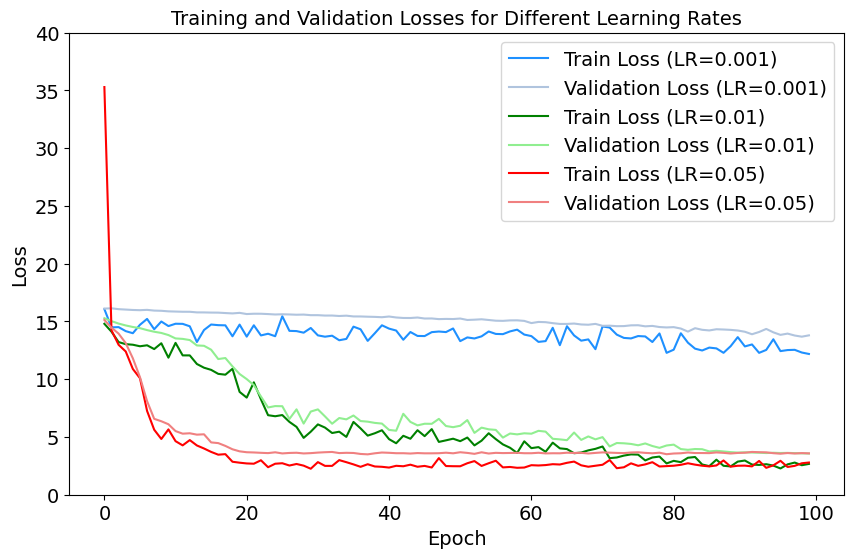

In [99]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define a list of learning rates to experiment with
learning_rates = [0.001, 0.01, 0.05]

# Lists to store train and validation losses for each learning rate
train_loss_per_lr = []
val_loss_per_lr = []

# Rest of your code remains the same
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cVAE_classifier(input_dimension=148, latent_dim=4).to(device)

# Colors for lines
train_colors = ['dodgerblue', 'green', 'red']  # Shades of blue for training
val_colors = ['lightsteelblue', 'lightgreen', 'lightcoral']  # Lighter shades for validation

# Iterate through different learning rates
for lr_idx, lr in enumerate(learning_rates):
    print(f"Training with learning rate: {lr}")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loss_list = []  # List to store train losses
    val_loss_list = []  # List to store validation losses

    model = cVAE_classifier(input_dimension=148, latent_dim=4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    classifier_criterion = nn.BCELoss()

    num_epochs = 100
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1} of {num_epochs}")
        # Train the model
        (train_loss_autism,
         train_loss_no_autism,
         train_age_loss_autism,
         train_gender_loss_autism,
         train_age_loss_no_autism,
         train_gender_loss_no_autism) = train(
            model,
            train_dataloader,
            train_dataset,
            device,
            optimizer,
            criterion,
            classifier_criterion,
        )

        # Validate the model
        (val_loss_autism, val_loss_no_autism,
         val_age_loss_autism, val_gender_loss_autism,
         val_age_loss_no_autism, val_gender_loss_no_autism) = validate(model, val_dataloader, val_dataset, device, criterion, classifier_criterion)

        # Appending the loss values to a list to allow for visualizations:
        train_loss_list.append(
            train_loss_autism
            + train_loss_no_autism
            + train_age_loss_autism
            + train_gender_loss_autism
            + train_age_loss_no_autism
            + train_gender_loss_no_autism
        )
        val_loss_list.append(
            val_loss_autism
            + val_loss_no_autism
            + val_age_loss_autism
            + val_gender_loss_autism
            + val_age_loss_no_autism
            + val_gender_loss_no_autism
        )

        # Print the losses
        print(
            f"Train Loss Autism: {train_loss_autism:.4f}, Train Loss Non-Autism: {train_loss_no_autism:.4f}, "
            f"Train Age Loss Autism: {train_age_loss_autism:.4f}, Train Gender Loss Autism: {train_gender_loss_autism:.4f}, "
            f"Train Age Loss Non-Autism: {train_age_loss_no_autism:.4f}, Train Gender Loss Non-Autism: {train_gender_loss_no_autism:.4f}"
        )

    # Store train and validation losses for this learning rate
    train_loss_per_lr.append(train_loss_list)
    val_loss_per_lr.append(val_loss_list)

# Plot the training and validation losses for each learning rate
plt.figure(figsize=(10, 6))
for i, lr in enumerate(learning_rates):
    plt.plot(train_loss_per_lr[i], label=f"Train Loss (LR={lr})", color=train_colors[i])
    plt.plot(val_loss_per_lr[i], label=f"Validation Loss (LR={lr})", color=val_colors[i])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for Different Learning Rates')
plt.legend()
plt.ylim(0, 40)  # Set y-axis limits
plt.show()


I have previously also experimented with higher learning rates. However, the instability of the model lead to poorer performance. As with 100 episodes, I achieve an equally as good performance using 0.01, but the model learns more stable. I chose this value. When inspecting models with 0.05, sometimes the various components of the model spikes up and down in their loss, but with 0.01, there was more so a gradual decrease among them.

Here is ChatGPTs answer as to why the learning rate may not matter that much with ADAM:
  > "The learning rate in the ADAM optimizer can be considered as an adaptive factor that adjusts during training based on the estimates of the first and second moments of the gradients. This adaptability allows ADAM to automatically adjust the learning rate for different parameters, which can be advantageous in terms of convergence speed and stability. As a result, the initial choice of learning rate becomes less critical compared to traditional optimizers, as ADAM's adaptive behavior helps mitigate the need for manual fine-tuning of the learning rate. This adaptability can often lead to reasonable training performance even with a wider range of initial learning rate choices, making ADAM more forgiving in practice."


Here is the final training loop with the chosen parameters. Note that the learning rate is .05, which is higher than the preset learning rate.

Epoch 1 of 100


4it [00:00, 48.02it/s]               
3it [00:00, 61.17it/s]               


Train Loss Autism: 4.4317, Train Loss Non-Autism: 3.5086, Train Age Loss Autism: 3.9021, Train Gender Loss Autism: 0.0079, Train Age Loss Non-Autism: 3.3514, Train Gender Loss Non-Autism: 0.0074
Val Loss Autism: 3.7251, Val Loss Non-Autism: 4.0416, Val Age Loss Autism: 3.5715, Val Gender Loss Autism: 0.0072, Val Age Loss Non-Autism: 3.9627, Val Gender Loss Non-Autism: 0.0074
Epoch 2 of 100


4it [00:00, 39.87it/s]               
3it [00:00, 86.00it/s]               


Train Loss Autism: 3.5052, Train Loss Non-Autism: 3.0821, Train Age Loss Autism: 3.3416, Train Gender Loss Autism: 0.0070, Train Age Loss Non-Autism: 3.0212, Train Gender Loss Non-Autism: 0.0073
Val Loss Autism: 3.6289, Val Loss Non-Autism: 3.9499, Val Age Loss Autism: 3.5093, Val Gender Loss Autism: 0.0071, Val Age Loss Non-Autism: 3.9023, Val Gender Loss Non-Autism: 0.0075
Epoch 3 of 100


4it [00:00, 35.76it/s]
3it [00:00, 113.56it/s]              


Train Loss Autism: 3.6097, Train Loss Non-Autism: 3.1352, Train Age Loss Autism: 3.5166, Train Gender Loss Autism: 0.0072, Train Age Loss Non-Autism: 3.0922, Train Gender Loss Non-Autism: 0.0073
Val Loss Autism: 3.6015, Val Loss Non-Autism: 3.9022, Val Age Loss Autism: 3.5088, Val Gender Loss Autism: 0.0074, Val Age Loss Non-Autism: 3.8583, Val Gender Loss Non-Autism: 0.0074
Epoch 4 of 100


4it [00:00, 44.82it/s]               
3it [00:00, 85.26it/s]               


Train Loss Autism: 3.7576, Train Loss Non-Autism: 3.5005, Train Age Loss Autism: 3.6797, Train Gender Loss Autism: 0.0072, Train Age Loss Non-Autism: 3.4608, Train Gender Loss Non-Autism: 0.0071
Val Loss Autism: 3.5307, Val Loss Non-Autism: 3.8763, Val Age Loss Autism: 3.4788, Val Gender Loss Autism: 0.0069, Val Age Loss Non-Autism: 3.8443, Val Gender Loss Non-Autism: 0.0069
Epoch 5 of 100


4it [00:00, 48.80it/s]               
3it [00:00, 87.42it/s]               


Train Loss Autism: 3.6139, Train Loss Non-Autism: 3.0848, Train Age Loss Autism: 3.5619, Train Gender Loss Autism: 0.0068, Train Age Loss Non-Autism: 3.0526, Train Gender Loss Non-Autism: 0.0069
Val Loss Autism: 3.4482, Val Loss Non-Autism: 3.8084, Val Age Loss Autism: 3.3794, Val Gender Loss Autism: 0.0068, Val Age Loss Non-Autism: 3.7731, Val Gender Loss Non-Autism: 0.0068
Epoch 6 of 100


4it [00:00, 41.94it/s]               
3it [00:00, 100.38it/s]              


Train Loss Autism: 3.4953, Train Loss Non-Autism: 3.0306, Train Age Loss Autism: 3.4212, Train Gender Loss Autism: 0.0066, Train Age Loss Non-Autism: 2.9959, Train Gender Loss Non-Autism: 0.0067
Val Loss Autism: 3.4070, Val Loss Non-Autism: 3.7588, Val Age Loss Autism: 3.3315, Val Gender Loss Autism: 0.0060, Val Age Loss Non-Autism: 3.7297, Val Gender Loss Non-Autism: 0.0065
Epoch 7 of 100


4it [00:00, 54.52it/s]               
3it [00:00, 82.29it/s]               


Train Loss Autism: 3.7759, Train Loss Non-Autism: 2.8383, Train Age Loss Autism: 3.7000, Train Gender Loss Autism: 0.0062, Train Age Loss Non-Autism: 2.8066, Train Gender Loss Non-Autism: 0.0064
Val Loss Autism: 3.3246, Val Loss Non-Autism: 3.7199, Val Age Loss Autism: 3.2464, Val Gender Loss Autism: 0.0059, Val Age Loss Non-Autism: 3.6787, Val Gender Loss Non-Autism: 0.0062
Epoch 8 of 100


4it [00:00, 50.51it/s]               
3it [00:00, 52.96it/s]               


Train Loss Autism: 3.3327, Train Loss Non-Autism: 3.1884, Train Age Loss Autism: 3.2511, Train Gender Loss Autism: 0.0061, Train Age Loss Non-Autism: 3.1414, Train Gender Loss Non-Autism: 0.0063
Val Loss Autism: 3.2991, Val Loss Non-Autism: 3.6143, Val Age Loss Autism: 3.2082, Val Gender Loss Autism: 0.0058, Val Age Loss Non-Autism: 3.5576, Val Gender Loss Non-Autism: 0.0060
Epoch 9 of 100


4it [00:00, 61.00it/s]               
3it [00:00, 101.14it/s]              


Train Loss Autism: 3.8241, Train Loss Non-Autism: 2.7708, Train Age Loss Autism: 3.7327, Train Gender Loss Autism: 0.0059, Train Age Loss Non-Autism: 2.7134, Train Gender Loss Non-Autism: 0.0060
Val Loss Autism: 3.2665, Val Loss Non-Autism: 3.5693, Val Age Loss Autism: 3.1580, Val Gender Loss Autism: 0.0055, Val Age Loss Non-Autism: 3.5045, Val Gender Loss Non-Autism: 0.0059
Epoch 10 of 100


4it [00:00, 50.00it/s]               
3it [00:00, 94.06it/s]               


Train Loss Autism: 3.0403, Train Loss Non-Autism: 2.8463, Train Age Loss Autism: 2.9216, Train Gender Loss Autism: 0.0055, Train Age Loss Non-Autism: 2.7745, Train Gender Loss Non-Autism: 0.0058
Val Loss Autism: 3.1671, Val Loss Non-Autism: 3.4899, Val Age Loss Autism: 3.0006, Val Gender Loss Autism: 0.0051, Val Age Loss Non-Autism: 3.3881, Val Gender Loss Non-Autism: 0.0055
Epoch 11 of 100


4it [00:00, 58.84it/s]               
3it [00:00, 71.51it/s]               


Train Loss Autism: 3.2084, Train Loss Non-Autism: 2.9856, Train Age Loss Autism: 3.0352, Train Gender Loss Autism: 0.0051, Train Age Loss Non-Autism: 2.8784, Train Gender Loss Non-Autism: 0.0056
Val Loss Autism: 3.0738, Val Loss Non-Autism: 3.4580, Val Age Loss Autism: 2.8573, Val Gender Loss Autism: 0.0048, Val Age Loss Non-Autism: 3.3256, Val Gender Loss Non-Autism: 0.0054
Epoch 12 of 100


4it [00:00, 48.97it/s]               
3it [00:00, 81.47it/s]               


Train Loss Autism: 2.8830, Train Loss Non-Autism: 2.5992, Train Age Loss Autism: 2.6633, Train Gender Loss Autism: 0.0050, Train Age Loss Non-Autism: 2.4645, Train Gender Loss Non-Autism: 0.0053
Val Loss Autism: 2.9326, Val Loss Non-Autism: 3.3326, Val Age Loss Autism: 2.6811, Val Gender Loss Autism: 0.0043, Val Age Loss Non-Autism: 3.1835, Val Gender Loss Non-Autism: 0.0052
Epoch 13 of 100


4it [00:00, 54.86it/s]               
3it [00:00, 105.64it/s]              


Train Loss Autism: 2.6476, Train Loss Non-Autism: 2.6231, Train Age Loss Autism: 2.3726, Train Gender Loss Autism: 0.0045, Train Age Loss Non-Autism: 2.4489, Train Gender Loss Non-Autism: 0.0053
Val Loss Autism: 2.8039, Val Loss Non-Autism: 3.1274, Val Age Loss Autism: 2.4548, Val Gender Loss Autism: 0.0043, Val Age Loss Non-Autism: 2.8946, Val Gender Loss Non-Autism: 0.0051
Epoch 14 of 100


4it [00:00, 54.47it/s]               
3it [00:00, 73.35it/s]               


Train Loss Autism: 2.6712, Train Loss Non-Autism: 2.2281, Train Age Loss Autism: 2.3250, Train Gender Loss Autism: 0.0045, Train Age Loss Non-Autism: 1.9942, Train Gender Loss Non-Autism: 0.0053
Val Loss Autism: 2.6554, Val Loss Non-Autism: 2.9831, Val Age Loss Autism: 2.3252, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.7793, Val Gender Loss Non-Autism: 0.0050
Epoch 15 of 100


4it [00:00, 55.91it/s]               
3it [00:00, 65.00it/s]               


Train Loss Autism: 2.7078, Train Loss Non-Autism: 2.4966, Train Age Loss Autism: 2.3691, Train Gender Loss Autism: 0.0044, Train Age Loss Non-Autism: 2.2817, Train Gender Loss Non-Autism: 0.0045
Val Loss Autism: 2.5505, Val Loss Non-Autism: 2.8677, Val Age Loss Autism: 2.0517, Val Gender Loss Autism: 0.0036, Val Age Loss Non-Autism: 2.5235, Val Gender Loss Non-Autism: 0.0047
Epoch 16 of 100


4it [00:00, 35.09it/s]
3it [00:00, 54.15it/s]               


Train Loss Autism: 2.8448, Train Loss Non-Autism: 2.2955, Train Age Loss Autism: 2.3103, Train Gender Loss Autism: 0.0042, Train Age Loss Non-Autism: 1.9147, Train Gender Loss Non-Autism: 0.0053
Val Loss Autism: 2.4477, Val Loss Non-Autism: 2.7795, Val Age Loss Autism: 1.9564, Val Gender Loss Autism: 0.0035, Val Age Loss Non-Autism: 2.4832, Val Gender Loss Non-Autism: 0.0048
Epoch 17 of 100


4it [00:00, 40.51it/s]               
3it [00:00, 67.54it/s]               


Train Loss Autism: 2.0952, Train Loss Non-Autism: 2.0432, Train Age Loss Autism: 1.6083, Train Gender Loss Autism: 0.0047, Train Age Loss Non-Autism: 1.7453, Train Gender Loss Non-Autism: 0.0049
Val Loss Autism: 2.1973, Val Loss Non-Autism: 2.6032, Val Age Loss Autism: 1.6917, Val Gender Loss Autism: 0.0033, Val Age Loss Non-Autism: 2.2897, Val Gender Loss Non-Autism: 0.0047
Epoch 18 of 100


4it [00:00, 30.94it/s]                       
3it [00:00, 61.82it/s]               


Train Loss Autism: 2.2299, Train Loss Non-Autism: 2.2328, Train Age Loss Autism: 1.7268, Train Gender Loss Autism: 0.0044, Train Age Loss Non-Autism: 1.9045, Train Gender Loss Non-Autism: 0.0049
Val Loss Autism: 2.3179, Val Loss Non-Autism: 2.3466, Val Age Loss Autism: 1.7178, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 1.9187, Val Gender Loss Non-Autism: 0.0046
Epoch 19 of 100


4it [00:00, 36.86it/s]
3it [00:00, 68.33it/s]               


Train Loss Autism: 2.0585, Train Loss Non-Autism: 1.9300, Train Age Loss Autism: 1.4477, Train Gender Loss Autism: 0.0044, Train Age Loss Non-Autism: 1.4795, Train Gender Loss Non-Autism: 0.0046
Val Loss Autism: 2.1339, Val Loss Non-Autism: 2.3725, Val Age Loss Autism: 1.6303, Val Gender Loss Autism: 0.0034, Val Age Loss Non-Autism: 2.0335, Val Gender Loss Non-Autism: 0.0045
Epoch 20 of 100


4it [00:00, 40.97it/s]               
3it [00:00, 61.81it/s]               


Train Loss Autism: 1.9403, Train Loss Non-Autism: 1.9805, Train Age Loss Autism: 1.4569, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 1.6554, Train Gender Loss Non-Autism: 0.0048
Val Loss Autism: 2.0324, Val Loss Non-Autism: 2.1776, Val Age Loss Autism: 1.4853, Val Gender Loss Autism: 0.0034, Val Age Loss Non-Autism: 1.7987, Val Gender Loss Non-Autism: 0.0045
Epoch 21 of 100


4it [00:00, 37.63it/s]
3it [00:00, 63.66it/s]               


Train Loss Autism: 2.1335, Train Loss Non-Autism: 1.8454, Train Age Loss Autism: 1.5820, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 1.4514, Train Gender Loss Non-Autism: 0.0050
Val Loss Autism: 2.0596, Val Loss Non-Autism: 2.1080, Val Age Loss Autism: 1.4415, Val Gender Loss Autism: 0.0033, Val Age Loss Non-Autism: 1.6476, Val Gender Loss Non-Autism: 0.0044
Epoch 22 of 100


4it [00:00, 35.42it/s]
3it [00:00, 71.04it/s]               


Train Loss Autism: 1.8969, Train Loss Non-Autism: 1.7368, Train Age Loss Autism: 1.2795, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 1.2691, Train Gender Loss Non-Autism: 0.0047
Val Loss Autism: 2.0520, Val Loss Non-Autism: 2.3499, Val Age Loss Autism: 1.6098, Val Gender Loss Autism: 0.0036, Val Age Loss Non-Autism: 2.0506, Val Gender Loss Non-Autism: 0.0046
Epoch 23 of 100


4it [00:00, 37.47it/s]
3it [00:00, 65.45it/s]               


Train Loss Autism: 1.8151, Train Loss Non-Autism: 1.7103, Train Age Loss Autism: 1.3807, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 1.4135, Train Gender Loss Non-Autism: 0.0045
Val Loss Autism: 1.8964, Val Loss Non-Autism: 1.9849, Val Age Loss Autism: 1.3117, Val Gender Loss Autism: 0.0033, Val Age Loss Non-Autism: 1.5388, Val Gender Loss Non-Autism: 0.0046
Epoch 24 of 100


4it [00:00, 38.59it/s]
3it [00:00, 58.71it/s]               


Train Loss Autism: 1.6617, Train Loss Non-Autism: 1.5520, Train Age Loss Autism: 1.0433, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 1.0734, Train Gender Loss Non-Autism: 0.0046
Val Loss Autism: 1.7636, Val Loss Non-Autism: 1.7849, Val Age Loss Autism: 1.3387, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 1.4956, Val Gender Loss Non-Autism: 0.0044
Epoch 25 of 100


4it [00:00, 43.12it/s]               
3it [00:00, 66.62it/s]               


Train Loss Autism: 1.8361, Train Loss Non-Autism: 1.5175, Train Age Loss Autism: 1.4392, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 1.2547, Train Gender Loss Non-Autism: 0.0047
Val Loss Autism: 1.8309, Val Loss Non-Autism: 1.8637, Val Age Loss Autism: 1.3062, Val Gender Loss Autism: 0.0035, Val Age Loss Non-Autism: 1.4679, Val Gender Loss Non-Autism: 0.0046
Epoch 26 of 100


4it [00:00, 42.74it/s]               
3it [00:00, 63.94it/s]               


Train Loss Autism: 1.5376, Train Loss Non-Autism: 1.4337, Train Age Loss Autism: 0.9693, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.9973, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.8178, Val Loss Non-Autism: 1.7953, Val Age Loss Autism: 1.4654, Val Gender Loss Autism: 0.0033, Val Age Loss Non-Autism: 1.5584, Val Gender Loss Non-Autism: 0.0046
Epoch 27 of 100


4it [00:00, 40.05it/s]               
3it [00:00, 73.09it/s]               


Train Loss Autism: 1.5930, Train Loss Non-Autism: 1.4209, Train Age Loss Autism: 1.2313, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 1.1772, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.8745, Val Loss Non-Autism: 1.6666, Val Age Loss Autism: 1.3737, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 1.2685, Val Gender Loss Non-Autism: 0.0046
Epoch 28 of 100


4it [00:00, 34.25it/s]
3it [00:00, 66.63it/s]               


Train Loss Autism: 1.3746, Train Loss Non-Autism: 1.4038, Train Age Loss Autism: 0.8659, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 1.0059, Train Gender Loss Non-Autism: 0.0046
Val Loss Autism: 1.4639, Val Loss Non-Autism: 1.6782, Val Age Loss Autism: 1.0478, Val Gender Loss Autism: 0.0033, Val Age Loss Non-Autism: 1.3555, Val Gender Loss Non-Autism: 0.0046
Epoch 29 of 100


4it [00:00, 34.42it/s]
3it [00:00, 65.56it/s]               


Train Loss Autism: 1.4511, Train Loss Non-Autism: 1.3461, Train Age Loss Autism: 1.0189, Train Gender Loss Autism: 0.0050, Train Age Loss Non-Autism: 1.0218, Train Gender Loss Non-Autism: 0.0047
Val Loss Autism: 1.7407, Val Loss Non-Autism: 1.8901, Val Age Loss Autism: 1.3228, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 1.5608, Val Gender Loss Non-Autism: 0.0045
Epoch 30 of 100


4it [00:00, 40.73it/s]               
3it [00:00, 69.83it/s]               


Train Loss Autism: 1.4929, Train Loss Non-Autism: 1.2197, Train Age Loss Autism: 1.0683, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 0.9008, Train Gender Loss Non-Autism: 0.0046
Val Loss Autism: 1.7939, Val Loss Non-Autism: 1.5480, Val Age Loss Autism: 1.3307, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 1.1567, Val Gender Loss Non-Autism: 0.0045
Epoch 31 of 100


4it [00:00, 35.67it/s]
3it [00:00, 59.76it/s]               


Train Loss Autism: 1.3157, Train Loss Non-Autism: 1.1857, Train Age Loss Autism: 0.8990, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.8643, Train Gender Loss Non-Autism: 0.0050
Val Loss Autism: 1.4498, Val Loss Non-Autism: 1.5048, Val Age Loss Autism: 0.9665, Val Gender Loss Autism: 0.0034, Val Age Loss Non-Autism: 1.0822, Val Gender Loss Non-Autism: 0.0044
Epoch 32 of 100


4it [00:00, 41.30it/s]               
3it [00:00, 71.11it/s]               


Train Loss Autism: 1.5936, Train Loss Non-Autism: 1.3225, Train Age Loss Autism: 1.0978, Train Gender Loss Autism: 0.0045, Train Age Loss Non-Autism: 0.9160, Train Gender Loss Non-Autism: 0.0053
Val Loss Autism: 1.4965, Val Loss Non-Autism: 1.8707, Val Age Loss Autism: 1.2292, Val Gender Loss Autism: 0.0034, Val Age Loss Non-Autism: 1.6702, Val Gender Loss Non-Autism: 0.0046
Epoch 33 of 100


4it [00:00, 42.48it/s]               
3it [00:00, 73.11it/s]               


Train Loss Autism: 1.5496, Train Loss Non-Autism: 1.1673, Train Age Loss Autism: 1.2310, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.9296, Train Gender Loss Non-Autism: 0.0044
Val Loss Autism: 1.8606, Val Loss Non-Autism: 1.4756, Val Age Loss Autism: 1.1453, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.8105, Val Gender Loss Non-Autism: 0.0046
Epoch 34 of 100


4it [00:00, 33.19it/s]
3it [00:00, 71.54it/s]               


Train Loss Autism: 1.6188, Train Loss Non-Autism: 1.4298, Train Age Loss Autism: 0.9774, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.9004, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.9890, Val Loss Non-Autism: 1.6015, Val Age Loss Autism: 1.7398, Val Gender Loss Autism: 0.0034, Val Age Loss Non-Autism: 1.4489, Val Gender Loss Non-Autism: 0.0047
Epoch 35 of 100


4it [00:00, 41.78it/s]               
3it [00:00, 70.23it/s]               


Train Loss Autism: 1.3817, Train Loss Non-Autism: 1.2722, Train Age Loss Autism: 1.1249, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 1.1161, Train Gender Loss Non-Autism: 0.0046
Val Loss Autism: 1.6716, Val Loss Non-Autism: 1.7375, Val Age Loss Autism: 1.3950, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 1.5636, Val Gender Loss Non-Autism: 0.0046
Epoch 36 of 100


4it [00:00, 37.33it/s]
3it [00:00, 69.31it/s]               


Train Loss Autism: 1.4913, Train Loss Non-Autism: 1.1072, Train Age Loss Autism: 1.1725, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 0.8991, Train Gender Loss Non-Autism: 0.0047
Val Loss Autism: 1.4877, Val Loss Non-Autism: 1.5722, Val Age Loss Autism: 1.0212, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 1.1895, Val Gender Loss Non-Autism: 0.0046
Epoch 37 of 100


4it [00:00, 41.84it/s]               
3it [00:00, 64.85it/s]               


Train Loss Autism: 1.3559, Train Loss Non-Autism: 1.0745, Train Age Loss Autism: 0.8770, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.6909, Train Gender Loss Non-Autism: 0.0048
Val Loss Autism: 1.4410, Val Loss Non-Autism: 1.4560, Val Age Loss Autism: 1.1754, Val Gender Loss Autism: 0.0033, Val Age Loss Non-Autism: 1.2310, Val Gender Loss Non-Autism: 0.0045
Epoch 38 of 100


4it [00:00, 37.07it/s]
3it [00:00, 69.31it/s]               


Train Loss Autism: 1.2693, Train Loss Non-Autism: 1.1099, Train Age Loss Autism: 0.9127, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.8144, Train Gender Loss Non-Autism: 0.0049
Val Loss Autism: 1.4768, Val Loss Non-Autism: 1.3768, Val Age Loss Autism: 0.9027, Val Gender Loss Autism: 0.0033, Val Age Loss Non-Autism: 0.8152, Val Gender Loss Non-Autism: 0.0045
Epoch 39 of 100


4it [00:00, 33.04it/s]
3it [00:00, 53.62it/s]               


Train Loss Autism: 1.4094, Train Loss Non-Autism: 1.1708, Train Age Loss Autism: 0.9910, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.8340, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.3548, Val Loss Non-Autism: 1.6138, Val Age Loss Autism: 1.1283, Val Gender Loss Autism: 0.0033, Val Age Loss Non-Autism: 1.4496, Val Gender Loss Non-Autism: 0.0045
Epoch 40 of 100


4it [00:00, 30.91it/s]                       
3it [00:00, 57.95it/s]               


Train Loss Autism: 1.4908, Train Loss Non-Autism: 1.0600, Train Age Loss Autism: 1.1287, Train Gender Loss Autism: 0.0046, Train Age Loss Non-Autism: 0.7923, Train Gender Loss Non-Autism: 0.0048
Val Loss Autism: 1.5060, Val Loss Non-Autism: 1.4029, Val Age Loss Autism: 0.9037, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.8637, Val Gender Loss Non-Autism: 0.0047
Epoch 41 of 100


4it [00:00, 37.02it/s]
3it [00:00, 66.72it/s]               


Train Loss Autism: 1.3744, Train Loss Non-Autism: 1.1673, Train Age Loss Autism: 0.8712, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.7775, Train Gender Loss Non-Autism: 0.0047
Val Loss Autism: 1.4671, Val Loss Non-Autism: 1.5282, Val Age Loss Autism: 1.2139, Val Gender Loss Autism: 0.0033, Val Age Loss Non-Autism: 1.3686, Val Gender Loss Non-Autism: 0.0046
Epoch 42 of 100


4it [00:00, 42.47it/s]               
3it [00:00, 54.67it/s]               


Train Loss Autism: 1.4336, Train Loss Non-Autism: 1.2873, Train Age Loss Autism: 1.1706, Train Gender Loss Autism: 0.0042, Train Age Loss Non-Autism: 1.1167, Train Gender Loss Non-Autism: 0.0045
Val Loss Autism: 1.4301, Val Loss Non-Autism: 1.4727, Val Age Loss Autism: 1.1218, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 1.2409, Val Gender Loss Non-Autism: 0.0046
Epoch 43 of 100


4it [00:00, 40.39it/s]               
3it [00:00, 60.60it/s]               


Train Loss Autism: 1.6353, Train Loss Non-Autism: 0.9973, Train Age Loss Autism: 1.2198, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 0.6733, Train Gender Loss Non-Autism: 0.0044
Val Loss Autism: 1.6157, Val Loss Non-Autism: 1.3704, Val Age Loss Autism: 1.0447, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.8393, Val Gender Loss Non-Autism: 0.0045
Epoch 44 of 100


4it [00:00, 34.85it/s]
3it [00:00, 65.68it/s]               


Train Loss Autism: 1.3360, Train Loss Non-Autism: 1.2145, Train Age Loss Autism: 0.8273, Train Gender Loss Autism: 0.0036, Train Age Loss Non-Autism: 0.7879, Train Gender Loss Non-Autism: 0.0045
Val Loss Autism: 1.4180, Val Loss Non-Autism: 1.5562, Val Age Loss Autism: 1.1647, Val Gender Loss Autism: 0.0034, Val Age Loss Non-Autism: 1.3558, Val Gender Loss Non-Autism: 0.0046
Epoch 45 of 100


4it [00:00, 36.72it/s]
3it [00:00, 48.69it/s]               


Train Loss Autism: 1.2940, Train Loss Non-Autism: 1.1499, Train Age Loss Autism: 0.9890, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.9104, Train Gender Loss Non-Autism: 0.0050
Val Loss Autism: 1.4307, Val Loss Non-Autism: 1.3801, Val Age Loss Autism: 0.9800, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.9615, Val Gender Loss Non-Autism: 0.0046
Epoch 46 of 100


4it [00:00, 32.64it/s]
3it [00:00, 55.17it/s]               


Train Loss Autism: 1.1687, Train Loss Non-Autism: 1.0979, Train Age Loss Autism: 0.6875, Train Gender Loss Autism: 0.0043, Train Age Loss Non-Autism: 0.7023, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.3505, Val Loss Non-Autism: 1.1354, Val Age Loss Autism: 1.0359, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 0.8623, Val Gender Loss Non-Autism: 0.0046
Epoch 47 of 100


4it [00:00, 37.91it/s]
3it [00:00, 57.40it/s]               


Train Loss Autism: 1.2019, Train Loss Non-Autism: 1.0105, Train Age Loss Autism: 0.8442, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.7275, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.0785, Val Loss Non-Autism: 1.1236, Val Age Loss Autism: 0.7209, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 0.7936, Val Gender Loss Non-Autism: 0.0045
Epoch 48 of 100


4it [00:00, 51.63it/s]               
3it [00:00, 106.10it/s]              


Train Loss Autism: 1.1607, Train Loss Non-Autism: 0.9392, Train Age Loss Autism: 0.7276, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.5766, Train Gender Loss Non-Autism: 0.0048
Val Loss Autism: 1.2726, Val Loss Non-Autism: 1.1670, Val Age Loss Autism: 0.9886, Val Gender Loss Autism: 0.0034, Val Age Loss Non-Autism: 0.9004, Val Gender Loss Non-Autism: 0.0045
Epoch 49 of 100


4it [00:00, 59.65it/s]               
3it [00:00, 102.32it/s]              


Train Loss Autism: 1.1125, Train Loss Non-Autism: 0.8288, Train Age Loss Autism: 0.7842, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.5573, Train Gender Loss Non-Autism: 0.0055
Val Loss Autism: 1.3194, Val Loss Non-Autism: 1.2422, Val Age Loss Autism: 0.9818, Val Gender Loss Autism: 0.0033, Val Age Loss Non-Autism: 0.9226, Val Gender Loss Non-Autism: 0.0046
Epoch 50 of 100


4it [00:00, 52.29it/s]               
3it [00:00, 107.22it/s]              


Train Loss Autism: 1.1961, Train Loss Non-Autism: 1.0572, Train Age Loss Autism: 0.8164, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.7419, Train Gender Loss Non-Autism: 0.0047
Val Loss Autism: 1.2760, Val Loss Non-Autism: 1.1644, Val Age Loss Autism: 0.9964, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.9055, Val Gender Loss Non-Autism: 0.0045
Epoch 51 of 100


4it [00:00, 56.51it/s]               
3it [00:00, 85.09it/s]               


Train Loss Autism: 0.9650, Train Loss Non-Autism: 0.9819, Train Age Loss Autism: 0.6163, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.6979, Train Gender Loss Non-Autism: 0.0044
Val Loss Autism: 1.3614, Val Loss Non-Autism: 1.1680, Val Age Loss Autism: 1.0652, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.8784, Val Gender Loss Non-Autism: 0.0045
Epoch 52 of 100


4it [00:00, 55.38it/s]               
3it [00:00, 91.76it/s]               


Train Loss Autism: 0.9096, Train Loss Non-Autism: 0.8717, Train Age Loss Autism: 0.5907, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5980, Train Gender Loss Non-Autism: 0.0047
Val Loss Autism: 1.3026, Val Loss Non-Autism: 1.2448, Val Age Loss Autism: 1.0900, Val Gender Loss Autism: 0.0033, Val Age Loss Non-Autism: 1.0378, Val Gender Loss Non-Autism: 0.0045
Epoch 53 of 100


4it [00:00, 52.76it/s]               
3it [00:00, 96.44it/s]               


Train Loss Autism: 1.1703, Train Loss Non-Autism: 0.8433, Train Age Loss Autism: 0.8905, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.6022, Train Gender Loss Non-Autism: 0.0049
Val Loss Autism: 1.1248, Val Loss Non-Autism: 1.1068, Val Age Loss Autism: 0.7774, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.7499, Val Gender Loss Non-Autism: 0.0046
Epoch 54 of 100


4it [00:00, 49.79it/s]               
3it [00:00, 95.33it/s]               


Train Loss Autism: 1.1848, Train Loss Non-Autism: 1.0001, Train Age Loss Autism: 0.8130, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.6892, Train Gender Loss Non-Autism: 0.0045
Val Loss Autism: 1.0629, Val Loss Non-Autism: 1.0621, Val Age Loss Autism: 0.8083, Val Gender Loss Autism: 0.0033, Val Age Loss Non-Autism: 0.8273, Val Gender Loss Non-Autism: 0.0046
Epoch 55 of 100


4it [00:00, 52.27it/s]               
3it [00:00, 104.31it/s]              


Train Loss Autism: 1.0981, Train Loss Non-Autism: 0.9019, Train Age Loss Autism: 0.7434, Train Gender Loss Autism: 0.0043, Train Age Loss Non-Autism: 0.6271, Train Gender Loss Non-Autism: 0.0047
Val Loss Autism: 1.0402, Val Loss Non-Autism: 0.9695, Val Age Loss Autism: 0.7066, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.6523, Val Gender Loss Non-Autism: 0.0046
Epoch 56 of 100


4it [00:00, 58.97it/s]               
3it [00:00, 102.65it/s]              


Train Loss Autism: 0.9291, Train Loss Non-Autism: 0.7745, Train Age Loss Autism: 0.5748, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.4698, Train Gender Loss Non-Autism: 0.0045
Val Loss Autism: 1.2300, Val Loss Non-Autism: 1.0209, Val Age Loss Autism: 1.0098, Val Gender Loss Autism: 0.0033, Val Age Loss Non-Autism: 0.7947, Val Gender Loss Non-Autism: 0.0046
Epoch 57 of 100


4it [00:00, 55.44it/s]               
3it [00:00, 106.92it/s]              


Train Loss Autism: 1.0822, Train Loss Non-Autism: 0.7966, Train Age Loss Autism: 0.8077, Train Gender Loss Autism: 0.0046, Train Age Loss Non-Autism: 0.5592, Train Gender Loss Non-Autism: 0.0045
Val Loss Autism: 1.1161, Val Loss Non-Autism: 0.9989, Val Age Loss Autism: 0.8045, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.6876, Val Gender Loss Non-Autism: 0.0045
Epoch 58 of 100


4it [00:00, 53.54it/s]               
3it [00:00, 91.56it/s]               


Train Loss Autism: 0.9929, Train Loss Non-Autism: 0.7774, Train Age Loss Autism: 0.6143, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.4537, Train Gender Loss Non-Autism: 0.0048
Val Loss Autism: 1.1520, Val Loss Non-Autism: 1.1986, Val Age Loss Autism: 0.9565, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 1.0054, Val Gender Loss Non-Autism: 0.0045
Epoch 59 of 100


4it [00:00, 50.04it/s]               
3it [00:00, 80.11it/s]               


Train Loss Autism: 1.2616, Train Loss Non-Autism: 0.8122, Train Age Loss Autism: 1.0333, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.6194, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.1179, Val Loss Non-Autism: 0.9604, Val Age Loss Autism: 0.7876, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 0.6566, Val Gender Loss Non-Autism: 0.0046
Epoch 60 of 100


4it [00:00, 55.41it/s]               
3it [00:00, 89.83it/s]               


Train Loss Autism: 0.9346, Train Loss Non-Autism: 0.9487, Train Age Loss Autism: 0.5126, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.6157, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.1032, Val Loss Non-Autism: 1.0966, Val Age Loss Autism: 0.8816, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.8985, Val Gender Loss Non-Autism: 0.0045
Epoch 61 of 100


4it [00:00, 45.23it/s]               
3it [00:00, 88.34it/s]               


Train Loss Autism: 0.9847, Train Loss Non-Autism: 0.8587, Train Age Loss Autism: 0.7597, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.6735, Train Gender Loss Non-Autism: 0.0044
Val Loss Autism: 1.1121, Val Loss Non-Autism: 1.0923, Val Age Loss Autism: 0.9413, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 0.9243, Val Gender Loss Non-Autism: 0.0045
Epoch 62 of 100


4it [00:00, 48.30it/s]               
3it [00:00, 89.33it/s]               


Train Loss Autism: 1.0093, Train Loss Non-Autism: 0.7258, Train Age Loss Autism: 0.7996, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.5379, Train Gender Loss Non-Autism: 0.0046
Val Loss Autism: 1.0730, Val Loss Non-Autism: 1.0293, Val Age Loss Autism: 0.8069, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 0.7483, Val Gender Loss Non-Autism: 0.0046
Epoch 63 of 100


4it [00:00, 58.77it/s]               
3it [00:00, 86.32it/s]               


Train Loss Autism: 0.9923, Train Loss Non-Autism: 0.8935, Train Age Loss Autism: 0.6446, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 0.5909, Train Gender Loss Non-Autism: 0.0041
Val Loss Autism: 1.1481, Val Loss Non-Autism: 0.9799, Val Age Loss Autism: 0.9175, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.7358, Val Gender Loss Non-Autism: 0.0045
Epoch 64 of 100


4it [00:00, 12.06it/s]                       
3it [00:00, 78.30it/s]               


Train Loss Autism: 0.9133, Train Loss Non-Autism: 0.7092, Train Age Loss Autism: 0.6460, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 0.4765, Train Gender Loss Non-Autism: 0.0047
Val Loss Autism: 0.9788, Val Loss Non-Autism: 1.0633, Val Age Loss Autism: 0.7464, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.8075, Val Gender Loss Non-Autism: 0.0045
Epoch 65 of 100


4it [00:00, 51.62it/s]               
3it [00:00, 89.32it/s]               


Train Loss Autism: 0.8010, Train Loss Non-Autism: 0.7387, Train Age Loss Autism: 0.4813, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 0.4551, Train Gender Loss Non-Autism: 0.0044
Val Loss Autism: 0.9737, Val Loss Non-Autism: 0.9769, Val Age Loss Autism: 0.7115, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.6936, Val Gender Loss Non-Autism: 0.0046
Epoch 66 of 100


4it [00:00, 60.71it/s]               
3it [00:00, 65.36it/s]               


Train Loss Autism: 0.8359, Train Loss Non-Autism: 0.8328, Train Age Loss Autism: 0.5494, Train Gender Loss Autism: 0.0045, Train Age Loss Non-Autism: 0.5784, Train Gender Loss Non-Autism: 0.0047
Val Loss Autism: 0.9554, Val Loss Non-Autism: 0.9418, Val Age Loss Autism: 0.7631, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.7407, Val Gender Loss Non-Autism: 0.0046
Epoch 67 of 100


4it [00:00, 48.01it/s]               
3it [00:00, 73.56it/s]               


Train Loss Autism: 0.7367, Train Loss Non-Autism: 0.7688, Train Age Loss Autism: 0.4899, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 0.5536, Train Gender Loss Non-Autism: 0.0049
Val Loss Autism: 0.9913, Val Loss Non-Autism: 1.0747, Val Age Loss Autism: 0.7934, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 0.8561, Val Gender Loss Non-Autism: 0.0047
Epoch 68 of 100


4it [00:00, 57.90it/s]               
3it [00:00, 87.91it/s]               


Train Loss Autism: 0.8950, Train Loss Non-Autism: 0.6610, Train Age Loss Autism: 0.6576, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.4446, Train Gender Loss Non-Autism: 0.0045
Val Loss Autism: 1.0697, Val Loss Non-Autism: 0.8718, Val Age Loss Autism: 0.8522, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 0.6349, Val Gender Loss Non-Autism: 0.0048
Epoch 69 of 100


4it [00:00, 53.22it/s]               
3it [00:00, 95.24it/s]               


Train Loss Autism: 0.7917, Train Loss Non-Autism: 0.7167, Train Age Loss Autism: 0.5266, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.4840, Train Gender Loss Non-Autism: 0.0045
Val Loss Autism: 0.8527, Val Loss Non-Autism: 0.7225, Val Age Loss Autism: 0.6576, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 0.5084, Val Gender Loss Non-Autism: 0.0047
Epoch 70 of 100


4it [00:00, 52.45it/s]               
3it [00:00, 90.37it/s]               


Train Loss Autism: 0.8182, Train Loss Non-Autism: 0.6198, Train Age Loss Autism: 0.5558, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.3857, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 0.8625, Val Loss Non-Autism: 0.8911, Val Age Loss Autism: 0.6327, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.6389, Val Gender Loss Non-Autism: 0.0046
Epoch 71 of 100


4it [00:00, 52.75it/s]               
3it [00:00, 98.37it/s]               


Train Loss Autism: 0.7632, Train Loss Non-Autism: 0.7173, Train Age Loss Autism: 0.4996, Train Gender Loss Autism: 0.0036, Train Age Loss Non-Autism: 0.4769, Train Gender Loss Non-Autism: 0.0045
Val Loss Autism: 0.8807, Val Loss Non-Autism: 1.0273, Val Age Loss Autism: 0.6890, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.8206, Val Gender Loss Non-Autism: 0.0045
Epoch 72 of 100


4it [00:00, 59.85it/s]               
3it [00:00, 90.65it/s]               


Train Loss Autism: 0.7524, Train Loss Non-Autism: 0.7766, Train Age Loss Autism: 0.5105, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 0.5571, Train Gender Loss Non-Autism: 0.0047
Val Loss Autism: 1.0770, Val Loss Non-Autism: 0.7312, Val Age Loss Autism: 0.8842, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 0.5171, Val Gender Loss Non-Autism: 0.0046
Epoch 73 of 100


4it [00:00, 54.99it/s]               
3it [00:00, 78.60it/s]               


Train Loss Autism: 0.7206, Train Loss Non-Autism: 0.6435, Train Age Loss Autism: 0.4952, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.4328, Train Gender Loss Non-Autism: 0.0046
Val Loss Autism: 0.9074, Val Loss Non-Autism: 0.8789, Val Age Loss Autism: 0.7299, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 0.6827, Val Gender Loss Non-Autism: 0.0045
Epoch 74 of 100


4it [00:00, 58.43it/s]               
3it [00:00, 90.26it/s]               


Train Loss Autism: 0.9171, Train Loss Non-Autism: 0.7341, Train Age Loss Autism: 0.6959, Train Gender Loss Autism: 0.0042, Train Age Loss Non-Autism: 0.5309, Train Gender Loss Non-Autism: 0.0047
Val Loss Autism: 0.8289, Val Loss Non-Autism: 1.0278, Val Age Loss Autism: 0.5877, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.7648, Val Gender Loss Non-Autism: 0.0045
Epoch 75 of 100


4it [00:00, 46.69it/s]               
3it [00:00, 96.61it/s]               


Train Loss Autism: 0.7818, Train Loss Non-Autism: 0.8648, Train Age Loss Autism: 0.4661, Train Gender Loss Autism: 0.0042, Train Age Loss Non-Autism: 0.5786, Train Gender Loss Non-Autism: 0.0050
Val Loss Autism: 0.7104, Val Loss Non-Autism: 0.9836, Val Age Loss Autism: 0.5329, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.7933, Val Gender Loss Non-Autism: 0.0046
Epoch 76 of 100


4it [00:00, 55.21it/s]               
3it [00:00, 90.30it/s]               


Train Loss Autism: 0.7373, Train Loss Non-Autism: 0.5534, Train Age Loss Autism: 0.5280, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.3563, Train Gender Loss Non-Autism: 0.0047
Val Loss Autism: 0.9271, Val Loss Non-Autism: 0.8741, Val Age Loss Autism: 0.7440, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.6689, Val Gender Loss Non-Autism: 0.0045
Epoch 77 of 100


4it [00:00, 57.70it/s]               
3it [00:00, 114.64it/s]              


Train Loss Autism: 0.7562, Train Loss Non-Autism: 0.6438, Train Age Loss Autism: 0.5093, Train Gender Loss Autism: 0.0042, Train Age Loss Non-Autism: 0.4254, Train Gender Loss Non-Autism: 0.0048
Val Loss Autism: 0.8705, Val Loss Non-Autism: 0.7885, Val Age Loss Autism: 0.6937, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 0.5845, Val Gender Loss Non-Autism: 0.0046
Epoch 78 of 100


4it [00:00, 58.36it/s]               
3it [00:00, 78.80it/s]               


Train Loss Autism: 0.7985, Train Loss Non-Autism: 0.7217, Train Age Loss Autism: 0.5782, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.5204, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 0.8001, Val Loss Non-Autism: 0.8588, Val Age Loss Autism: 0.6001, Val Gender Loss Autism: 0.0033, Val Age Loss Non-Autism: 0.6260, Val Gender Loss Non-Autism: 0.0046
Epoch 79 of 100


4it [00:00, 55.40it/s]               
3it [00:00, 92.13it/s]               


Train Loss Autism: 0.7707, Train Loss Non-Autism: 0.6892, Train Age Loss Autism: 0.4988, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.4349, Train Gender Loss Non-Autism: 0.0047
Val Loss Autism: 0.8996, Val Loss Non-Autism: 0.7423, Val Age Loss Autism: 0.7001, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.5154, Val Gender Loss Non-Autism: 0.0045
Epoch 80 of 100


4it [00:00, 50.90it/s]               
3it [00:00, 88.69it/s]               


Train Loss Autism: 0.6914, Train Loss Non-Autism: 0.6788, Train Age Loss Autism: 0.4539, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 0.4583, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 0.8648, Val Loss Non-Autism: 0.7741, Val Age Loss Autism: 0.6583, Val Gender Loss Autism: 0.0033, Val Age Loss Non-Autism: 0.5394, Val Gender Loss Non-Autism: 0.0046
Epoch 81 of 100


4it [00:00, 55.42it/s]               
3it [00:00, 102.87it/s]              


Train Loss Autism: 0.7440, Train Loss Non-Autism: 0.6415, Train Age Loss Autism: 0.4975, Train Gender Loss Autism: 0.0042, Train Age Loss Non-Autism: 0.4144, Train Gender Loss Non-Autism: 0.0047
Val Loss Autism: 0.8822, Val Loss Non-Autism: 0.8497, Val Age Loss Autism: 0.7292, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.6813, Val Gender Loss Non-Autism: 0.0045
Epoch 82 of 100


4it [00:00, 53.84it/s]               
3it [00:00, 86.82it/s]               


Train Loss Autism: 0.8021, Train Loss Non-Autism: 0.6281, Train Age Loss Autism: 0.6151, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.4524, Train Gender Loss Non-Autism: 0.0049
Val Loss Autism: 0.7517, Val Loss Non-Autism: 0.8150, Val Age Loss Autism: 0.5719, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 0.6117, Val Gender Loss Non-Autism: 0.0045
Epoch 83 of 100


4it [00:00, 49.57it/s]               
3it [00:00, 84.10it/s]               


Train Loss Autism: 0.7772, Train Loss Non-Autism: 0.5782, Train Age Loss Autism: 0.5499, Train Gender Loss Autism: 0.0036, Train Age Loss Non-Autism: 0.3721, Train Gender Loss Non-Autism: 0.0044
Val Loss Autism: 0.7308, Val Loss Non-Autism: 0.7361, Val Age Loss Autism: 0.5550, Val Gender Loss Autism: 0.0033, Val Age Loss Non-Autism: 0.5371, Val Gender Loss Non-Autism: 0.0047
Epoch 84 of 100


4it [00:00, 51.82it/s]               
3it [00:00, 94.69it/s]               


Train Loss Autism: 0.6546, Train Loss Non-Autism: 0.6502, Train Age Loss Autism: 0.4244, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 0.4337, Train Gender Loss Non-Autism: 0.0049
Val Loss Autism: 0.7643, Val Loss Non-Autism: 0.6891, Val Age Loss Autism: 0.5792, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.4762, Val Gender Loss Non-Autism: 0.0045
Epoch 85 of 100


4it [00:00, 53.79it/s]               
3it [00:00, 94.92it/s]               


Train Loss Autism: 0.6288, Train Loss Non-Autism: 0.7267, Train Age Loss Autism: 0.4042, Train Gender Loss Autism: 0.0042, Train Age Loss Non-Autism: 0.5192, Train Gender Loss Non-Autism: 0.0046
Val Loss Autism: 0.8168, Val Loss Non-Autism: 0.7377, Val Age Loss Autism: 0.6530, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.5484, Val Gender Loss Non-Autism: 0.0046
Epoch 86 of 100


4it [00:00, 51.63it/s]               
3it [00:00, 76.71it/s]               


Train Loss Autism: 0.6198, Train Loss Non-Autism: 0.5679, Train Age Loss Autism: 0.4151, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.3812, Train Gender Loss Non-Autism: 0.0045
Val Loss Autism: 0.7515, Val Loss Non-Autism: 0.8084, Val Age Loss Autism: 0.6090, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.6495, Val Gender Loss Non-Autism: 0.0046
Epoch 87 of 100


4it [00:00, 50.23it/s]               
3it [00:00, 88.65it/s]               


Train Loss Autism: 0.6933, Train Loss Non-Autism: 0.5090, Train Age Loss Autism: 0.5167, Train Gender Loss Autism: 0.0036, Train Age Loss Non-Autism: 0.3450, Train Gender Loss Non-Autism: 0.0048
Val Loss Autism: 0.7664, Val Loss Non-Autism: 0.7713, Val Age Loss Autism: 0.6029, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 0.5840, Val Gender Loss Non-Autism: 0.0047
Epoch 88 of 100


4it [00:00, 44.90it/s]               
3it [00:00, 76.24it/s]               


Train Loss Autism: 0.7485, Train Loss Non-Autism: 0.5424, Train Age Loss Autism: 0.5239, Train Gender Loss Autism: 0.0036, Train Age Loss Non-Autism: 0.3335, Train Gender Loss Non-Autism: 0.0044
Val Loss Autism: 0.8279, Val Loss Non-Autism: 0.8556, Val Age Loss Autism: 0.6457, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 0.6494, Val Gender Loss Non-Autism: 0.0045
Epoch 89 of 100


4it [00:00, 52.61it/s]               
3it [00:00, 78.74it/s]               


Train Loss Autism: 0.6812, Train Loss Non-Autism: 0.5187, Train Age Loss Autism: 0.4655, Train Gender Loss Autism: 0.0044, Train Age Loss Non-Autism: 0.3125, Train Gender Loss Non-Autism: 0.0049
Val Loss Autism: 0.8604, Val Loss Non-Autism: 0.8379, Val Age Loss Autism: 0.6985, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.6546, Val Gender Loss Non-Autism: 0.0045
Epoch 90 of 100


4it [00:00, 51.81it/s]               
3it [00:00, 53.07it/s]               


Train Loss Autism: 0.6307, Train Loss Non-Autism: 0.5116, Train Age Loss Autism: 0.4340, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 0.3295, Train Gender Loss Non-Autism: 0.0045
Val Loss Autism: 0.8158, Val Loss Non-Autism: 0.7905, Val Age Loss Autism: 0.6690, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.6185, Val Gender Loss Non-Autism: 0.0046
Epoch 91 of 100


4it [00:00, 59.89it/s]               
3it [00:00, 113.35it/s]              


Train Loss Autism: 0.6913, Train Loss Non-Autism: 0.5551, Train Age Loss Autism: 0.5091, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.3878, Train Gender Loss Non-Autism: 0.0045
Val Loss Autism: 0.7964, Val Loss Non-Autism: 0.8539, Val Age Loss Autism: 0.6562, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.6952, Val Gender Loss Non-Autism: 0.0046
Epoch 92 of 100


4it [00:00, 55.25it/s]               
3it [00:00, 86.97it/s]               


Train Loss Autism: 0.6202, Train Loss Non-Autism: 0.5285, Train Age Loss Autism: 0.4265, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.3497, Train Gender Loss Non-Autism: 0.0044
Val Loss Autism: 0.8424, Val Loss Non-Autism: 0.7398, Val Age Loss Autism: 0.6880, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 0.5603, Val Gender Loss Non-Autism: 0.0046
Epoch 93 of 100


4it [00:00, 54.83it/s]               
3it [00:00, 89.97it/s]               


Train Loss Autism: 0.7851, Train Loss Non-Autism: 0.5411, Train Age Loss Autism: 0.6000, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.3661, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 0.7258, Val Loss Non-Autism: 0.7385, Val Age Loss Autism: 0.5730, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 0.5629, Val Gender Loss Non-Autism: 0.0045
Epoch 94 of 100


4it [00:00, 48.94it/s]               
3it [00:00, 91.55it/s]               


Train Loss Autism: 0.5927, Train Loss Non-Autism: 0.5013, Train Age Loss Autism: 0.3903, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 0.3180, Train Gender Loss Non-Autism: 0.0048
Val Loss Autism: 0.7596, Val Loss Non-Autism: 0.7934, Val Age Loss Autism: 0.6324, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.6489, Val Gender Loss Non-Autism: 0.0047
Epoch 95 of 100


4it [00:00, 49.27it/s]               
3it [00:00, 104.47it/s]              


Train Loss Autism: 0.7376, Train Loss Non-Autism: 0.6493, Train Age Loss Autism: 0.5871, Train Gender Loss Autism: 0.0039, Train Age Loss Non-Autism: 0.5100, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 0.7911, Val Loss Non-Autism: 0.7969, Val Age Loss Autism: 0.6366, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 0.6169, Val Gender Loss Non-Autism: 0.0046
Epoch 96 of 100


4it [00:00, 45.59it/s]               
3it [00:00, 89.05it/s]               


Train Loss Autism: 0.6836, Train Loss Non-Autism: 0.5308, Train Age Loss Autism: 0.4666, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 0.3339, Train Gender Loss Non-Autism: 0.0046
Val Loss Autism: 0.8133, Val Loss Non-Autism: 0.7799, Val Age Loss Autism: 0.6512, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.6003, Val Gender Loss Non-Autism: 0.0046
Epoch 97 of 100


4it [00:00, 56.97it/s]               
3it [00:00, 98.33it/s]               


Train Loss Autism: 0.6593, Train Loss Non-Autism: 0.5477, Train Age Loss Autism: 0.4685, Train Gender Loss Autism: 0.0043, Train Age Loss Non-Autism: 0.3680, Train Gender Loss Non-Autism: 0.0045
Val Loss Autism: 0.7800, Val Loss Non-Autism: 0.7622, Val Age Loss Autism: 0.6098, Val Gender Loss Autism: 0.0033, Val Age Loss Non-Autism: 0.5661, Val Gender Loss Non-Autism: 0.0047
Epoch 98 of 100


4it [00:00, 35.96it/s]
3it [00:00, 78.66it/s]               


Train Loss Autism: 0.6735, Train Loss Non-Autism: 0.5502, Train Age Loss Autism: 0.4575, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 0.3485, Train Gender Loss Non-Autism: 0.0048
Val Loss Autism: 0.7777, Val Loss Non-Autism: 0.6851, Val Age Loss Autism: 0.6360, Val Gender Loss Autism: 0.0032, Val Age Loss Non-Autism: 0.5304, Val Gender Loss Non-Autism: 0.0045
Epoch 99 of 100


4it [00:00, 55.42it/s]               
3it [00:00, 102.79it/s]              


Train Loss Autism: 0.5956, Train Loss Non-Autism: 0.5319, Train Age Loss Autism: 0.4383, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 0.3773, Train Gender Loss Non-Autism: 0.0050
Val Loss Autism: 0.7216, Val Loss Non-Autism: 0.8882, Val Age Loss Autism: 0.5938, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 0.7410, Val Gender Loss Non-Autism: 0.0047
Epoch 100 of 100


4it [00:00, 55.84it/s]               
3it [00:00, 100.78it/s]              


Train Loss Autism: 0.6251, Train Loss Non-Autism: 0.5222, Train Age Loss Autism: 0.4558, Train Gender Loss Autism: 0.0038, Train Age Loss Non-Autism: 0.3669, Train Gender Loss Non-Autism: 0.0045
Val Loss Autism: 0.8977, Val Loss Non-Autism: 0.6444, Val Age Loss Autism: 0.7691, Val Gender Loss Autism: 0.0031, Val Age Loss Non-Autism: 0.4934, Val Gender Loss Non-Autism: 0.0046


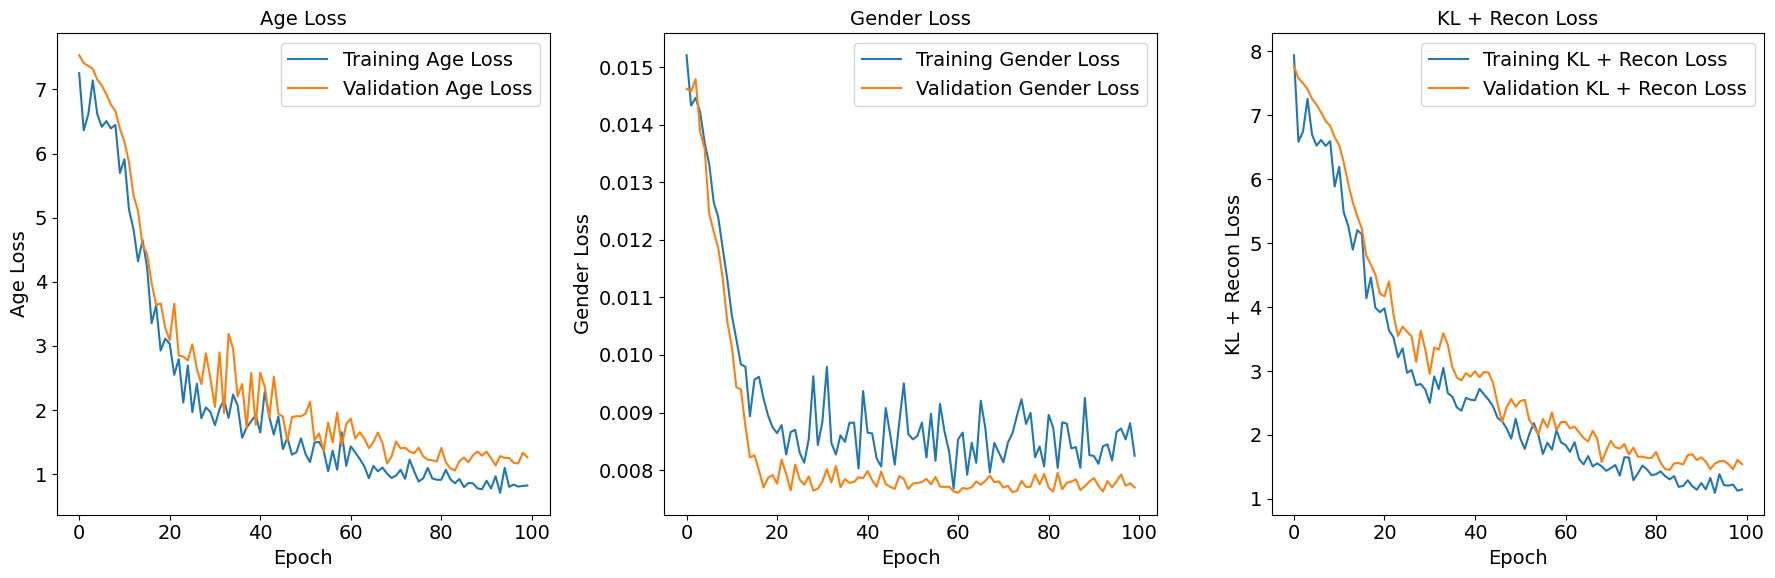

In [100]:
lr = 0.01
model_classifier = cVAE_classifier(input_dimension = 148, latent_dim= 4).to(device)
optimizer = torch.optim.Adam(model_classifier.parameters(), lr=lr)
criterion = nn.MSELoss()
classifier_criterion = nn.BCELoss()

# Create separate lists for training and validation losses for age, gender, and other terms
train_age_losses = []
val_age_losses = []
train_gender_losses = []
val_gender_losses = []
train_other_losses = []
val_other_losses = []

num_epochs = 100
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} of {num_epochs}")
    # Train the model
    (   train_loss_autism,
        train_loss_no_autism,
        train_age_loss_autism,
        train_gender_loss_autism,
        train_age_loss_no_autism,
        train_gender_loss_no_autism) = train(
        model_classifier,
        train_dataloader,
        train_dataset,
        device,
        optimizer,
        criterion,
        classifier_criterion)

    # Validate the model
    val_loss_autism, val_loss_no_autism, val_age_loss_autism, val_gender_loss_autism, val_age_loss_no_autism, val_gender_loss_no_autism = validate(model_classifier, val_dataloader, val_dataset, device, criterion, classifier_criterion)

    # Appending the loss values to their respective lists for visualizations:
    train_age_losses.append(train_age_loss_autism + train_age_loss_no_autism)
    train_gender_losses.append(train_gender_loss_autism + train_gender_loss_no_autism)
    train_other_losses.append(train_loss_autism + train_loss_no_autism)

    val_age_losses.append(val_age_loss_autism + val_age_loss_no_autism)
    val_gender_losses.append(val_gender_loss_autism + val_gender_loss_no_autism)
    val_other_losses.append(val_loss_autism + val_loss_no_autism)


    print(f"Train Loss Autism: {train_loss_autism:.4f}, Train Loss Non-Autism: {train_loss_no_autism:.4f}, "
    f"Train Age Loss Autism: {train_age_loss_autism:.4f}, Train Gender Loss Autism: {train_gender_loss_autism:.4f}, "
    f"Train Age Loss Non-Autism: {train_age_loss_no_autism:.4f}, Train Gender Loss Non-Autism: {train_gender_loss_no_autism:.4f}")

    print(f"Val Loss Autism: {val_loss_autism:.4f}, Val Loss Non-Autism: {val_loss_no_autism:.4f}, "
    f"Val Age Loss Autism: {val_age_loss_autism:.4f}, Val Gender Loss Autism: {val_gender_loss_autism:.4f}, "
    f"Val Age Loss Non-Autism: {val_age_loss_no_autism:.4f}, Val Gender Loss Non-Autism: {val_gender_loss_no_autism:.4f}")


# Create subplots for loss in relation to age, gender, and other loss terms
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot training and validation losses for age
axs[0].plot(train_age_losses, label='Training Age Loss')
axs[0].plot(val_age_losses, label='Validation Age Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Age Loss')
axs[0].set_title('Age Loss')
axs[0].legend()

# Plot training and validation losses for gender
axs[1].plot(train_gender_losses, label='Training Gender Loss')
axs[1].plot(val_gender_losses, label='Validation Gender Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Gender Loss')
axs[1].set_title('Gender Loss')
axs[1].legend()

# Plot training and validation losses for other terms (KL divergence + Reconstruction loss)
axs[2].plot(train_other_losses, label='Training KL + Recon Loss')
axs[2].plot(val_other_losses, label='Validation KL + Recon Loss')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('KL + Recon Loss')
axs[2].set_title('KL + Recon Loss')
axs[2].legend()

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()


Well, it seems like this was not the greatest idea I ever had. Let's save the previous model.

Let's save this model.

In [ ]:
torch.save(model_classifier.state_dict(), 'model_basic_classifier.pth')

In [ ]:
model_classifier = cVAE_classifier(input_dimension = 148, latent_dim= 4).to(device)
model_classifier.load_state_dict(torch.load('model_basic_classifier.pth'))

<All keys matched successfully>

Next, here is the training for the model wihtout a classifier.

4it [00:00, 47.41it/s]               
3it [00:00, 64.13it/s]               


Epoch [1/100]
Train Loss Autism: 0.2738, Train Loss Non-Autism: 0.1345
Val Loss Autism: 0.1709, Val Loss Non-Autism: 0.0744


4it [00:00, 42.84it/s]               
3it [00:00, 65.83it/s]               


Epoch [2/100]
Train Loss Autism: 0.1590, Train Loss Non-Autism: 0.0674
Val Loss Autism: 0.1416, Val Loss Non-Autism: 0.0549


4it [00:00, 20.92it/s]                       
3it [00:00, 24.62it/s]


Epoch [3/100]
Train Loss Autism: 0.1282, Train Loss Non-Autism: 0.0517
Val Loss Autism: 0.1054, Val Loss Non-Autism: 0.0434


4it [00:00, 16.22it/s]
3it [00:00, 18.97it/s]                       


Epoch [4/100]
Train Loss Autism: 0.0985, Train Loss Non-Autism: 0.0425
Val Loss Autism: 0.0838, Val Loss Non-Autism: 0.0364


4it [00:00, 39.47it/s]               
3it [00:00, 42.70it/s]               


Epoch [5/100]
Train Loss Autism: 0.0774, Train Loss Non-Autism: 0.0339
Val Loss Autism: 0.0644, Val Loss Non-Autism: 0.0276


4it [00:00, 15.61it/s]
3it [00:00, 16.17it/s]                       


Epoch [6/100]
Train Loss Autism: 0.0596, Train Loss Non-Autism: 0.0254
Val Loss Autism: 0.0495, Val Loss Non-Autism: 0.0210


4it [00:00, 14.65it/s]
3it [00:00, 21.60it/s]                       


Epoch [7/100]
Train Loss Autism: 0.0452, Train Loss Non-Autism: 0.0192
Val Loss Autism: 0.0375, Val Loss Non-Autism: 0.0162


4it [00:00, 21.56it/s]                       
3it [00:00, 30.81it/s]               


Epoch [8/100]
Train Loss Autism: 0.0346, Train Loss Non-Autism: 0.0154
Val Loss Autism: 0.0286, Val Loss Non-Autism: 0.0128


4it [00:00, 11.34it/s]
3it [00:00, 17.75it/s]                       


Epoch [9/100]
Train Loss Autism: 0.0264, Train Loss Non-Autism: 0.0118
Val Loss Autism: 0.0219, Val Loss Non-Autism: 0.0100


4it [00:00, 17.24it/s]                       
3it [00:00, 16.61it/s]                       


Epoch [10/100]
Train Loss Autism: 0.0204, Train Loss Non-Autism: 0.0093
Val Loss Autism: 0.0170, Val Loss Non-Autism: 0.0079


4it [00:00, 20.54it/s]                       
3it [00:00, 60.51it/s]               


Epoch [11/100]
Train Loss Autism: 0.0155, Train Loss Non-Autism: 0.0077
Val Loss Autism: 0.0133, Val Loss Non-Autism: 0.0066


4it [00:00, 29.66it/s]
3it [00:00, 45.71it/s]               


Epoch [12/100]
Train Loss Autism: 0.0121, Train Loss Non-Autism: 0.0064
Val Loss Autism: 0.0105, Val Loss Non-Autism: 0.0057


4it [00:00, 33.64it/s]
3it [00:00, 69.03it/s]               


Epoch [13/100]
Train Loss Autism: 0.0097, Train Loss Non-Autism: 0.0055
Val Loss Autism: 0.0086, Val Loss Non-Autism: 0.0052


4it [00:00, 43.12it/s]               
3it [00:00, 71.34it/s]               


Epoch [14/100]
Train Loss Autism: 0.0080, Train Loss Non-Autism: 0.0051
Val Loss Autism: 0.0074, Val Loss Non-Autism: 0.0049


4it [00:00,  6.02it/s]                       
3it [00:00, 17.93it/s]                       


Epoch [15/100]
Train Loss Autism: 0.0068, Train Loss Non-Autism: 0.0048
Val Loss Autism: 0.0065, Val Loss Non-Autism: 0.0048


4it [00:00, 20.97it/s]                       
3it [00:00, 35.12it/s]               


Epoch [16/100]
Train Loss Autism: 0.0062, Train Loss Non-Autism: 0.0047
Val Loss Autism: 0.0059, Val Loss Non-Autism: 0.0047


4it [00:00, 17.18it/s]
3it [00:00, 25.82it/s]


Epoch [17/100]
Train Loss Autism: 0.0055, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0056, Val Loss Non-Autism: 0.0046


4it [00:00, 29.86it/s]                       
3it [00:00, 27.30it/s]


Epoch [18/100]
Train Loss Autism: 0.0053, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0054, Val Loss Non-Autism: 0.0046


4it [00:00, 25.13it/s]                       
3it [00:00, 48.61it/s]               


Epoch [19/100]
Train Loss Autism: 0.0051, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0052, Val Loss Non-Autism: 0.0045


4it [00:00, 30.80it/s]                       
3it [00:00, 49.82it/s]               


Epoch [20/100]
Train Loss Autism: 0.0049, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0051, Val Loss Non-Autism: 0.0045


4it [00:00, 25.23it/s]                       
3it [00:00, 25.35it/s]


Epoch [21/100]
Train Loss Autism: 0.0049, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0050, Val Loss Non-Autism: 0.0046


4it [00:00, 31.57it/s]
3it [00:00, 46.49it/s]               


Epoch [22/100]
Train Loss Autism: 0.0048, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0050, Val Loss Non-Autism: 0.0045


4it [00:00, 41.06it/s]               
3it [00:00, 70.72it/s]               


Epoch [23/100]
Train Loss Autism: 0.0048, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0050, Val Loss Non-Autism: 0.0045


4it [00:00, 40.75it/s]               
3it [00:00, 74.32it/s]               


Epoch [24/100]
Train Loss Autism: 0.0048, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0050, Val Loss Non-Autism: 0.0045


4it [00:00, 32.46it/s]
3it [00:00, 46.36it/s]               


Epoch [25/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 24.77it/s]                       
3it [00:00, 38.46it/s]               


Epoch [26/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0050, Val Loss Non-Autism: 0.0045


4it [00:00, 17.22it/s]                       
3it [00:00, 51.66it/s]               


Epoch [27/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0050, Val Loss Non-Autism: 0.0045


4it [00:00, 27.20it/s]                       
3it [00:00, 70.55it/s]               


Epoch [28/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 31.95it/s]                       
3it [00:00, 55.39it/s]               


Epoch [29/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0044
Val Loss Autism: 0.0050, Val Loss Non-Autism: 0.0045


4it [00:00, 16.99it/s]
3it [00:00, 24.94it/s]


Epoch [30/100]
Train Loss Autism: 0.0048, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 33.81it/s]                       
3it [00:00, 71.63it/s]               


Epoch [31/100]
Train Loss Autism: 0.0048, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0050, Val Loss Non-Autism: 0.0045


4it [00:00, 63.78it/s]               
3it [00:00, 68.27it/s]               


Epoch [32/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 64.91it/s]               
3it [00:00, 98.64it/s]               


Epoch [33/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0046


4it [00:00, 59.27it/s]               
3it [00:00, 90.94it/s]               


Epoch [34/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 54.13it/s]               
3it [00:00, 101.17it/s]              


Epoch [35/100]
Train Loss Autism: 0.0048, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 51.86it/s]               
3it [00:00, 83.50it/s]               


Epoch [36/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 59.21it/s]               
3it [00:00, 86.34it/s]               


Epoch [37/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 52.80it/s]               
3it [00:00, 91.20it/s]               


Epoch [38/100]
Train Loss Autism: 0.0048, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 62.52it/s]               
3it [00:00, 101.47it/s]              


Epoch [39/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 65.39it/s]               
3it [00:00, 102.01it/s]              


Epoch [40/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0051, Val Loss Non-Autism: 0.0045


4it [00:00, 53.08it/s]               
3it [00:00, 102.47it/s]              


Epoch [41/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0050, Val Loss Non-Autism: 0.0045


4it [00:00, 65.81it/s]               
3it [00:00, 106.50it/s]              


Epoch [42/100]
Train Loss Autism: 0.0048, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 62.22it/s]               
3it [00:00, 102.74it/s]              


Epoch [43/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0050, Val Loss Non-Autism: 0.0045


4it [00:00, 65.47it/s]               
3it [00:00, 100.20it/s]              


Epoch [44/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 60.32it/s]               
3it [00:00, 106.35it/s]              


Epoch [45/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0044
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 59.48it/s]               
3it [00:00, 95.53it/s]               


Epoch [46/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0044
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 50.71it/s]               
3it [00:00, 112.26it/s]              


Epoch [47/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 65.40it/s]               
3it [00:00, 75.06it/s]               


Epoch [48/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 66.87it/s]               
3it [00:00, 111.90it/s]              


Epoch [49/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 64.14it/s]               
3it [00:00, 118.18it/s]              


Epoch [50/100]
Train Loss Autism: 0.0045, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 67.32it/s]               
3it [00:00, 106.52it/s]              


Epoch [51/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 65.44it/s]               
3it [00:00, 119.82it/s]              


Epoch [52/100]
Train Loss Autism: 0.0045, Train Loss Non-Autism: 0.0047
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 71.32it/s]               
3it [00:00, 109.98it/s]              


Epoch [53/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 60.08it/s]               
3it [00:00, 116.89it/s]              


Epoch [54/100]
Train Loss Autism: 0.0048, Train Loss Non-Autism: 0.0047
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 63.00it/s]               
3it [00:00, 87.50it/s]               


Epoch [55/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 47.81it/s]               
3it [00:00, 102.40it/s]              


Epoch [56/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 66.80it/s]               
3it [00:00, 108.86it/s]              


Epoch [57/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0046


4it [00:00, 63.44it/s]               
3it [00:00, 106.60it/s]              


Epoch [58/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 65.48it/s]               
3it [00:00, 90.74it/s]               


Epoch [59/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 71.33it/s]               
3it [00:00, 102.13it/s]              


Epoch [60/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 67.50it/s]               
3it [00:00, 116.61it/s]              


Epoch [61/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 53.84it/s]               
3it [00:00, 111.99it/s]              


Epoch [62/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 67.69it/s]               
3it [00:00, 109.49it/s]              


Epoch [63/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0044
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 65.69it/s]               
3it [00:00, 98.53it/s]               


Epoch [64/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0044
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 49.14it/s]               
3it [00:00, 60.23it/s]               


Epoch [65/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 37.73it/s]
3it [00:00, 69.07it/s]               


Epoch [66/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 42.74it/s]               
3it [00:00, 55.66it/s]               


Epoch [67/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0044
Val Loss Autism: 0.0050, Val Loss Non-Autism: 0.0045


4it [00:00, 33.01it/s]
3it [00:00, 59.22it/s]               


Epoch [68/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0050, Val Loss Non-Autism: 0.0045


4it [00:00, 41.06it/s]               
3it [00:00, 76.40it/s]               


Epoch [69/100]
Train Loss Autism: 0.0048, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 48.30it/s]               
3it [00:00, 74.84it/s]               


Epoch [70/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 42.06it/s]               
3it [00:00, 70.44it/s]               


Epoch [71/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 42.31it/s]               
3it [00:00, 82.18it/s]               


Epoch [72/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 44.70it/s]               
3it [00:00, 67.84it/s]               


Epoch [73/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 48.14it/s]               
3it [00:00, 63.89it/s]               


Epoch [74/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 48.05it/s]               
3it [00:00, 75.54it/s]               


Epoch [75/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 44.79it/s]               
3it [00:00, 81.20it/s]               


Epoch [76/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 51.74it/s]               
3it [00:00, 85.79it/s]               


Epoch [77/100]
Train Loss Autism: 0.0045, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0050, Val Loss Non-Autism: 0.0045


4it [00:00, 47.77it/s]               
3it [00:00, 81.20it/s]               


Epoch [78/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0044
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 39.93it/s]               
3it [00:00, 84.40it/s]               


Epoch [79/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0044
Val Loss Autism: 0.0050, Val Loss Non-Autism: 0.0045


4it [00:00, 52.25it/s]               
3it [00:00, 82.33it/s]               


Epoch [80/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 49.73it/s]               
3it [00:00, 77.06it/s]               


Epoch [81/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 36.62it/s]
3it [00:00, 69.79it/s]               


Epoch [82/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 50.38it/s]               
3it [00:00, 82.09it/s]               


Epoch [83/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 37.07it/s]
3it [00:00, 68.89it/s]               


Epoch [84/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 41.76it/s]               
3it [00:00, 75.38it/s]               


Epoch [85/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 36.06it/s]
3it [00:00, 54.77it/s]               


Epoch [86/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 47.85it/s]               
3it [00:00, 72.26it/s]               


Epoch [87/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 44.57it/s]               
3it [00:00, 73.48it/s]               


Epoch [88/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 39.60it/s]               
3it [00:00, 75.57it/s]               


Epoch [89/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 45.67it/s]               
3it [00:00, 71.12it/s]               


Epoch [90/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 43.59it/s]               
3it [00:00, 75.08it/s]               


Epoch [91/100]
Train Loss Autism: 0.0045, Train Loss Non-Autism: 0.0044
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 40.59it/s]               
3it [00:00, 62.30it/s]               


Epoch [92/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 47.85it/s]               
3it [00:00, 81.64it/s]               


Epoch [93/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 50.92it/s]               
3it [00:00, 73.06it/s]               


Epoch [94/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 44.43it/s]               
3it [00:00, 58.98it/s]               


Epoch [95/100]
Train Loss Autism: 0.0048, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 47.03it/s]               
3it [00:00, 73.02it/s]               


Epoch [96/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 49.79it/s]               
3it [00:00, 80.31it/s]               


Epoch [97/100]
Train Loss Autism: 0.0045, Train Loss Non-Autism: 0.0045
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 36.24it/s]
3it [00:00, 67.25it/s]               


Epoch [98/100]
Train Loss Autism: 0.0045, Train Loss Non-Autism: 0.0044
Val Loss Autism: 0.0050, Val Loss Non-Autism: 0.0045


4it [00:00, 44.02it/s]               
3it [00:00, 60.27it/s]               


Epoch [99/100]
Train Loss Autism: 0.0047, Train Loss Non-Autism: 0.0046
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045


4it [00:00, 40.83it/s]               
3it [00:00, 53.91it/s]               


Epoch [100/100]
Train Loss Autism: 0.0046, Train Loss Non-Autism: 0.0044
Val Loss Autism: 0.0049, Val Loss Non-Autism: 0.0045
TRAINING COMPLETE


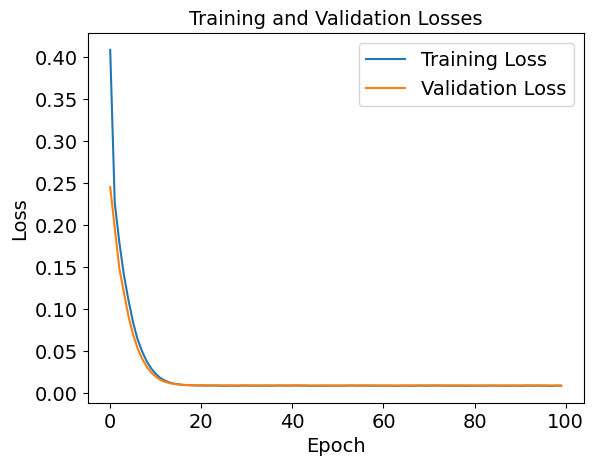

In [ ]:
# Define the learning rate and create the model, optimizer, and loss functions
lr = 0.01
model_basic = cVAE(input_dimension=148, latent_dim=4).to(device)
optimizer = torch.optim.Adam(model_basic.parameters(), lr=lr)
criterion = nn.MSELoss()

train_loss_list = []  # List to store train losses
val_loss_list = []    # List to store validation losses

num_epochs = 100
for epoch in range(num_epochs):
    train_loss_autism, train_loss_no_autism = train_no_classifier(model_basic, train_dataloader, train_dataset, device, optimizer, criterion)

    # Validate the model
    val_loss_autism, val_loss_no_autism = validate_no_classifier(model_basic, val_dataloader, val_dataset, device, criterion)

    # Appending the loss values to a list to allow for visualizations:
    train_loss_list.append(train_loss_autism + train_loss_no_autism)
    val_loss_list.append(val_loss_autism + val_loss_no_autism)

    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train Loss Autism: {train_loss_autism:.4f}, Train Loss Non-Autism: {train_loss_no_autism:.4f}")
    print(f"Val Loss Autism: {val_loss_autism:.4f}, Val Loss Non-Autism: {val_loss_no_autism:.4f}")

print("TRAINING COMPLETE")

# Plot the training and validation losses
plt.figure()
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

Here, I am saving this model

In [ ]:
torch.save(model_basic.state_dict(), 'model_basic.pth')


And here it is loaded.

In [ ]:
model_basic = cVAE(input_dimension = 148, latent_dim= 4).to(device)
model_basic.load_state_dict(torch.load('model_basic.pth'))

<All keys matched successfully>

## Model Basic Evaluation

Now, how do various covariates correlate across the autoencoders?

Firstly, here is a brief dataloader that I will use to also load the participant dataloader later.



#### Creating latent samples

In [196]:
# Dictionaries to store latent representations
latent_salient_with_classifier_autism = {'salient_vector': [], 'participant_ids': [], 'ADOS_TOTAL': [], 'ADOS_SOCIAL': [], 'DSM_IV_TR': [], 'FIQ': [], 'Age': [], 'Gender': []}

latent_with_classifier_autism = {'background_vector': [], 'participant_ids': [], 'ADOS_TOTAL': [], 'ADOS_SOCIAL': [], 'DSM_IV_TR': [], 'FIQ': [], 'Age': [], 'Gender': []}

latent_with_classifier_no_autism = {'background_vector': [], 'participant_ids': [], 'FIQ': [], 'Age': [], 'Gender': []}

latent_salient_without_classifier_autism = {'salient_vector': [], 'participant_ids': [], 'ADOS_TOTAL': [], 'ADOS_SOCIAL': [], 'DSM_IV_TR': [], 'FIQ': [], 'Age': [], 'Gender': []}

latent_without_classifier_autism = {'background_vector': [], 'participant_ids': [], 'ADOS_TOTAL': [], 'ADOS_SOCIAL': [], 'DSM_IV_TR': [], 'FIQ': [], 'Age': [], 'Gender': []}

latent_without_classifier_no_autism = {'background_vector': [], 'participant_ids': [], 'FIQ': [], 'Age': [], 'Gender': []}

# Set models to evaluation mode
model_classifier.eval()
model_basic.eval()

# Create an iterator for the data loader
no_batch_train_iterator = iter(train_dataloader_nobatch)
# Get a single batch (sample)
sample_batch = next(no_batch_train_iterator)

i = 1
# Iterate through the DataLoader
for i in range(1, 10):
    (autism_data, autism_age, autism_gender, autism_diag_group, autism_ADOS_TOTAL, autism_ADOS_SOCIAL, autism_DSM_IV_TR, autism_FIQ, autism_sub_id), (no_autism_data, no_autism_age, no_autism_gender, _, no_autism_FIQ, no_autism_sub_id) = batch

    # Move data to device if necessary
    autism_data = autism_data.to(device)
    no_autism_data = no_autism_data.to(device)

    # Generate latent representations using model with classifier
    (_, _, _, _, _, _, _, _, _, _, _, _, z_classifier, s_classifier, z_no_autism_classifier) = model_classifier(autism_data, no_autism_data)

    # Generate latent representations using model without classifier
    (_, _, _, _, _, _, _, _, z, s, z_no_autism) = model_basic(autism_data, no_autism_data)

    # Append latent vectors to dictionaries along with participant IDs and covariates for autism data with classifier
    latent_salient_with_classifier_autism['salient_vector'].append(s_classifier.detach().cpu().numpy())
    latent_salient_with_classifier_autism['participant_ids'].append(autism_sub_id)
    latent_salient_with_classifier_autism['ADOS_TOTAL'].append(autism_ADOS_TOTAL.detach().cpu().numpy())
    latent_salient_with_classifier_autism['ADOS_SOCIAL'].append(autism_ADOS_SOCIAL.detach().cpu().numpy())
    latent_salient_with_classifier_autism['DSM_IV_TR'].append(autism_DSM_IV_TR.detach().cpu().numpy())
    latent_salient_with_classifier_autism['FIQ'].append(autism_FIQ.detach().cpu().numpy())
    latent_salient_with_classifier_autism['Age'].append(autism_age.detach().cpu().numpy())
    latent_salient_with_classifier_autism['Gender'].append(autism_gender.detach().cpu().numpy())

    latent_with_classifier_autism['background_vector'].append(z_classifier.detach().cpu().numpy())
    latent_with_classifier_autism['participant_ids'].append(autism_sub_id)
    latent_with_classifier_autism['ADOS_TOTAL'].append(autism_ADOS_TOTAL.detach().cpu().numpy())
    latent_with_classifier_autism['ADOS_SOCIAL'].append(autism_ADOS_SOCIAL.detach().cpu().numpy())
    latent_with_classifier_autism['DSM_IV_TR'].append(autism_DSM_IV_TR.detach().cpu().numpy())
    latent_with_classifier_autism['FIQ'].append(autism_FIQ.detach().cpu().numpy())
    latent_with_classifier_autism['Age'].append(autism_age.detach().cpu().numpy())
    latent_with_classifier_autism['Gender'].append(autism_gender.detach().cpu().numpy())

    # Append latent vectors to dictionaries along with participant IDs and covariates for autism data without classifier
    latent_salient_without_classifier_autism['salient_vector'].append(s.detach().cpu().numpy())
    latent_salient_without_classifier_autism['participant_ids'].append(autism_sub_id)
    latent_salient_without_classifier_autism['ADOS_TOTAL'].append(autism_ADOS_TOTAL.detach().cpu().numpy())
    latent_salient_without_classifier_autism['ADOS_SOCIAL'].append(autism_ADOS_SOCIAL.detach().cpu().numpy())
    latent_salient_without_classifier_autism['DSM_IV_TR'].append(autism_DSM_IV_TR.detach().cpu().numpy())
    latent_salient_without_classifier_autism['FIQ'].append(autism_FIQ.detach().cpu().numpy())
    latent_salient_without_classifier_autism['Age'].append(autism_age.detach().cpu().numpy())
    latent_salient_without_classifier_autism['Gender'].append(autism_gender.detach().cpu().numpy())

    latent_without_classifier_autism['background_vector'].append(z.detach().cpu().numpy())
    latent_without_classifier_autism['participant_ids'].append(autism_sub_id)
    latent_without_classifier_autism['ADOS_TOTAL'].append(autism_ADOS_TOTAL.detach().cpu().numpy())
    latent_without_classifier_autism['ADOS_SOCIAL'].append(autism_ADOS_SOCIAL.detach().cpu().numpy())
    latent_without_classifier_autism['DSM_IV_TR'].append(autism_DSM_IV_TR.detach().cpu().numpy())
    latent_without_classifier_autism['FIQ'].append(autism_FIQ.detach().cpu().numpy())
    latent_without_classifier_autism['Age'].append(autism_age.detach().cpu().numpy())
    latent_without_classifier_autism['Gender'].append(autism_gender.detach().cpu().numpy())

    # Append latent vectors to dictionaries along with participant IDs and covariates for no-autism data with classifier
    latent_with_classifier_no_autism['background_vector'].append(z_no_autism_classifier.detach().cpu().numpy())
    latent_with_classifier_no_autism['participant_ids'].append(no_autism_sub_id)
    latent_with_classifier_no_autism['FIQ'].append(no_autism_FIQ.detach().cpu().numpy())
    latent_with_classifier_no_autism['Age'].append(no_autism_age.detach().cpu().numpy())
    latent_with_classifier_no_autism['Gender'].append(no_autism_gender.detach().cpu().numpy())

    # Append latent vectors to dictionaries along with participant IDs and covariates for no-autism data without classifier
    latent_without_classifier_no_autism['background_vector'].append(z_no_autism.detach().cpu().numpy())
    latent_without_classifier_no_autism['participant_ids'].append(no_autism_sub_id)
    latent_without_classifier_no_autism['FIQ'].append(no_autism_FIQ.detach().cpu().numpy())
    latent_without_classifier_no_autism['Age'].append(no_autism_age.detach().cpu().numpy())
    latent_without_classifier_no_autism['Gender'].append(no_autism_gender.detach().cpu().numpy())

    i += 1


Next, lets prepare the relevant covariates and use these latent variables to compare correlations of the latent vectors across these models. For this, an approach similar to RSA is chosen. Firstly, dissimilarity matrices are created.

In [194]:
from scipy.spatial.distance import pdist, squareform
import numpy as np

# Define a function to calculate dissimilarity matrix
def calculate_dissimilarity_matrix(latent_vectors, metric='euclidean'):
    # Flatten the list of 3D arrays to a 2D array
    latent_vectors_flat = np.vstack(latent_vectors)

    # Calculate pairwise distances
    pairwise_distances = pdist(latent_vectors_flat, metric=metric)

    # Convert condensed distance matrix to square dissimilarity matrix
    dissimilarity_matrix = squareform(pairwise_distances)

    return dissimilarity_matrix

Here are several utility functions.

In [171]:
def print_dissimilarity_matrix(matrix):
    """
    Print a dissimilarity matrix.

    Parameters:
    matrix (numpy.ndarray): The dissimilarity matrix to print.
    """
    for row in matrix:
        # Print each row of the matrix as space-separated values
        row_str = " ".join([f"{val:.7f}" for val in row])
        print(row_str)

# Here a utility function I need soon.
def flatten_dict_lists(input_dict):
    flattened_dict = {}
    for key, value in input_dict.items():
        if isinstance(value, list):
            flattened_list = [item for sublist in value for item in sublist]
            flattened_dict[key] = flattened_list
        else:
            flattened_dict[key] = value
    return flattened_dict

def find_non_numeric_indices(input_list):
    non_numeric_indices = [i for i, item in enumerate(input_list) if str(item) == "nan"]
    return non_numeric_indices

def compute_rsa(latent_vectors, variable_data):
    """
    Compute RSA (Representational Similarity Analysis) similarity between latent vectors and a variable.

    Args:
    - latent_vectors: List or array of latent vectors.
    - variable_data: List or array of data for the variable.

    Returns:
    - RSA similarity score.
    """
    # Compute the Pearson correlation between latent vectors and the current variable
    correlation_matrix = np.corrcoef(latent_vectors, variable_data)

    # Extract the upper triangular part of the correlation matrix (excluding diagonal)
    upper_triangular = squareform(correlation_matrix, checks=False)

    # Calculate RSA similarity score (mean of the upper triangular values)
    rsa_similarity = np.mean(upper_triangular)

    return rsa_similarity

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def create_rsa_bar_plots(dictionary_list1, dictionary_list2):
    # Get the list of variables to compare
    variables_to_compare = list(dictionary_list1.keys())

    # Determine the number of subplots based on the number of variables
    num_variables = len(variables_to_compare)

    if num_variables == 1:
        # Only one variable, no need for subplots
        key = variables_to_compare[0]
        rsa_values_list1 = dictionary_list1[key]
        rsa_values_list2 = dictionary_list2[key]

        # Calculate the mean of RSA values
        mean_rsa1 = np.mean(rsa_values_list1)
        mean_rsa2 = np.mean(rsa_values_list2)

        # Perform a t-test
        t_stat, p_value = stats.ttest_rel(rsa_values_list1, rsa_values_list2)

        # Create a figure for the plot
        plt.figure(figsize=(8, 6))

        # Create the bar plot for the first list (With Classifier)
        plt.bar(0.25, mean_rsa1, width=0.4, label='With Classifier', color='blue', yerr=np.std(rsa_values_list1), capsize=5, alpha=0.7)

        # Create the bar plot for the second list (Without Classifier)
        plt.bar(0.75, mean_rsa2, width=0.4, label='Without Classifier', color='red', yerr=np.std(rsa_values_list2), capsize=5, alpha=0.7)

        # Display individual data points
        plt.scatter(np.full(len(rsa_values_list1), 0.25), rsa_values_list1, color='black', marker='o', s=10, label='Individual Data', alpha=0.7)
        plt.scatter(np.full(len(rsa_values_list2), 0.75), rsa_values_list2, color='black', marker='o', s=10, alpha=0.7)

        # Set title, labels, and x-axis label
        plt.title(f'RSA Comparison - {key}\nT-Test: p-value = {p_value:.4f}', fontsize=12)
        plt.ylabel('RSA Similarity Score')
        plt.xticks([0.25, 0.75], ['With Classifier', 'Without Classifier'])

        # Show the plot
        plt.tight_layout()
        plt.show()
    else:
        # Create subplots for multiple variables
        num_rows = int(np.ceil(num_variables / 2))  # Assuming 2 columns per row
        num_cols = 2  # 2 columns per row

        # Create the subplot grid
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

        # Flatten the axs array if needed
        if num_rows == 1:
            axs = axs.reshape(1, -1)

        # Loop through variables and create subplots
        for idx, variable_name in enumerate(variables_to_compare):
            row_idx = idx // num_cols
            col_idx = idx % num_cols
            ax = axs[row_idx, col_idx]

            # Get RSA values for the current variable from both dictionaries
            rsa_values_list1 = dictionary_list1[variable_name]
            rsa_values_list2 = dictionary_list2[variable_name]

            # Calculate the mean of RSA values
            mean_rsa1 = np.mean(rsa_values_list1)
            mean_rsa2 = np.mean(rsa_values_list2)

            # Perform a t-test and display p-value
            t_stat, p_value = stats.ttest_rel(rsa_values_list1, rsa_values_list2)

            # Create bar positions
            x = np.arange(2)

            # Create a bar plot for the current variable
            ax.bar(0.25, mean_rsa1, width=0.4, label='With Classifier', color='blue', yerr=np.std(rsa_values_list1), capsize=5, alpha=0.7)
            ax.bar(0.75, mean_rsa2, width=0.4, label='Without Classifier', color='red', yerr=np.std(rsa_values_list2), capsize=5, alpha=0.7)

            # Display individual data points
            ax.scatter(np.full(len(rsa_values_list1), 0.25), rsa_values_list1, color='black', marker='o', s=10, label='Individual Data', alpha=0.7)
            ax.scatter(np.full(len(rsa_values_list2), 0.75), rsa_values_list2, color='black', marker='o', s=10, alpha=0.7)

            # Set title, labels, and x-axis label
            ax.set_title(f'RSA Comparison - {variable_name}\nT-Test: p-value = {p_value:.4f}', fontsize=12)
            ax.set_ylabel('RSA Similarity Score')
            ax.set_xticks([0.25, 0.75])
            ax.set_xticklabels(['With Classifier', 'Without Classifier'])

        # Adjust spacing between subplots
        plt.tight_layout()

        # Show the plot
        plt.show()

In [187]:
from itertools import combinations

def create_rsa_bar_plots_flexible(*dictionaries):
    num_dictionaries = len(dictionaries)

    # Get the variables that are common to all dictionaries or only in the first four dictionaries
    common_variables = set(dictionaries[0].keys())
    for dictionary in dictionaries[1:4]:
        common_variables &= set(dictionary.keys())

    # Create subplots for each common variable
    num_variables = len(common_variables)

    for variable_name in common_variables:
        plt.figure(figsize=(10, 6))  # Adjust the figure size

        # Get RSA values for the current variable from dictionaries that contain it
        rsa_values = [dictionary[variable_name] for dictionary in dictionaries if variable_name in dictionary]

        # Calculate the means of RSA values
        means = [np.mean(rsa) for rsa in rsa_values]

        # Perform pairwise t-tests
        pairwise_p_values = []
        for i, j in combinations(range(len(rsa_values)), 2):
            t_stat, p_value = stats.ttest_rel(rsa_values[i], rsa_values[j])
            pairwise_p_values.append(p_value)

        # Calculate positions for bars and significance annotations
        num_bars = len(rsa_values)
        x_positions = np.arange(num_bars)
        bar_width = 0.3
        bar_spacing = 0.1  # Reduced the bar spacing
        total_bar_space = num_bars * (bar_width + bar_spacing)
        x_positions = np.linspace(0, total_bar_space, num_bars)

        # Create bar plots for the current variable
        bars = plt.bar(x_positions, means, width=bar_width, color=['blue', 'red', 'green', 'purple'][:num_bars])

        # Display individual data points for each dictionary
        for i, rsa in enumerate(rsa_values):
            x_i = x_positions[i]  # Adjusted x position
            plt.scatter(np.full(len(rsa), x_i), rsa, color='black', marker='o', s=20, label='Individual Data', alpha=0.7)

        # Set title, labels, and x-axis label with adjusted font size
        plt.title(f'RSA Comparison - {variable_name}', fontsize=16)  # Increased title font size
        plt.ylabel('RSA Similarity Score', fontsize=14)  # Increased y-label font size

        # Dynamically generate x-axis labels based on the number of bars
        if num_bars == 4:
            x_labels = ['Salient \n With \n Classifier', 'Salient \n Without \n Classifier', 'Background \n With \n Classifier', 'Background \n Without \n Classifier']
        elif num_bars == 6:
            x_labels = ['Salient \n With \n Classifier', 'Salient \n Without \n Classifier', 'Background \n With \n Classifier', 'Background \n Without \n Classifier', 'No ASD \n With \n Classifier', 'No ASD \n Without \n Classifier']

        # Set x-axis labels with line breaks and increased font size
        plt.xticks(x_positions, x_labels, fontsize=12, rotation=0, ha='center')

        # Add significance brackets
        for i, j in combinations(range(len(rsa_values)), 2):
            if pairwise_p_values[i] < 0.05:
                significance = '*'
                bar_height_i = max(means[i], means[j]) + 0.05
                bar_height_j = max(means[i], means[j]) + 0.05
                x_i = x_positions[i]
                x_j = x_positions[j]
                plt.annotate(significance, xy=(x_i, bar_height_i), fontsize=14, ha='center', va='bottom')  # Increased annotation font size
                plt.annotate(significance, xy=(x_j, bar_height_j), fontsize=14, ha='center', va='bottom')  # Increased annotation font size

        # Print pairwise t-test results
        print(f'Pairwise t-test between Datasets 1 and 2 for variable {variable_name}: p-value = {pairwise_p_values[0]:.4f}')
        print(f'Pairwise t-test between Datasets 3 and 4 for variable {variable_name}: p-value = {pairwise_p_values[1]:.4f}')
        if num_bars == 6:
            print(f'Pairwise t-test between Datasets 5 and 6 for variable {variable_name}: p-value = {pairwise_p_values[2]:.4f}')

        # Show the plot for the current variable
        plt.tight_layout()
        plt.show()

# Example usage:
# create_rsa_bar_plots_flexible(dictionary_list1, dictionary_list2, dictionary_list3, dictionary_list4)


Next, these are used in correspondance with the covariates.

The loading of the covariates doesnt work. Maybe my data is in a different format than what was used in the code I provided. Here is how I loaded the data previously, maybe this helps to make the necessary adjustements

In [146]:
import numpy as npUser
from scipy.spatial.distance import pdist, squareform
from scipy.stats import kendalltau

# Define a function to calculate the representational dissimilarity matrix (RDM)
def make_RDM(vec, data_scale='ratio', metric='euclidean'):
    vec = np.array(vec)
    min_val = min(vec.flatten())
    max_val = max(vec.flatten())

    # Avoid division by zero by adding a small constant
    vec = (vec - min_val) / (max_val - min_val)

    if np.ndim(vec) == 1:  # must be at least 2D
        vec = np.vstack((vec, np.zeros(vec.shape))).transpose()

    mat = squareform(pdist(vec, metric=metric).transpose())
    if data_scale == 'ordinal':
        mat[mat != 0] = 1  # Make into zeros and ones

    return mat



Now I have defined the basic functions. Let's put this all together.

In [198]:
import numpy as np
from scipy.spatial.distance import squareform

def rsa_dict_without_missing_values(data_dict):
    """
    Compute RSA (Representational Similarity Analysis) for each latent vector-variable pairing in a data dictionary
    while handling missing values.latent_salient_with_classifier_autism['age'].append(autism_age.detach().cpu().numpy())
latent_salient_with_classifier_autism['gender'].append(autism_gender.detach().cpu().numpy())


    Args:
    - data_dict: Dictionary where keys are variable names and values are lists or arrays of data.
                 The first key is assumed to represent latent vectors, and the second key is participant IDs.

    Returns:
    - Dictionary of RSA similarity scores for each variable pairing, or None if any pairing has missing values.
    """
    rsa_results = {}  # Dictionary to store RSA results

    variable_scales = {
    'ADOS_TOTAL': 'ratio',
    'ADOS_SOCIAL': 'ratio',
    'DSM_IV_TR': 'ordinal',
    'AGE_AT_SCAN': 'ratio',
    'SEX': 'ordinal',
    'FIQ': 'ordinal',
    'Age': 'ratio',
    'Gender': 'ordinal'}

    # Get latent vectors and participant IDs
    latent_vectors = data_dict[list(data_dict.keys())[0]]
    participant_ids = data_dict['participant_ids']

    # Iterate through variables
    for variable_name, variable_data in data_dict.items():
        if variable_name != 'salient_vector' and variable_name != 'participant_ids' and variable_name != 'background_vector':
            rsa_values = []  # List to store RSA values for each sample
            for i in range(len(latent_vectors)):
                latent_vector = latent_vectors[i]
                covariate = variable_data[i]

                # Find indices of NAs
                missings = find_non_numeric_indices(covariate)

                # Exclude missing values
                latent_vector_no_missing = [item for j, item in enumerate(latent_vector) if j not in missings]
                covariate_no_missing = [item for j, item in enumerate(covariate) if j not in missings]

                # Create matrices
                dissimilarity_latent_no_missing = calculate_dissimilarity_matrix([latent_vector_no_missing])

                rdm_covariate = make_RDM(covariate_no_missing, data_scale=variable_scales[variable_name])

                # Compute RSA similarity score
                rsa_similarity = compute_rsa(dissimilarity_latent_no_missing, rdm_covariate)
                rsa_values.append(rsa_similarity)

            # Append the RSA values to the results dictionary
            rsa_results[variable_name] = rsa_values

    return rsa_results


Now, let's get the output for each of the latent variables.

In [199]:
# Generate RSA results for each dictionary
rsa_salient_with_classifier_autism = rsa_dict_without_missing_values(latent_salient_with_classifier_autism)
rsa_with_classifier_autism = rsa_dict_without_missing_values(latent_with_classifier_autism)
rsa_with_classifier_no_autism = rsa_dict_without_missing_values(latent_with_classifier_no_autism)
rsa_salient_without_classifier_autism = rsa_dict_without_missing_values(latent_salient_without_classifier_autism)
rsa_without_classifier_autism = rsa_dict_without_missing_values(latent_without_classifier_autism)
rsa_without_classifier_no_autism = rsa_dict_without_missing_values(latent_without_classifier_no_autism)

# Print or store the RSA results
print("RSA results for latent_salient_with_classifier_autism:", rsa_salient_with_classifier_autism)
print("RSA results for latent_with_classifier_autism:", rsa_with_classifier_autism)
print("RSA results for latent_with_classifier_no_autism:", rsa_with_classifier_no_autism)
print("RSA results for latent_salient_without_classifier_autism:", rsa_salient_without_classifier_autism)
print("RSA results for latent_without_classifier_autism:", rsa_without_classifier_autism)
print("RSA results for latent_without_classifier_no_autism:", rsa_without_classifier_no_autism)


RSA results for latent_salient_with_classifier_autism: {'ADOS_TOTAL': [0.03105551966139278, 0.033749581206608106, 0.03705121892464112, -0.005913893965423564, 0.06258126168469555, 0.06650168593823999, 0.03544069285295071, 0.06991373077183663, -0.019297114880075954], 'ADOS_SOCIAL': [0.024060190446677565, -0.03457723919682096, 0.010672153798879985, -0.011214783071609401, 0.0813012661210578, 0.13945258455772266, 0.058151367585958465, 0.08695397065817327, -0.030710896995011422], 'DSM_IV_TR': [0.01850244128526865, 0.024195653544379764, 0.023123801768252062, 0.019852374834206436, 0.046924440780037414, 0.07007373460407242, 0.02074090410104382, 0.00999673118877897, -0.0021746906590145057], 'FIQ': [0.013036503409807746, 0.02211580262080126, 0.010189959285043184, 0.022463312170933673, 0.044072941743501196, 0.07279794513369081, 0.04273040482600887, 0.010444959842976146, -0.003290464839014981], 'Age': [0.12519863197531966, 0.19604693094565687, 0.11477562725363412, 0.19479602346853006, 0.32315842375

Pairwise t-test between Datasets 1 and 2 for variable FIQ: p-value = 0.1879
Pairwise t-test between Datasets 3 and 4 for variable FIQ: p-value = 0.6438
Pairwise t-test between Datasets 5 and 6 for variable FIQ: p-value = 0.6601


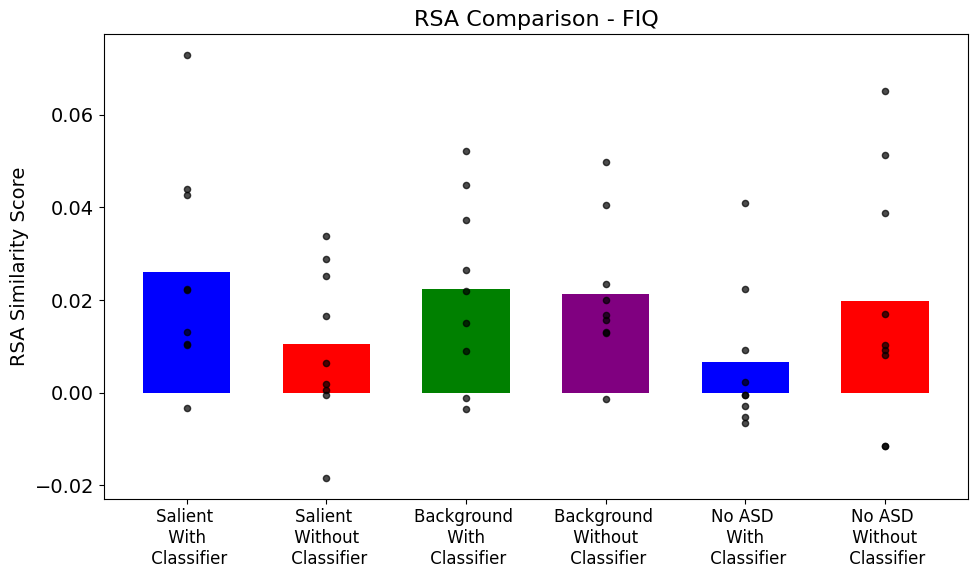

Pairwise t-test between Datasets 1 and 2 for variable Gender: p-value = 0.6333
Pairwise t-test between Datasets 3 and 4 for variable Gender: p-value = 0.2937
Pairwise t-test between Datasets 5 and 6 for variable Gender: p-value = 0.9964


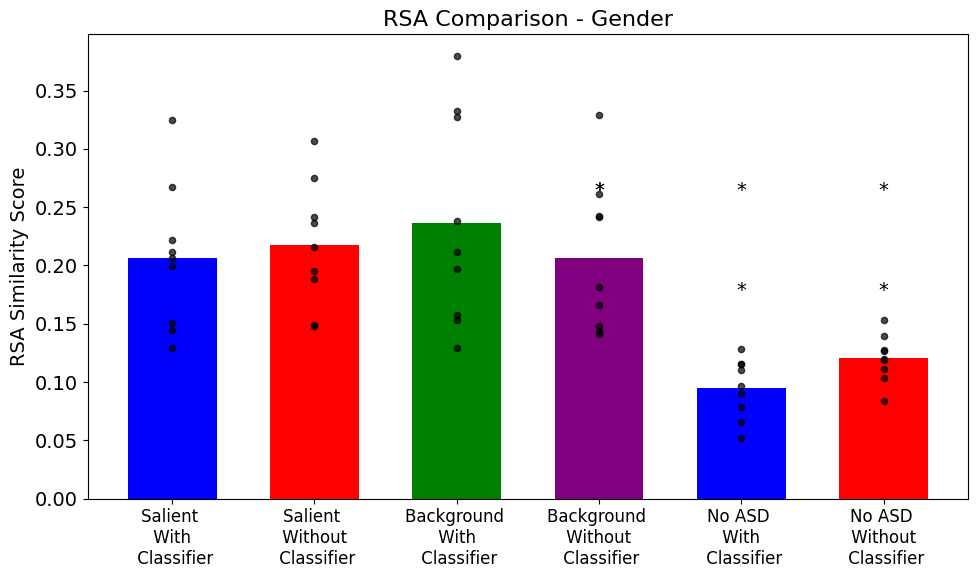

Pairwise t-test between Datasets 1 and 2 for variable DSM_IV_TR: p-value = 0.0690
Pairwise t-test between Datasets 3 and 4 for variable DSM_IV_TR: p-value = 0.7708


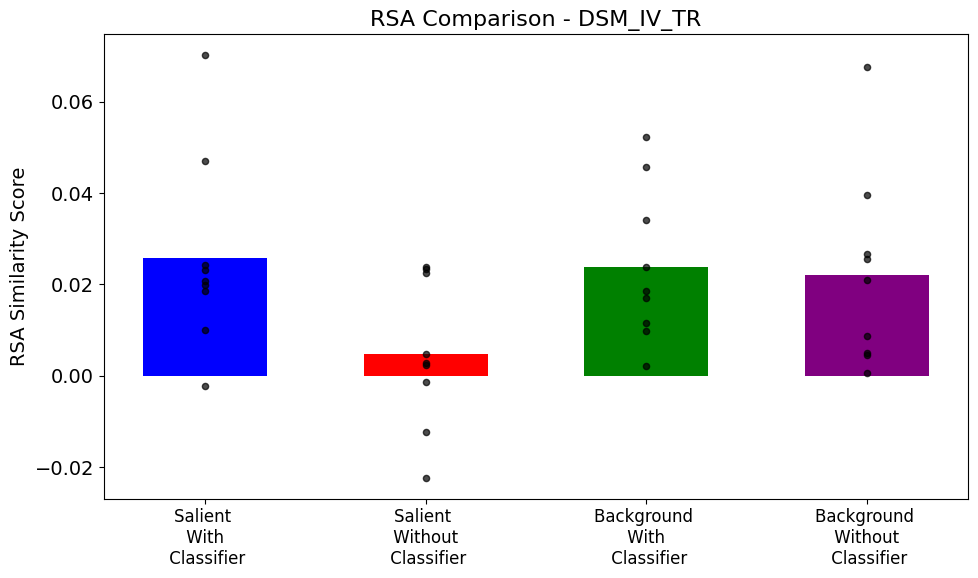

Pairwise t-test between Datasets 1 and 2 for variable Age: p-value = 0.5873
Pairwise t-test between Datasets 3 and 4 for variable Age: p-value = 0.5632
Pairwise t-test between Datasets 5 and 6 for variable Age: p-value = 0.3383


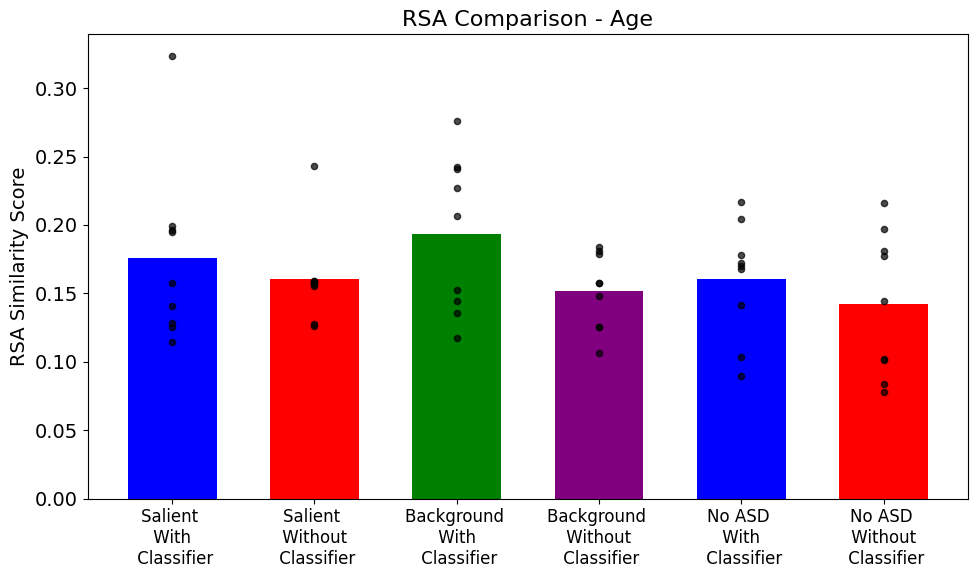

Pairwise t-test between Datasets 1 and 2 for variable ADOS_SOCIAL: p-value = 0.2123
Pairwise t-test between Datasets 3 and 4 for variable ADOS_SOCIAL: p-value = 0.7244


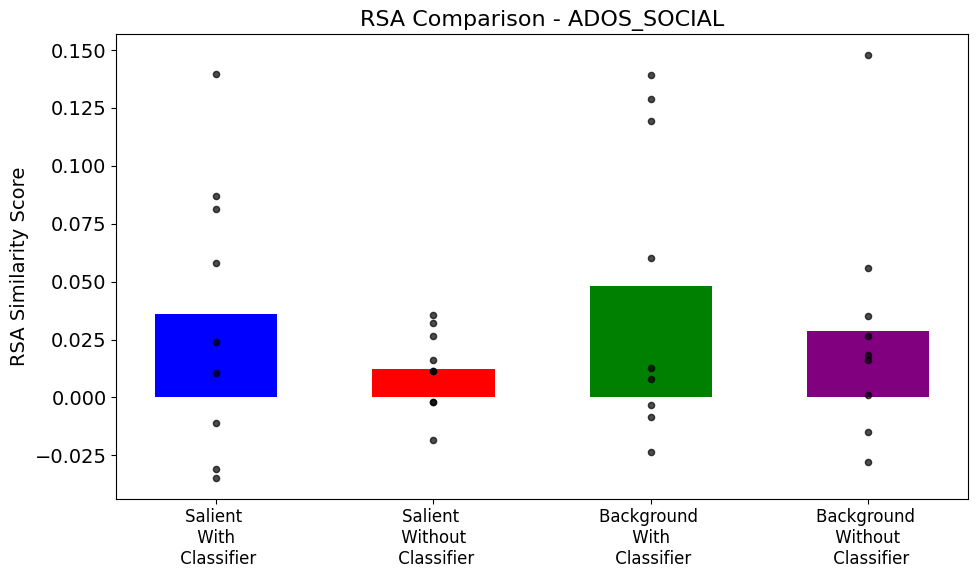

Pairwise t-test between Datasets 1 and 2 for variable ADOS_TOTAL: p-value = 0.1400
Pairwise t-test between Datasets 3 and 4 for variable ADOS_TOTAL: p-value = 0.3339


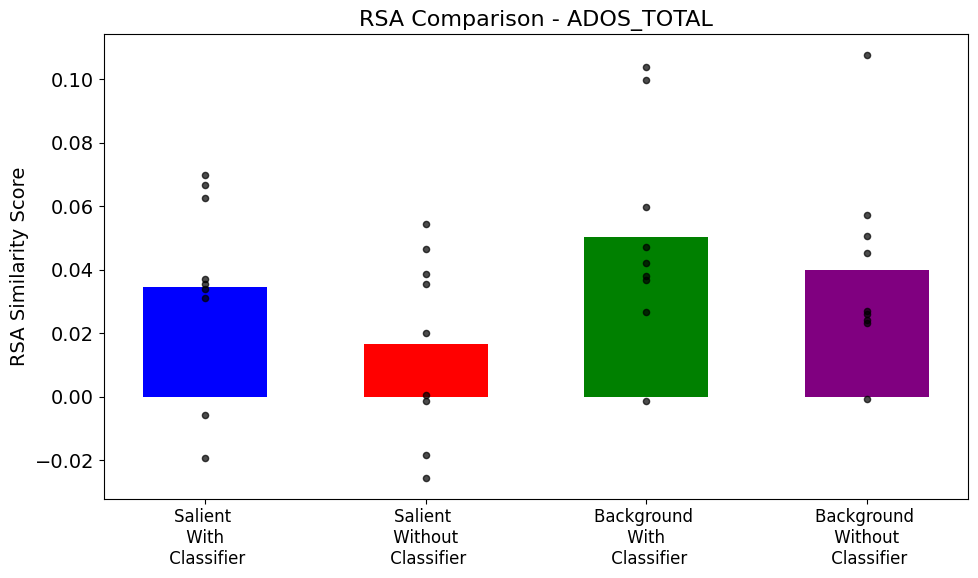

In [200]:
create_rsa_bar_plots_flexible(rsa_salient_with_classifier_autism, rsa_salient_without_classifier_autism, rsa_with_classifier_autism, rsa_without_classifier_autism, rsa_with_classifier_no_autism,rsa_without_classifier_no_autism)

Next, lets compare the results

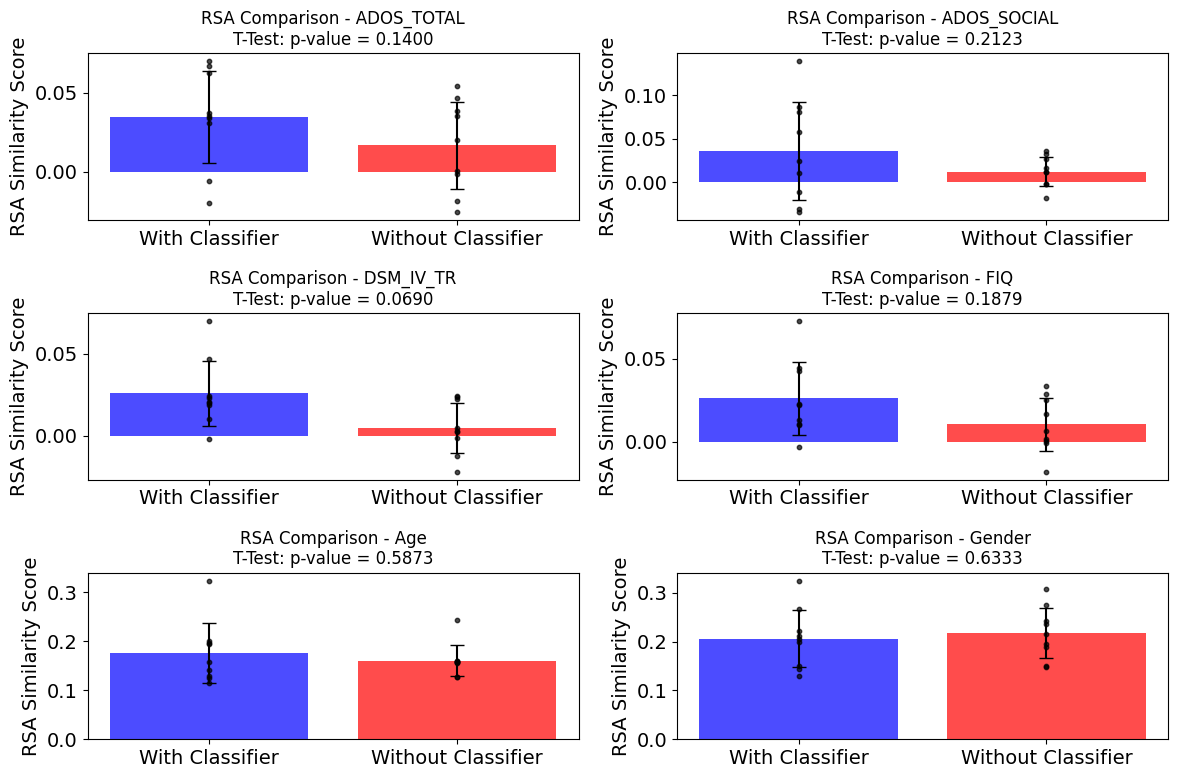

In [201]:
# Pair 1: RSA Salient with Classifier Autism vs. RSA Salient without Classifier Autism
create_rsa_bar_plots(rsa_salient_with_classifier_autism, rsa_salient_without_classifier_autism)

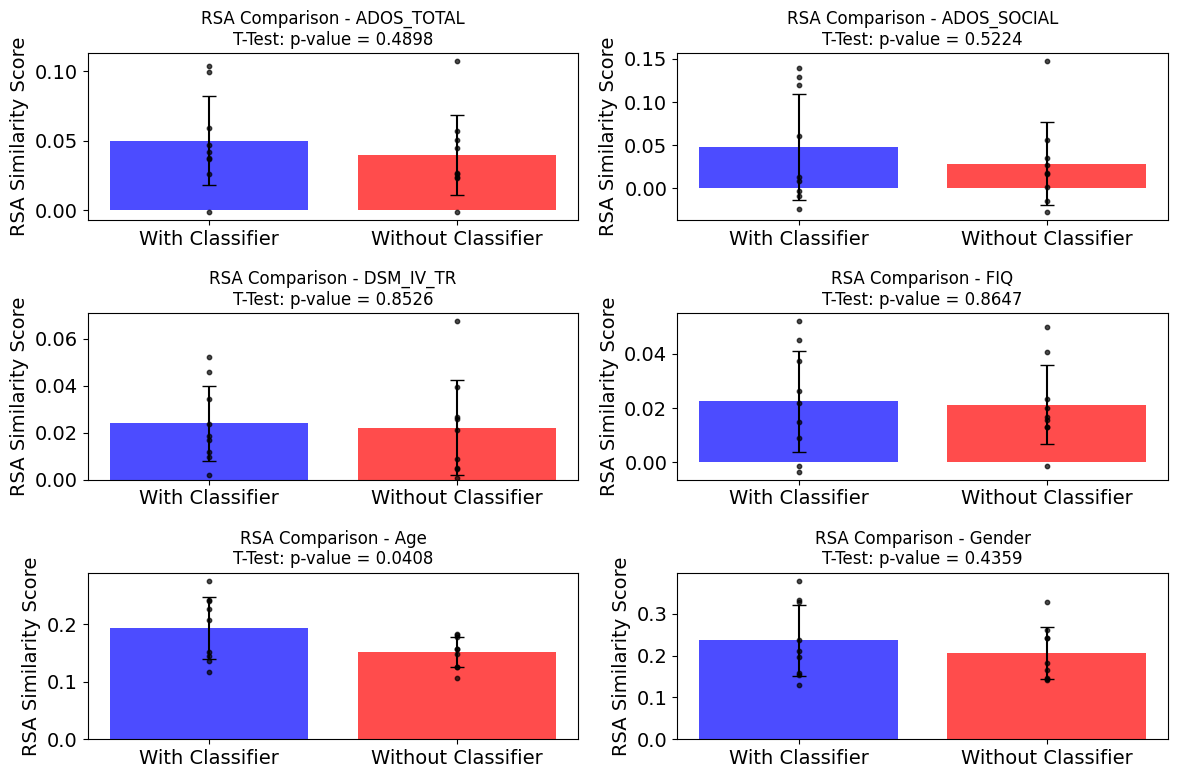

In [202]:
# Pair 2: RSA With Classifier Autism vs. RSA Without Classifier Autism
create_rsa_bar_plots(rsa_with_classifier_autism, rsa_without_classifier_autism)


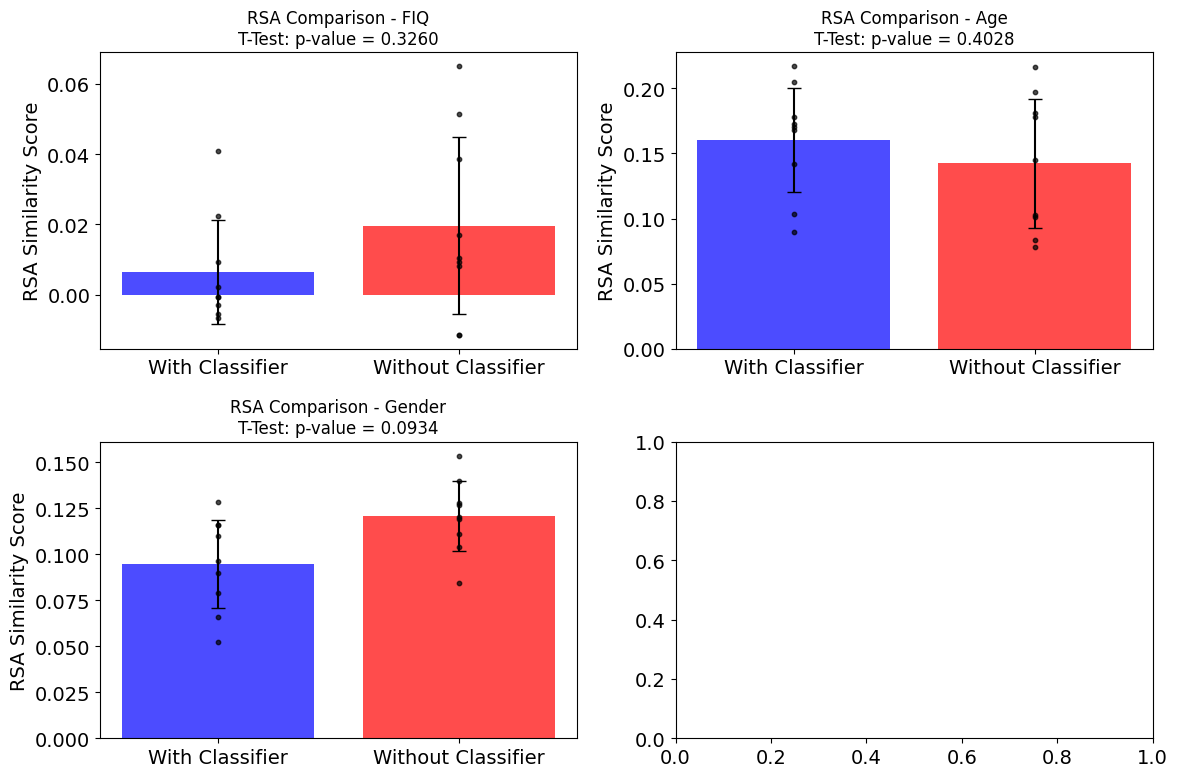

In [203]:
# Pair 3: RSA With Classifier No Autism vs. RSA Without Classifier No Autism
create_rsa_bar_plots(rsa_with_classifier_no_autism, rsa_without_classifier_no_autism)

## t-SNE Analyses

Next, I want to look at the latent representaitons and if we see any clustering according to gender, or if the classifier leads to a change in the latent space in relation to age.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming you have latent_vectors, ages, and genders as numpy arrays
# latent_vectors should be a 2D array, where each row corresponds to a latent vector

# Compute t-SNE embeddings
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(latent_vectors)

# Create a DataFrame to store the data
data = pd.DataFrame({
    'tsne_x': tsne_embeddings[:, 0],
    'tsne_y': tsne_embeddings[:, 1],
    'age': ages,
    'gender': genders
})

# Create a scatter plot with color-coded points
plt.figure(figsize=(10, 8))

# Scatter plot with colors based on age
for age_group, group_data in data.groupby('age'):
    plt.scatter(group_data['tsne_x'], group_data['tsne_y'], label=f'Age {age_group}')

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Latent Representations by Age')
plt.legend()
plt.show()

# Create a scatter plot with colors based on gender
plt.figure(figsize=(10, 8))

colors = {'Male': 'blue', 'Female': 'red'}
for gender, group_data in data.groupby('gender'):
    plt.scatter(group_data['tsne_x'], group_data['tsne_y'], label=gender, color=colors[gender])

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Latent Representations by Gender')
plt.legend()
plt.show()


## Classification performance

Next, I want to look into how good the classifier does.

Firstly, lets look at the sample used for training.

** CURRENTLY DOESNT WORK ** AOC value for age is off. Maybe turn to float for actual computation of binary cross entropy, not for this?


In [ ]:
#!pip install bootstrapped
from sklearn.metrics import roc_auc_score, r2_score
from statsmodels.stats.proportion import proportion_confint
#from bootstrapped import bootstrap
from sklearn.utils import resample

# Initialize lists to store accuracy values, participant counts, and group-wise breakdown
accuracy_values = []
participant_counts = []

# Initialize dictionaries to store group-wise accuracy and ROC-AUC
accuracy_by_group = {
    'Autism': [],
    'No Autism': [],
}
roc_auc_by_group = {
    'Autism': [],
    'No Autism': [],
}

r2_values = []

# Initialize a list to store all actual ages
all_actual_ages = []

# Initialize vectors to store true and predicted labels
true_labels_autism_age = []
predicted_labels_autism_age = []
true_labels_no_autism_age = []
predicted_labels_no_autism_age = []
true_labels_autism_gender = []
predicted_labels_autism_gender = []
true_labels_no_autism_gender = []
predicted_labels_no_autism_gender = []

# Set the model to evaluation mode
model_classifier.eval()
# Iterate through the validation dataloader
for batch in train_dataloader:
    ((autism_data, autism_age, autism_gender, autism_diag_group, _,_,_,_,autism_sub_id), (no_autism_data, no_autism_age, no_autism_gender, no_autism_diag_group,_,no_autism_sub_id)) = batch

    # Move data to device if necessary
    autism_data = autism_data.to(device)
    no_autism_data = no_autism_data.to(device)

    # Generate predictions using the trained model
    _, _, _, _, _, _, _, _, class_autism_age, class_autism_gender, class_no_autism_age, class_no_autism_gender, _, _ = model_classifier(autism_data, no_autism_data)

    # Append true and predicted labels for autism group
    true_labels_autism_age.extend(autism_age.cpu().detach().numpy())
    predicted_labels_autism_age.extend(class_autism_age.cpu().detach().numpy())

    true_labels_autism_gender.extend(autism_gender.cpu().detach().numpy())
    predicted_labels_autism_gender.extend(class_autism_gender.cpu().detach().numpy())

    # Append true and predicted labels for no autism group
    true_labels_no_autism_age.extend(no_autism_age.cpu().detach().numpy())
    predicted_labels_no_autism_age.extend(class_no_autism_age.cpu().detach().numpy())

    true_labels_no_autism_gender.extend(no_autism_gender.cpu().detach().numpy())
    predicted_labels_no_autism_gender.extend(class_no_autism_gender.cpu().detach().numpy())

    print(true_labels_no_autism_gender,"asdfasdf" , predicted_labels_no_autism_gender )

    all_actual_ages.extend(autism_age.cpu().detach().numpy())
    all_actual_ages.extend(no_autism_age.cpu().detach().numpy())


# Calculate ROC-AUC for gender prediction in the autism group
roc_auc_autism_gender = roc_auc_score(true_labels_autism_gender, predicted_labels_autism_gender)
roc_auc_by_group['Autism'].append(roc_auc_autism_gender)

# Calculate ROC-AUC for gender prediction in the no autism group
roc_auc_no_autism_gender = roc_auc_score(true_labels_no_autism_gender, predicted_labels_no_autism_gender)
roc_auc_by_group['No Autism'].append(roc_auc_no_autism_gender)

# Calculate accuracy for participants with autism
accuracy_autism = np.abs(np.array(true_labels_autism_age) - np.array(predicted_labels_autism_age)).mean()

# Calculate accuracy for participants without autism
accuracy_no_autism = np.abs(np.array(true_labels_no_autism_age) - np.array(predicted_labels_no_autism_age)).mean()

# Calculate the total number of participants
num_participants = len(true_labels_autism_age) + len(true_labels_no_autism_age)

# Append accuracy and participant count to the lists
accuracy_values.append((accuracy_autism + accuracy_no_autism) / 2)  # Average accuracy for both groups
participant_counts.append(num_participants)

# Calculate R-squared for participants with autism
r2_autism = r2_score(true_labels_autism_age, predicted_labels_autism_age)
r2_values.append(r2_autism)

# Calculate R-squared for participants without autism
r2_no_autism = r2_score(true_labels_no_autism_age, predicted_labels_no_autism_age)
r2_values.append(r2_no_autism)

# Compute the standard deviation of actual ages
std_deviation_actual_ages = np.std(all_actual_ages)

# Compute the grand mean accuracy
weighted_sum = sum(accuracy * count for accuracy, count in zip(accuracy_values, participant_counts))
total_participants = sum(participant_counts)
grand_mean_accuracy = weighted_sum / total_participants

# Compute the grand mean R-squared
grand_mean_r2 = np.mean(r2_values)

# Calculate confidence interval for accuracy (e.g., 95% confidence)
proportions = [accuracy / 100.0 for accuracy in accuracy_values]
ci_accuracy = proportion_confint(sum(proportions), len(proportions), alpha=0.05, method='wilson')

# Calculate confidence interval for R-squared (e.g., 95% confidence)
lower_bound_r2 = np.percentile(r2_values, 2.5)
upper_bound_r2 = np.percentile(r2_values, 97.5)
ci_r2 = (lower_bound_r2, upper_bound_r2)

# Calculate confidence interval for ROC-AUC (e.g., 95% confidence)
n_iterations = 1000  # Number of bootstrap iterations
alpha = 0.05  # Significance level
roc_auc_ci = []

for _ in range(n_iterations):
    # Resample with replacement
    resampled_auc = resample(roc_auc_by_group['Autism'] + roc_auc_by_group['No Autism'])

    # Calculate ROC-AUC on the resampled data
    roc_auc = np.mean(resampled_auc)
    roc_auc_ci.append(roc_auc)

# Calculate lower and upper percentiles of the bootstrapped ROC-AUC values
lower_bound_roc_auc = np.percentile(roc_auc_ci, 100 * alpha / 2)
upper_bound_roc_auc = np.percentile(roc_auc_ci, 100 * (1 - alpha / 2))

#Calculate statistics separately for Autism and No Autism groups
for group in ['Autism', 'No Autism']:
    # Calculate ROC-AUC for gender prediction in the group
    roc_auc_group_gender = roc_auc_score(true_labels_autism_gender, predicted_labels_autism_gender) if group == 'Autism' else roc_auc_score(true_labels_no_autism_gender, predicted_labels_no_autism_gender)
    roc_auc_by_group[group].append(roc_auc_group_gender)

    # Calculate accuracy for participants in the group
    true_labels_group_age = true_labels_autism_age if group == 'Autism' else true_labels_no_autism_age
    predicted_labels_group_age = predicted_labels_autism_age if group == 'Autism' else predicted_labels_no_autism_age

    accuracy_group_age = np.abs(np.array(true_labels_group_age) - np.array(predicted_labels_group_age)).mean()
    accuracy_by_group[group].append(accuracy_group_age)

    # Calculate R-squared for participants in the group
    r2_group_age = r2_score(true_labels_group_age, predicted_labels_group_age)
    r2_values.append(r2_group_age)

# Print results
print("Results for Age Prediction:")
print("-" * 30)
print("Standard Deviation of Actual Ages:", std_deviation_actual_ages)
print("Grand Mean Accuracy (Age Prediction):", grand_mean_accuracy)
print("Grand Mean R-squared (Age Prediction):", grand_mean_r2)

# Print group-wise accuracy values
for group, group_accuracies in accuracy_by_group.items():
    group_mean_accuracy = sum(group_accuracies) / len(group_accuracies)
    print(f"{group} Mean Accuracy (Age Prediction):", group_mean_accuracy)

print("\n")

print("Results for Gender Prediction:")
print("-" * 30)
# Print ROC-AUC scores
for group, roc_auc in roc_auc_by_group.items():
    mean_roc_auc = np.mean(roc_auc)
    print(f"{group} ROC-AUC Score (Gender Prediction): {mean_roc_auc:.4f}")

    # Interpretation
    if mean_roc_auc < 0.5:
        print(f"The model's gender predictions for {group.lower()} group are worse than random guessing.")
    elif mean_roc_auc == 0.5:
        print(f"The model's gender predictions for {group.lower()} group are similar to random guessing.")
    elif mean_roc_auc > 0.5 and mean_roc_auc < 0.7:
        print(f"The model's gender predictions for {group.lower()} group are acceptable but not highly accurate.")
    elif mean_roc_auc >= 0.7 and mean_roc_auc < 0.8:
        print(f"The model's gender predictions for {group.lower()} group are moderately accurate.")
    else:
        print(f"The model's gender predictions for {group.lower()} group are highly accurate.")

print("\n")

# Print Confidence Intervals
print("Confidence Intervals:")
print("-" * 30)
print("Confidence Interval for Accuracy (95%):", ci_accuracy)
print("Confidence Interval for R-squared (95%):", ci_r2)
print("Confidence Interval for ROC-AUC (95%):", (lower_bound_roc_auc, upper_bound_roc_auc))

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0] asdfasdf [array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], d

Next the sample used for validation

In [ ]:
#!pip install bootstrapped
from sklearn.metrics import roc_auc_score, r2_score
from statsmodels.stats.proportion import proportion_confint
#from bootstrapped import bootstrap
from sklearn.utils import resample

# Initialize lists to store accuracy values, participant counts, and group-wise breakdown
accuracy_values = []
participant_counts = []

# Initialize dictionaries to store group-wise accuracy and ROC-AUC
accuracy_by_group = {
    'Autism': [],
    'No Autism': [],
}
roc_auc_by_group = {
    'Autism': [],
    'No Autism': [],
}

r2_values = []

# Initialize a list to store all actual ages
all_actual_ages = []

# Initialize vectors to store true and predicted labels
true_labels_autism_age = []
predicted_labels_autism_age = []
true_labels_no_autism_age = []
predicted_labels_no_autism_age = []
true_labels_autism_gender = []
predicted_labels_autism_gender = []
true_labels_no_autism_gender = []
predicted_labels_no_autism_gender = []

# Set the model to evaluation mode
model_classifier.eval()
# Iterate through the validation dataloader
for batch in val_dataloader:
    ((autism_data, autism_age, autism_gender, autism_diag_group, _,_,_,_,autism_sub_id), (no_autism_data, no_autism_age, no_autism_gender, no_autism_diag_group,_,no_autism_sub_id)) = batch

    # Move data to device if necessary
    autism_data = autism_data.to(device)
    no_autism_data = no_autism_data.to(device)

    # Generate predictions using the trained model
    _, _, _, _, _, _, _, _, class_autism_age, class_autism_gender, class_no_autism_age, class_no_autism_gender, _, _ = model_classifier(autism_data, no_autism_data)

    # Append true and predicted labels for autism group
    true_labels_autism_age.extend(autism_age.cpu().detach().numpy())
    predicted_labels_autism_age.extend(class_autism_age.cpu().detach().numpy())

    true_labels_autism_gender.extend(autism_gender.cpu().detach().numpy())
    predicted_labels_autism_gender.extend(class_autism_gender.cpu().detach().numpy())

    # Append true and predicted labels for no autism group
    true_labels_no_autism_age.extend(no_autism_age.cpu().detach().numpy())
    predicted_labels_no_autism_age.extend(class_no_autism_age.cpu().detach().numpy())

    true_labels_no_autism_gender.extend(no_autism_gender.cpu().detach().numpy())
    predicted_labels_no_autism_gender.extend(class_no_autism_gender.cpu().detach().numpy())

    all_actual_ages.extend(autism_age.cpu().detach().numpy())
    all_actual_ages.extend(no_autism_age.cpu().detach().numpy())


# Calculate ROC-AUC for gender prediction in the autism group
roc_auc_autism_gender = roc_auc_score(true_labels_autism_gender, predicted_labels_autism_gender)
roc_auc_by_group['Autism'].append(roc_auc_autism_gender)

# Calculate ROC-AUC for gender prediction in the no autism group
roc_auc_no_autism_gender = roc_auc_score(true_labels_no_autism_gender, predicted_labels_no_autism_gender)
roc_auc_by_group['No Autism'].append(roc_auc_no_autism_gender)

# Calculate accuracy for participants with autism
accuracy_autism = np.abs(np.array(true_labels_autism_age) - np.array(predicted_labels_autism_age)).mean()

# Calculate accuracy for participants without autism
accuracy_no_autism = np.abs(np.array(true_labels_no_autism_age) - np.array(predicted_labels_no_autism_age)).mean()

# Calculate the total number of participants
num_participants = len(true_labels_autism_age) + len(true_labels_no_autism_age)

# Append accuracy and participant count to the lists
accuracy_values.append((accuracy_autism + accuracy_no_autism) / 2)  # Average accuracy for both groups
participant_counts.append(num_participants)

# Calculate R-squared for participants with autism
r2_autism = r2_score(true_labels_autism_age, predicted_labels_autism_age)
r2_values.append(r2_autism)

# Calculate R-squared for participants without autism
r2_no_autism = r2_score(true_labels_no_autism_age, predicted_labels_no_autism_age)
r2_values.append(r2_no_autism)

# Compute the standard deviation of actual ages
std_deviation_actual_ages = np.std(all_actual_ages)

# Compute the grand mean accuracy
weighted_sum = sum(accuracy * count for accuracy, count in zip(accuracy_values, participant_counts))
total_participants = sum(participant_counts)
grand_mean_accuracy = weighted_sum / total_participants

# Compute the grand mean R-squared
grand_mean_r2 = np.mean(r2_values)

# Calculate confidence interval for accuracy (e.g., 95% confidence)
proportions = [accuracy / 100.0 for accuracy in accuracy_values]
ci_accuracy = proportion_confint(sum(proportions), len(proportions), alpha=0.05, method='wilson')

# Calculate confidence interval for R-squared (e.g., 95% confidence)
lower_bound_r2 = np.percentile(r2_values, 2.5)
upper_bound_r2 = np.percentile(r2_values, 97.5)
ci_r2 = (lower_bound_r2, upper_bound_r2)

# Calculate confidence interval for ROC-AUC (e.g., 95% confidence)
n_iterations = 1000  # Number of bootstrap iterations
alpha = 0.05  # Significance level
roc_auc_ci = []

for _ in range(n_iterations):
    # Resample with replacement
    resampled_auc = resample(roc_auc_by_group['Autism'] + roc_auc_by_group['No Autism'])

    # Calculate ROC-AUC on the resampled data
    roc_auc = np.mean(resampled_auc)
    roc_auc_ci.append(roc_auc)

# Calculate lower and upper percentiles of the bootstrapped ROC-AUC values
lower_bound_roc_auc = np.percentile(roc_auc_ci, 100 * alpha / 2)
upper_bound_roc_auc = np.percentile(roc_auc_ci, 100 * (1 - alpha / 2))

# Calculate statistics separately for Autism and No Autism groups
for group in ['Autism', 'No Autism']:
    # Calculate ROC-AUC for gender prediction in the group
    roc_auc_group_gender = roc_auc_score(true_labels_autism_gender, predicted_labels_autism_gender) if group == 'Autism' else roc_auc_score(true_labels_no_autism_gender, predicted_labels_no_autism_gender)
    roc_auc_by_group[group].append(roc_auc_group_gender)

    # Calculate accuracy for participants in the group
    true_labels_group_age = true_labels_autism_age if group == 'Autism' else true_labels_no_autism_age
    predicted_labels_group_age = predicted_labels_autism_age if group == 'Autism' else predicted_labels_no_autism_age

    accuracy_group_age = np.abs(np.array(true_labels_group_age) - np.array(predicted_labels_group_age)).mean()
    accuracy_by_group[group].append(accuracy_group_age)

    # Calculate R-squared for participants in the group
    r2_group_age = r2_score(true_labels_group_age, predicted_labels_group_age)
    r2_values.append(r2_group_age)

# Print results
print("Results for Age Prediction:")
print("-" * 30)
print("Standard Deviation of Actual Ages:", std_deviation_actual_ages)
print("Grand Mean Accuracy (Age Prediction):", grand_mean_accuracy)
print("Grand Mean R-squared (Age Prediction):", grand_mean_r2)

# Print group-wise accuracy values
for group, group_accuracies in accuracy_by_group.items():
    group_mean_accuracy = sum(group_accuracies) / len(group_accuracies)
    print(f"{group} Mean Accuracy (Age Prediction):", group_mean_accuracy)

print("\n")

print("Results for Gender Prediction:")
print("-" * 30)
# Print ROC-AUC scores
for group, roc_auc in roc_auc_by_group.items():
    mean_roc_auc = np.mean(roc_auc)
    print(f"{group} ROC-AUC Score (Gender Prediction): {mean_roc_auc:.4f}")

    # Interpretation
    if mean_roc_auc < 0.5:
        print(f"The model's gender predictions for {group.lower()} group are worse than random guessing.")
    elif mean_roc_auc == 0.5:
        print(f"The model's gender predictions for {group.lower()} group are similar to random guessing.")
    elif mean_roc_auc > 0.5 and mean_roc_auc < 0.7:
        print(f"The model's gender predictions for {group.lower()} group are acceptable but not highly accurate.")
    elif mean_roc_auc >= 0.7 and mean_roc_auc < 0.8:
        print(f"The model's gender predictions for {group.lower()} group are moderately accurate.")
    else:
        print(f"The model's gender predictions for {group.lower()} group are highly accurate.")

print("\n")

# Print Confidence Intervals
print("Confidence Intervals:")
print("-" * 30)
print("Confidence Interval for Accuracy (95%):", ci_accuracy)
print("Confidence Interval for R-squared (95%):", ci_r2)
print("Confidence Interval for ROC-AUC (95%):", (lower_bound_roc_auc, upper_bound_roc_auc))

Results for Age Prediction:
------------------------------
Standard Deviation of Actual Ages: 8.230031
Grand Mean Accuracy (Age Prediction): 6.699837684631348
Grand Mean R-squared (Age Prediction): 0.16007629821858887
Autism Mean Accuracy (Age Prediction): 6.596375942230225
No Autism Mean Accuracy (Age Prediction): 6.803299903869629


Results for Gender Prediction:
------------------------------
Autism ROC-AUC Score (Gender Prediction): 0.5000
The model's gender predictions for autism group are similar to random guessing.
No Autism ROC-AUC Score (Gender Prediction): 0.5000
The model's gender predictions for no autism group are similar to random guessing.


Confidence Intervals:
------------------------------
Confidence Interval for Accuracy (95%): (0.0011306809818505958, 0.8199969422448996)
Confidence Interval for R-squared (95%): (0.15957416377441902, 0.16057843266275873)
Confidence Interval for ROC-AUC (95%): (0.5, 0.5)


Accuracy confidence intervall: This is related to age. Higher than 0, its reasonably confident. Notice, how this is basically 0 if rounded, so not really confident.

R-Squread: Model doesn't predict gender well at all.

ROC-AUC: Model included .5, the model is similar to random guessing.

## Model Comparisons


One thing that is apparent here, is that the model gender prediction is rather unstable and is around .5. Let's test different values here.

Training with k = 1


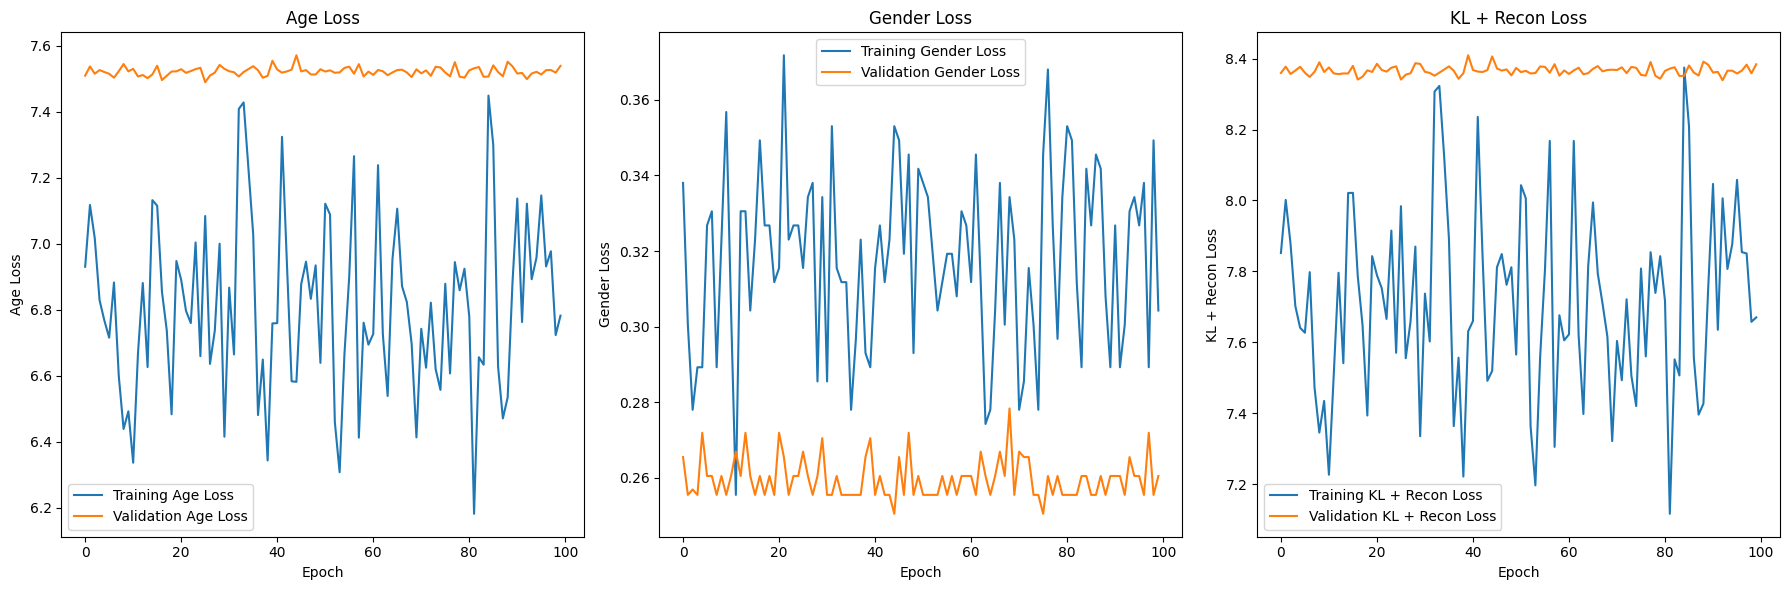

Training with k = 2


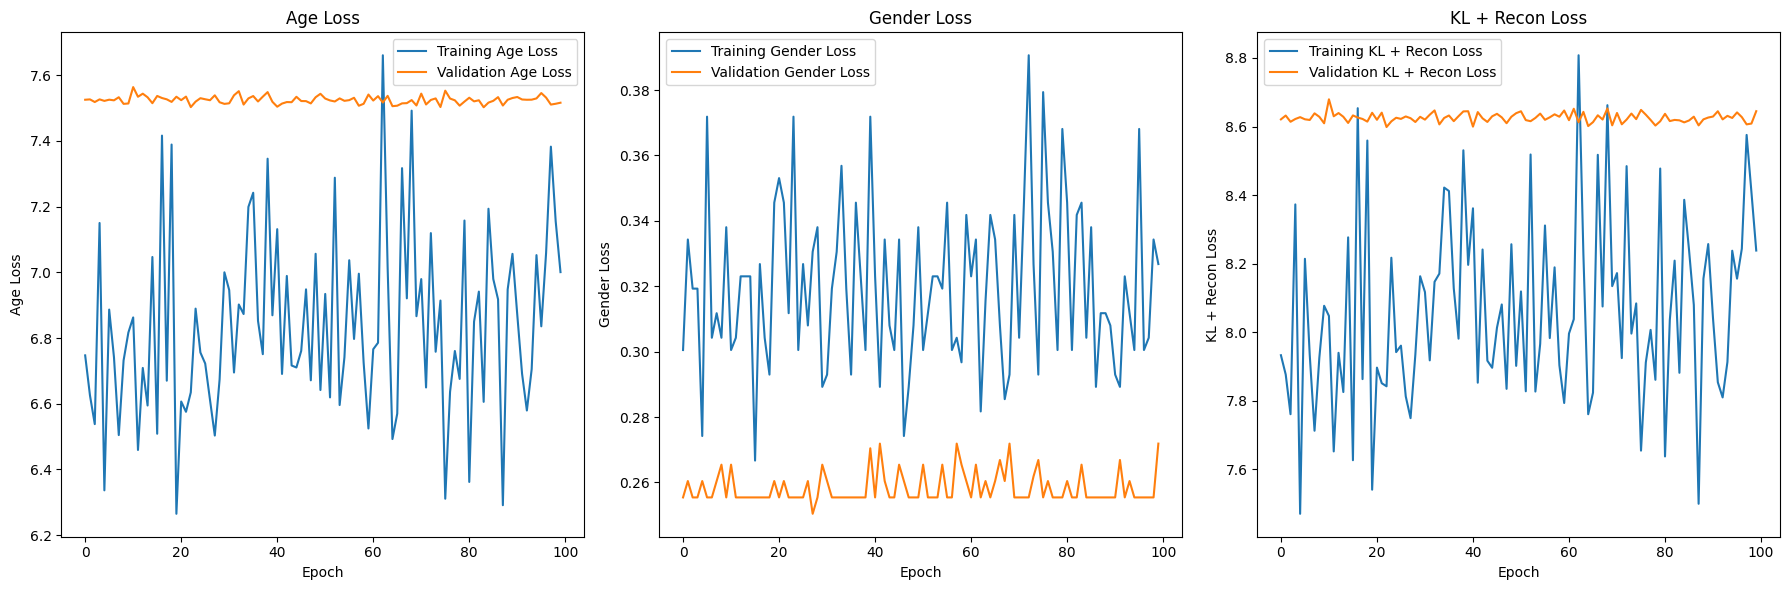

Training with k = 3


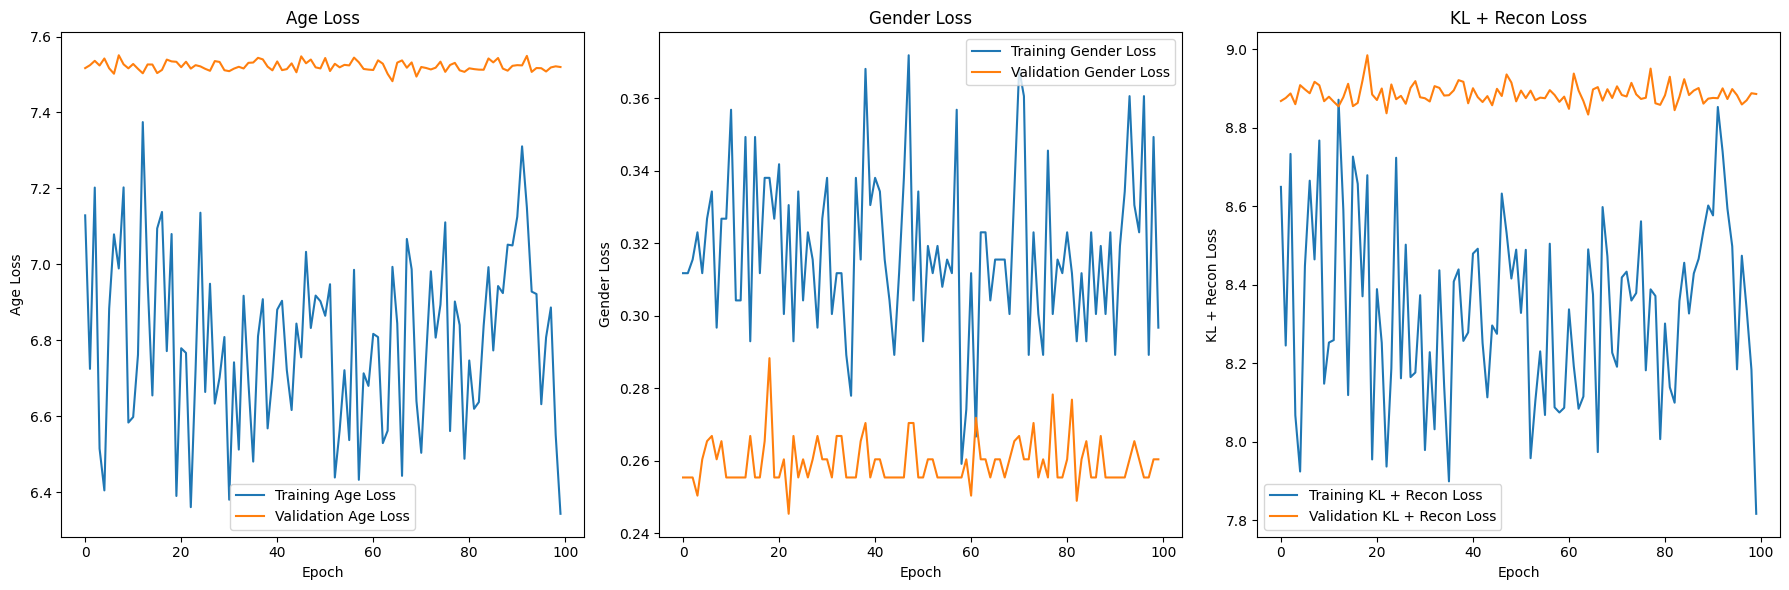

In [ ]:
def final_loss_test(MSE, CE, MSE_age, z_mu, z_logvar, s_mu, s_logvar, k = 1):
    """
    This function will add the reconstruction loss (BCELoss) and the KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: reconstruction loss
    :param z_mu: mean from the latent vector of encoder_z
    :param z_logvar: log variance from the latent vector of encoder_z
    :param s_mu: mean from the latent vector of encoder_s (optional)
    :param s_logvar: log variance from the latent vector of encoder_s (optional)
    """
    mse_loss = MSE
    mse_age = MSE_age
    cross_entropy = CE
    KLD_z = -0.5 * torch.sum(1 + z_logvar - z_mu.pow(2) - z_logvar.exp())
    if cross_entropy is not None or mse_age is not None:
      if s_mu is not None and s_logvar is not None:
          KLD_s = -0.5 * torch.sum(1 + s_logvar - s_mu.pow(2) - s_logvar.exp())
          return mse_loss + KLD_z + KLD_s + cross_entropy*k + mse_age
      else:
          return mse_loss + KLD_z + cross_entropy*k + mse_age
    else:
      if s_mu is not None and s_logvar is not None:
          KLD_s = -0.5 * torch.sum(1 + s_logvar - s_mu.pow(2) - s_logvar.exp())
          return mse_loss + KLD_z + KLD_s
      else:
          return mse_loss + KLD_z


def train_test(model, dataloader, dataset, device, optimizer, criterion, criterion_classifier, k_value = 1):
    model.train()
    running_loss_autism = 0.0
    running_loss_no_autism = 0.0
    running_age_loss_autism = 0.0
    running_gender_loss_autism = 0.0
    running_age_loss_no_autism = 0.0
    running_gender_loss_no_autism = 0.0
    counter = 0

    total_batches = len(dataset) // dataloader.batch_size

    for i, ((autism_data, autism_age, autism_gender, autism_diag_group,_,_,_,_,_), (no_autism_data, no_autism_age, no_autism_gender,  no_autism_diag_group,_,_)) in tqdm(enumerate(dataloader), total=total_batches, leave = False):
        autism_data = autism_data.to(device)
        no_autism_data = no_autism_data.to(device)

        autism_age = autism_age.to(device)
        autism_gender = autism_gender.to(device)

        no_autism_age = no_autism_age.to(device)
        no_autism_gender = no_autism_gender.to(device)

        optimizer.zero_grad()

        # Get the model outputs
        z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, class_autism_age, class_autism_gender, class_no_autism_age, class_no_autism_gender, _,_,_ = model(autism_data, no_autism_data)

        # Calculate classifier losses for age and gender predictions
        age_loss_autism = criterion(class_autism_age, autism_age.unsqueeze(1))
        gender_loss_autism = criterion_classifier(class_autism_gender, autism_gender.unsqueeze(1).float())

        age_loss_no_autism = criterion(class_no_autism_age, no_autism_age.unsqueeze(1))
        gender_loss_no_autism = criterion_classifier(class_no_autism_gender, no_autism_gender.unsqueeze(1).float())


        # Section for the autism images
        bce_loss_autism = criterion(reconstructed_data_autism, autism_data)
        loss_autism = final_loss_test(bce_loss_autism,  gender_loss_autism, age_loss_autism, z_mean, z_log_var, s_mean, s_log_var, k_value)
        running_loss_autism += loss_autism.item()
        running_age_loss_autism += age_loss_autism.item()
        running_gender_loss_autism += gender_loss_autism.item()

        # Section for the no_autism images
        bce_loss_no_autism = criterion(reconstructed_data_no_autism, no_autism_data)
        s_mean_no_autism, s_log_var_no_autism = None, None
        loss_no_autism = final_loss_test(bce_loss_no_autism,  gender_loss_no_autism, age_loss_no_autism, z_mean_no_autism, z_log_var_no_autism, s_mean_no_autism, s_log_var_no_autism, k_value)
        running_loss_no_autism += loss_no_autism.item()
        running_age_loss_no_autism += age_loss_no_autism.item()
        running_gender_loss_no_autism += gender_loss_no_autism.item()

        # Total loss
        loss_no_autism.backward()
        loss_autism.backward()

        optimizer.step()
        counter += len(autism_data) + len(no_autism_data)

    train_loss_autism = running_loss_autism / counter
    train_loss_no_autism = running_loss_no_autism / counter
    train_age_loss_autism = running_age_loss_autism / counter
    train_gender_loss_autism = running_gender_loss_autism / counter
    train_age_loss_no_autism = running_age_loss_no_autism / counter
    train_gender_loss_no_autism = running_gender_loss_no_autism / counter

    return train_loss_autism, train_loss_no_autism, train_age_loss_autism, train_gender_loss_autism, train_age_loss_no_autism, train_gender_loss_no_autism

def validate_test(model, dataloader, dataset, device, criterion, criterion_classifier, k_value = 1):
    model.eval()  # Set the model to evaluation mode
    running_loss_autism = 0.0
    running_loss_no_autism = 0.0
    running_age_loss_autism = 0.0
    running_gender_loss_autism = 0.0
    running_age_loss_no_autism = 0.0
    running_gender_loss_no_autism = 0.0
    counter = 0

    total_batches = len(dataset) // dataloader.batch_size

    with torch.no_grad():  # Disable gradient calculation during validation
        for i, ((autism_data, autism_age, autism_gender, autism_diag_group,_,_,_,_,_), (no_autism_data, no_autism_age, no_autism_gender, no_autism_diag_group,_,_)) in tqdm(enumerate(dataloader), total=total_batches, leave = False):
            autism_data = autism_data.to(device)
            no_autism_data = no_autism_data.to(device)

            autism_age = autism_age.to(device)
            autism_gender = autism_gender.to(device)

            no_autism_age = no_autism_age.to(device)
            no_autism_gender = no_autism_gender.to(device)

            # Get the model outputs
            z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, class_autism_age, class_autism_gender, class_no_autism_age, class_no_autism_gender, _,_,_ = model(autism_data, no_autism_data)

            # Calculate classifier losses for age and gender predictions
            age_loss_autism = criterion(class_autism_age, autism_age.unsqueeze(1))
            gender_loss_autism = criterion_classifier(class_autism_gender, autism_gender.unsqueeze(1).float())

            age_loss_no_autism = criterion(class_no_autism_age, no_autism_age.unsqueeze(1))
            gender_loss_no_autism = criterion_classifier(class_no_autism_gender, no_autism_gender.unsqueeze(1).float())

            # Section for the autism images
            bce_loss_autism = criterion(reconstructed_data_autism, autism_data)
            loss_autism = final_loss_test(bce_loss_autism, gender_loss_autism, age_loss_autism, z_mean, z_log_var, s_mean, s_log_var, k_value)
            running_loss_autism += loss_autism.item()
            running_age_loss_autism += age_loss_autism.item()
            running_gender_loss_autism += gender_loss_autism.item()

            # Section for the no_autism images
            bce_loss_no_autism = criterion(reconstructed_data_no_autism, no_autism_data)
            s_mean_no_autism, s_log_var_no_autism = None, None
            loss_no_autism = final_loss_test(bce_loss_no_autism, gender_loss_no_autism, age_loss_no_autism, z_mean_no_autism, z_log_var_no_autism, s_mean_no_autism, s_log_var_no_autism, k_value)
            running_loss_no_autism += loss_no_autism.item()
            running_age_loss_no_autism += age_loss_no_autism.item()
            running_gender_loss_no_autism += gender_loss_no_autism.item()

            counter += len(autism_data) + len(no_autism_data)

    val_loss_autism = running_loss_autism / counter
    val_loss_no_autism = running_loss_no_autism / counter
    val_age_loss_autism = running_age_loss_autism / counter
    val_gender_loss_autism = running_gender_loss_autism / counter
    val_age_loss_no_autism = running_age_loss_no_autism / counter
    val_gender_loss_no_autism = running_gender_loss_no_autism / counter

    return (
        val_loss_autism, val_loss_no_autism,
        val_age_loss_autism, val_gender_loss_autism,
        val_age_loss_no_autism, val_gender_loss_no_autism
    )


lr = 0.01
model_classifier_weight_to_gender_test = cVAE_classifier(input_dimension = 148, latent_dim= 4).to(device)
optimizer = torch.optim.Adam(model_classifier.parameters(), lr=lr)
criterion = nn.MSELoss()
classifier_criterion = nn.BCELoss()

# Define a list of k values to iterate through
k_values = [1, 2, 3]

# Create separate lists for training and validation losses for age, gender, and other terms
for k_value in k_values:
    print(f"Training with k = {k_value}")

    # Reset loss lists for each k value
    train_age_losses = []
    val_age_losses = []
    train_gender_losses = []
    val_gender_losses = []
    train_other_losses = []
    val_other_losses = []

    num_epochs = 100
    for epoch in range(num_epochs):
        # Train the model
        (   train_loss_autism,
            train_loss_no_autism,
            train_age_loss_autism,
            train_gender_loss_autism,
            train_age_loss_no_autism,
            train_gender_loss_no_autism) = train_test(
            model_classifier_weight_to_gender_test,
            train_dataloader,
            train_dataset,
            device,
            optimizer,
            criterion,
            classifier_criterion,
            k_value)

        # Validate the model
        val_loss_autism, val_loss_no_autism, val_age_loss_autism, val_gender_loss_autism, val_age_loss_no_autism, val_gender_loss_no_autism = validate_test(model_classifier_weight_to_gender_test, val_dataloader, val_dataset, device, criterion, classifier_criterion, k_value)

        # Appending the loss values to their respective lists for visualizations:
        train_age_losses.append(train_age_loss_autism + train_age_loss_no_autism)
        train_gender_losses.append(train_gender_loss_autism + train_gender_loss_no_autism)
        train_other_losses.append(train_loss_autism + train_loss_no_autism)

        val_age_losses.append(val_age_loss_autism + val_age_loss_no_autism)
        val_gender_losses.append(val_gender_loss_autism + val_gender_loss_no_autism)
        val_other_losses.append(val_loss_autism + val_loss_no_autism)

    # Create subplots for loss in relation to age, gender, and other loss terms
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Plot training and validation losses for age
    axs[0].plot(train_age_losses, label='Training Age Loss')
    axs[0].plot(val_age_losses, label='Validation Age Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Age Loss')
    axs[0].set_title('Age Loss')
    axs[0].legend()

    # Plot training and validation losses for gender
    axs[1].plot(train_gender_losses, label='Training Gender Loss')
    axs[1].plot(val_gender_losses, label='Validation Gender Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Gender Loss')
    axs[1].set_title('Gender Loss')
    axs[1].legend()

    # Plot training and validation losses for other terms (KL divergence + Reconstruction loss)
    axs[2].plot(train_other_losses, label='Training KL + Recon Loss')
    axs[2].plot(val_other_losses, label='Validation KL + Recon Loss')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('KL + Recon Loss')
    axs[2].set_title('KL + Recon Loss')
    axs[2].legend()

    # Adjust subplot layout
    plt.tight_layout()

    # Show the plots for the current k value
    plt.show()



### Other models to compare:

Firstly, I will train a model without the classifier. Here is the corresponding model architecture: